In [1]:
#@title Imports 
import os
import mne 
import pickle
import random
import warnings
import numpy as np
import matplotlib.pyplot as plt

from Inner_Speech_Dataset.Python_Processing.Data_extractions import  Extract_data_from_subject, Extract_subject_from_BDF, load_events
from Inner_Speech_Dataset.Python_Processing.Data_processing import  Select_time_window, Transform_for_classificator, Split_trial_in_time,  Filter_by_condition


mne.set_log_level(verbose='warning') #to avoid info at terminal
warnings.filterwarnings(action = "ignore", category = DeprecationWarning ) 
warnings.filterwarnings(action = "ignore", category = FutureWarning )

from EEGNet import *
from sklearn.model_selection import train_test_split
from tensorflow.keras import utils as np_utils
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import KFold
from pyriemann.utils.viz import plot_confusion_matrix
from sklearn import metrics
import tensorflow as tf

2022-11-11 17:22:36.483301: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
### Hyperparameters

# The root dir have to point to the folder that cointains the database
root_dir = "/data/datasets/inner_speech/ds003626/"

# Data Type
datatype = "EEG"

# Sampling rate
fs = 256

# Select the useful par of each trial. Time in seconds
t_start = 1.5
t_end = 3.5

# Subject number
N_S = 1   #[1 to 10]

In [3]:
#@title Data extraction and processing

# Load all trials for a sigle subject
X, Y = Extract_data_from_subject(root_dir, N_S, datatype)
X1, Y1 = Extract_subject_from_BDF(root_dir, N_S, 1)

#events = load_events(root_dir, N_S, 1)

# Cut usefull time. i.e action interval
X = Select_time_window(X = X, t_start = t_start, t_end = t_end, fs = fs)

In [57]:
As = [0, 1, 3, 4, 7, 8, 9, 14, 18, 19, 21, 22, 23]
Cs = [18, 20, 27, 31, 32]
Ds = [5, 6, 10, 15, 19, 21, 26, 30]

In [63]:
cs = list(map(lambda x: x+63, Cs))
ds = list(map(lambda x: x+95, Ds))
As + cs + ds

[0,
 1,
 3,
 4,
 7,
 8,
 9,
 14,
 18,
 19,
 21,
 22,
 23,
 81,
 83,
 90,
 94,
 95,
 100,
 101,
 105,
 110,
 114,
 116,
 121,
 125]

In [54]:
x = X1.to_data_frame()

In [56]:
for c in x.columns:
    print(c)

time
A1
A2
A3
A4
A5
A6
A7
A8
A9
A10
A11
A12
A13
A14
A15
A16
A17
A18
A19
A20
A21
A22
A23
A24
A25
A26
A27
A28
A29
A30
A31
A32
B1
B2
B3
B4
B5
B6
B7
B8
B9
B10
B11
B12
B13
B14
B15
B16
B17
B18
B19
B20
B21
B22
B23
B24
B25
B26
B27
B28
B29
B30
B31
B32
C1
C2
C3
C4
C5
C6
C7
C8
C9
C10
C11
C12
C13
C14
C15
C16
C17
C18
C19
C20
C21
C22
C23
C24
C25
C26
C27
C28
C29
C30
C31
C32
D1
D2
D3
D4
D5
D6
D7
D8
D9
D10
D11
D12
D13
D14
D15
D16
D17
D18
D19
D20
D21
D22
D23
D24
D25
D26
D27
D28
D29
D30
D31
D32
EXG1
EXG2
EXG3
EXG4
EXG5
EXG6
EXG7
EXG8
Status


In [48]:
X[:,[1,2,3],:].shape

(500, 3, 512)

In [4]:
x_min = X.min(axis=(2), keepdims=True)
x_max = X.max(axis=(2), keepdims=True)

x_min.shape

x = (X - x_min)/(x_max-x_min)

In [5]:
X, Y = Filter_by_condition(X, Y, "INNER")
y_labels = Y[:,1]

In [6]:
print("Data shape: [trials x channels x samples]")
print(X.shape) # Trials, channels, samples

print("Labels shape")
print(Y.shape) # Time stamp, class , condition, session

Data shape: [trials x channels x samples]
(200, 128, 512)
Labels shape
(200, 4)


In [53]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y_labels, test_size=0.2, random_state=24)

In [54]:
kernels, chans, samples = 1, X.shape[1], X.shape[2]

In [55]:
# convert labels to one-hot encodings.
Y_train      = np_utils.to_categorical(Y_train)
Y_test       = np_utils.to_categorical(Y_test)

In [56]:
X_train      = X_train.reshape(X_train.shape[0], chans, samples, kernels)
X_test       = X_test.reshape(X_test.shape[0], chans, samples, kernels)

In [64]:
# configure the EEGNet-8,2,16 model with kernel length of 32 samples (other 
# model configurations may do better, but this is a good starting point)
model = EEGNet(nb_classes = 4, Chans = chans, Samples = samples) 
               #dropoutRate = 0.5, kernLength = 106, F1 = 40, D = 10, F2 = 128, 
               #dropoutType = 'Dropout')

In [65]:
model.compile(
        tf.keras.optimizers.Adam(
            # Specifies the range of values for the tuner to try
            learning_rate=0.00011714,
            name="Adam"),
            loss='categorical_crossentropy',
            metrics=['accuracy'])

In [66]:
# count number of parameters in the model
numParams    = model.count_params()    

# set a valid path for your system to record model checkpoints
checkpointer = ModelCheckpoint(filepath='checkpoint.h5', verbose=1, monitor='val_accuracy',
                               save_best_only=True)


In [60]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.4, random_state=24)

In [67]:
fittedModel = model.fit(X_train, Y_train, batch_size = 32, epochs = 300, 
                        verbose = 2,
                        validation_data=(X_val, Y_val),
                        callbacks=[checkpointer])
                       

Epoch 1/300

Epoch 1: val_accuracy improved from -inf to 0.25000, saving model to checkpoint.h5
3/3 - 1s - loss: 1.3893 - accuracy: 0.2604 - val_loss: 1.3863 - val_accuracy: 0.2500 - 705ms/epoch - 235ms/step
Epoch 2/300

Epoch 2: val_accuracy did not improve from 0.25000
3/3 - 0s - loss: 1.3860 - accuracy: 0.2917 - val_loss: 1.3863 - val_accuracy: 0.2500 - 125ms/epoch - 42ms/step
Epoch 3/300

Epoch 3: val_accuracy did not improve from 0.25000
3/3 - 0s - loss: 1.3862 - accuracy: 0.2188 - val_loss: 1.3864 - val_accuracy: 0.2500 - 111ms/epoch - 37ms/step
Epoch 4/300

Epoch 4: val_accuracy did not improve from 0.25000
3/3 - 0s - loss: 1.3865 - accuracy: 0.1979 - val_loss: 1.3864 - val_accuracy: 0.2500 - 96ms/epoch - 32ms/step
Epoch 5/300

Epoch 5: val_accuracy did not improve from 0.25000
3/3 - 0s - loss: 1.3856 - accuracy: 0.2917 - val_loss: 1.3864 - val_accuracy: 0.2500 - 89ms/epoch - 30ms/step
Epoch 6/300

Epoch 6: val_accuracy did not improve from 0.25000
3/3 - 0s - loss: 1.3855 - accu

Epoch 48/300

Epoch 48: val_accuracy did not improve from 0.25000
3/3 - 0s - loss: 1.3686 - accuracy: 0.4167 - val_loss: 1.3872 - val_accuracy: 0.2500 - 79ms/epoch - 26ms/step
Epoch 49/300

Epoch 49: val_accuracy did not improve from 0.25000
3/3 - 0s - loss: 1.3647 - accuracy: 0.4479 - val_loss: 1.3872 - val_accuracy: 0.2500 - 81ms/epoch - 27ms/step
Epoch 50/300

Epoch 50: val_accuracy did not improve from 0.25000
3/3 - 0s - loss: 1.3665 - accuracy: 0.4375 - val_loss: 1.3872 - val_accuracy: 0.2500 - 80ms/epoch - 27ms/step
Epoch 51/300

Epoch 51: val_accuracy did not improve from 0.25000
3/3 - 0s - loss: 1.3607 - accuracy: 0.4062 - val_loss: 1.3872 - val_accuracy: 0.2500 - 76ms/epoch - 25ms/step
Epoch 52/300

Epoch 52: val_accuracy did not improve from 0.25000
3/3 - 0s - loss: 1.3613 - accuracy: 0.4271 - val_loss: 1.3872 - val_accuracy: 0.2500 - 80ms/epoch - 27ms/step
Epoch 53/300

Epoch 53: val_accuracy did not improve from 0.25000
3/3 - 0s - loss: 1.3626 - accuracy: 0.4167 - val_loss:

Epoch 95/300

Epoch 95: val_accuracy did not improve from 0.25000
3/3 - 0s - loss: 1.2214 - accuracy: 0.5417 - val_loss: 1.3865 - val_accuracy: 0.2500 - 80ms/epoch - 27ms/step
Epoch 96/300

Epoch 96: val_accuracy did not improve from 0.25000
3/3 - 0s - loss: 1.2189 - accuracy: 0.5312 - val_loss: 1.3866 - val_accuracy: 0.2500 - 81ms/epoch - 27ms/step
Epoch 97/300

Epoch 97: val_accuracy did not improve from 0.25000
3/3 - 0s - loss: 1.2155 - accuracy: 0.5521 - val_loss: 1.3866 - val_accuracy: 0.2500 - 78ms/epoch - 26ms/step
Epoch 98/300

Epoch 98: val_accuracy did not improve from 0.25000
3/3 - 0s - loss: 1.2240 - accuracy: 0.4792 - val_loss: 1.3866 - val_accuracy: 0.2500 - 79ms/epoch - 26ms/step
Epoch 99/300

Epoch 99: val_accuracy did not improve from 0.25000
3/3 - 0s - loss: 1.2187 - accuracy: 0.5104 - val_loss: 1.3865 - val_accuracy: 0.2500 - 78ms/epoch - 26ms/step
Epoch 100/300

Epoch 100: val_accuracy did not improve from 0.25000
3/3 - 0s - loss: 1.2103 - accuracy: 0.5417 - val_los

3/3 - 0s - loss: 1.0743 - accuracy: 0.6146 - val_loss: 1.3890 - val_accuracy: 0.2344 - 80ms/epoch - 27ms/step
Epoch 142/300

Epoch 142: val_accuracy did not improve from 0.25000
3/3 - 0s - loss: 1.1006 - accuracy: 0.5521 - val_loss: 1.3891 - val_accuracy: 0.2344 - 80ms/epoch - 27ms/step
Epoch 143/300

Epoch 143: val_accuracy did not improve from 0.25000
3/3 - 0s - loss: 1.0827 - accuracy: 0.6042 - val_loss: 1.3893 - val_accuracy: 0.2344 - 77ms/epoch - 26ms/step
Epoch 144/300

Epoch 144: val_accuracy did not improve from 0.25000
3/3 - 0s - loss: 1.0591 - accuracy: 0.6458 - val_loss: 1.3894 - val_accuracy: 0.2344 - 78ms/epoch - 26ms/step
Epoch 145/300

Epoch 145: val_accuracy did not improve from 0.25000
3/3 - 0s - loss: 1.0674 - accuracy: 0.6250 - val_loss: 1.3897 - val_accuracy: 0.2344 - 83ms/epoch - 28ms/step
Epoch 146/300

Epoch 146: val_accuracy did not improve from 0.25000
3/3 - 0s - loss: 1.0739 - accuracy: 0.5938 - val_loss: 1.3900 - val_accuracy: 0.2344 - 78ms/epoch - 26ms/step


Epoch 188/300

Epoch 188: val_accuracy did not improve from 0.25000
3/3 - 0s - loss: 0.9581 - accuracy: 0.6979 - val_loss: 1.4443 - val_accuracy: 0.1875 - 79ms/epoch - 26ms/step
Epoch 189/300

Epoch 189: val_accuracy did not improve from 0.25000
3/3 - 0s - loss: 0.9849 - accuracy: 0.6146 - val_loss: 1.4476 - val_accuracy: 0.2031 - 81ms/epoch - 27ms/step
Epoch 190/300

Epoch 190: val_accuracy did not improve from 0.25000
3/3 - 0s - loss: 0.9475 - accuracy: 0.6875 - val_loss: 1.4498 - val_accuracy: 0.2031 - 82ms/epoch - 27ms/step
Epoch 191/300

Epoch 191: val_accuracy did not improve from 0.25000
3/3 - 0s - loss: 0.9532 - accuracy: 0.6979 - val_loss: 1.4550 - val_accuracy: 0.1875 - 79ms/epoch - 26ms/step
Epoch 192/300

Epoch 192: val_accuracy did not improve from 0.25000
3/3 - 0s - loss: 0.9657 - accuracy: 0.6875 - val_loss: 1.4585 - val_accuracy: 0.2031 - 79ms/epoch - 26ms/step
Epoch 193/300

Epoch 193: val_accuracy did not improve from 0.25000
3/3 - 0s - loss: 0.9335 - accuracy: 0.7396


Epoch 234: val_accuracy did not improve from 0.25000
3/3 - 0s - loss: 0.8663 - accuracy: 0.7500 - val_loss: 1.5892 - val_accuracy: 0.2031 - 78ms/epoch - 26ms/step
Epoch 235/300

Epoch 235: val_accuracy did not improve from 0.25000
3/3 - 0s - loss: 0.8771 - accuracy: 0.6979 - val_loss: 1.5888 - val_accuracy: 0.2188 - 79ms/epoch - 26ms/step
Epoch 236/300

Epoch 236: val_accuracy did not improve from 0.25000
3/3 - 0s - loss: 0.8826 - accuracy: 0.7083 - val_loss: 1.5910 - val_accuracy: 0.2188 - 80ms/epoch - 27ms/step
Epoch 237/300

Epoch 237: val_accuracy did not improve from 0.25000
3/3 - 0s - loss: 0.8700 - accuracy: 0.7188 - val_loss: 1.5902 - val_accuracy: 0.2344 - 81ms/epoch - 27ms/step
Epoch 238/300

Epoch 238: val_accuracy did not improve from 0.25000
3/3 - 0s - loss: 0.8791 - accuracy: 0.7604 - val_loss: 1.5819 - val_accuracy: 0.2031 - 81ms/epoch - 27ms/step
Epoch 239/300

Epoch 239: val_accuracy did not improve from 0.25000
3/3 - 0s - loss: 0.8550 - accuracy: 0.7708 - val_loss: 1

3/3 - 0s - loss: 0.7574 - accuracy: 0.8125 - val_loss: 1.7186 - val_accuracy: 0.1719 - 79ms/epoch - 26ms/step
Epoch 281/300

Epoch 281: val_accuracy did not improve from 0.25000
3/3 - 0s - loss: 0.7905 - accuracy: 0.7812 - val_loss: 1.7203 - val_accuracy: 0.1875 - 79ms/epoch - 26ms/step
Epoch 282/300

Epoch 282: val_accuracy did not improve from 0.25000
3/3 - 0s - loss: 0.7527 - accuracy: 0.8333 - val_loss: 1.7246 - val_accuracy: 0.1719 - 82ms/epoch - 27ms/step
Epoch 283/300

Epoch 283: val_accuracy did not improve from 0.25000
3/3 - 0s - loss: 0.7615 - accuracy: 0.8125 - val_loss: 1.7270 - val_accuracy: 0.1875 - 79ms/epoch - 26ms/step
Epoch 284/300

Epoch 284: val_accuracy did not improve from 0.25000
3/3 - 0s - loss: 0.7640 - accuracy: 0.8021 - val_loss: 1.7309 - val_accuracy: 0.1719 - 81ms/epoch - 27ms/step
Epoch 285/300

Epoch 285: val_accuracy did not improve from 0.25000
3/3 - 0s - loss: 0.7691 - accuracy: 0.7917 - val_loss: 1.7330 - val_accuracy: 0.1562 - 80ms/epoch - 27ms/step


In [68]:
model = tf.keras.models.load_model('checkpoint.h5')

In [69]:
probs       = model.predict(X_test)
preds       = probs.argmax(axis = -1)  
acc         = np.mean(preds == Y_test.argmax(axis=-1))
print("Classification accuracy: %f " % (acc))

2/2 [==============================] - 0s 9ms/step
Classification accuracy: 0.150000 


In [19]:
fittedModel.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

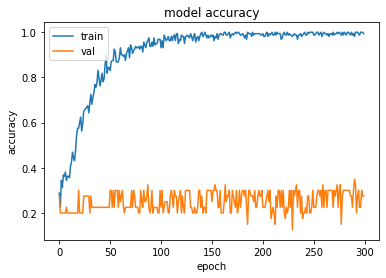

In [20]:
history = fittedModel

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

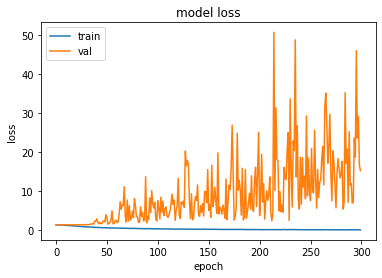

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [51]:
#@title Data extraction and processing
N_S = 3
# Load all trials for a sigle subject
X, Y = Extract_data_from_subject(root_dir, N_S, datatype)

# Cut usefull time. i.e action interval
X = Select_time_window(X = X, t_start = t_start, t_end = t_end, fs = fs)

In [52]:
X, Y = Filter_by_condition(X, Y, "INNER")
y_labels = Y[:,1]

X = X[:,left_channels,:]

x_min = X.min(axis=(2), keepdims=True)
x_max = X.max(axis=(2), keepdims=True)

x_min.shape

X = (X - x_min)/(x_max-x_min)

In [21]:
best_channel_mask = [False, False,  True,  True, False, True, False, False, False, False, False,  True,
    False,  True, False, False, False, False, False, False, False, False,  True, False,
    False, False, False, False, False, False, False,  True, False, False, False, False,
    False,  True, False, False,  True, False,  True, False,  True,  True, False, False,
    False, False, False, False, False, False, False,  True, False, False, False, False,
    False,  True, False, False, False,  True, False, False, False, False,  True,  True,
    False, False,  True, False, False, False, False, False, False, False,  True, False,
    False,  True, False,  True, False, False,  True,  True, False, False, False, False,
    True,  True, False, False, False,  True, False, False,  True, False, False, False,
    False, False,  True, False, False, False,  True, False,  True, False, False, False,
    False, False, False,  True, False,  True, False, False,]

X = X[:,best_channel_mask,:]

In [53]:
kf = KFold(n_splits=4, shuffle=True)
kf.get_n_splits(X)
accuracies = []

kernLength = 128
f1 = 8
f2 = 16
d = 2
dr = 0.5

kernels, chans, samples = 1, X.shape[1], X.shape[2]

strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of devices: 2


In [30]:
kernLength = 20
f1 = 28
f2 = 10
d = 128
dr = 0.5

In [19]:
left_channels = np.array([0,
                        1,
                        3,
                        4,
                        7,
                        8,
                        9,
                        14,
                        18,
                        19,
                        21,
                        22,
                        23,
                        81,
                        83,
                        90,
                        94,
                        95,
                        100,
                        101,
                        105,
                        110,
                        114,
                        116,
                        121,
                        125
                        ])
best_channel_mask = [False, False,  True,  True, False, True, False, False, False, False, False,  True,
    False,  True, False, False, False, False, False, False, False, False,  True, False,
    False, False, False, False, False, False, False,  True, False, False, False, False,
    False,  True, False, False,  True, False,  True, False,  True,  True, False, False,
    False, False, False, False, False, False, False,  True, False, False, False, False,
    False,  True, False, False, False,  True, False, False, False, False,  True,  True,
    False, False,  True, False, False, False, False, False, False, False,  True, False,
    False,  True, False,  True, False, False,  True,  True, False, False, False, False,
    True,  True, False, False, False,  True, False, False,  True, False, False, False,
    False, False,  True, False, False, False,  True, False,  True, False, False, False,
    False, False, False,  True, False,  True, False, False,]

In [54]:
accuracies = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = y_labels[train_index], y_labels[test_index]
    # convert labels to one-hot encodings.
    Y_train      = np_utils.to_categorical(Y_train)
    Y_test       = np_utils.to_categorical(Y_test)
    X_train      = X_train.reshape(X_train.shape[0], chans, samples, kernels)
    X_test       = X_test.reshape(X_test.shape[0], chans, samples, kernels)
    
    #X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.25, random_state=24)
    
    checkpointer = ModelCheckpoint(filepath='checkpoint.h5', verbose=1, monitor='val_accuracy',
                               save_best_only=True)
    
    #with strategy.scope():

#         model = EEGNet(nb_classes = 4, Chans = chans, Samples = samples,
#                    dropoutRate = dr, kernLength = kernLength, F1 = f1, D = d, F2 = f2, 
#                    dropoutType = 'Dropout')
#         model.compile(
#                 tf.keras.optimizers.Adam(
#                     # Specifies the range of values for the tuner to try
#                     name="Adam"),
#                 loss='categorical_crossentropy',
#                 metrics=['accuracy'])

    
#     fittedModel = model.fit(X_train, Y_train, batch_size = 32, epochs = 300, 
#                         verbose = 2,
#                         validation_data=(X_val, Y_val),
#                         callbacks=[checkpointer]
#                            )
    best_model = tf.keras.models.load_model('best_EEGNet_Left.h5')
    #best_model = tf.keras.models.load_model('best_EEGNet_S1.h5')
    probs       = best_model.predict(X_test)
    preds       = probs.argmax(axis = -1)  
    acc         = np.mean(preds == Y_test.argmax(axis=-1))
    accuracies.append(acc)

2/2 [==============================] - 0s 10ms/step


In [55]:
accuracies

[0.26666666666666666,
 0.2222222222222222,
 0.28888888888888886,
 0.35555555555555557]

In [56]:
sum(accuracies)/4

0.2833333333333333

In [16]:
y_labels

array([1, 1, 3, 3, 3, 0, 2, 3, 3, 1, 0, 1, 3, 3, 1, 2, 0, 2, 0, 3, 1, 0,
       1, 1, 3, 2, 2, 0, 1, 2, 2, 0, 1, 2, 3, 0, 2, 0, 0, 2, 3, 0, 2, 0,
       1, 1, 3, 0, 2, 3, 3, 0, 2, 1, 1, 1, 3, 1, 1, 2, 3, 1, 1, 0, 2, 3,
       3, 0, 2, 0, 2, 2, 0, 0, 0, 1, 2, 3, 3, 2, 1, 1, 2, 2, 3, 0, 0, 2,
       1, 1, 3, 1, 2, 0, 3, 0, 0, 0, 2, 1, 1, 1, 3, 2, 1, 2, 0, 1, 2, 3,
       2, 3, 3, 0, 3, 3, 2, 3, 0, 0, 1, 1, 3, 1, 0, 3, 2, 2, 0, 0, 0, 0,
       3, 0, 1, 2, 2, 2, 1, 2, 1, 2, 3, 3, 0, 3, 0, 0, 3, 1, 2, 1, 1, 0,
       3, 2, 3, 3, 1, 2, 2, 2, 1, 2, 0, 0, 1, 1, 3, 2, 1, 2, 0, 1, 3, 3,
       3, 3, 0, 0, 3, 0, 2, 1, 3, 3, 0, 1, 2, 2, 0, 0, 1, 3, 0, 3, 2, 1,
       2, 1])

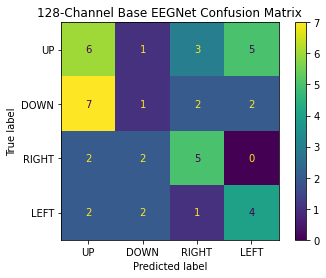

In [57]:
names = ['UP', 'DOWN', 'RIGHT', 'LEFT']
confusion_matrix = metrics.confusion_matrix(Y_test.argmax(axis = -1), preds)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels =names)
cm_display.plot()
plt.title('128-Channel Base EEGNet Confusion Matrix')
plt.show()

In [30]:
from sklearn.metrics import precision_recall_fscore_support
kernLength = 72
f1 = 24
f2 = 8
d = 116
dr = 0.5
av_accuracies = {1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0}
av_precisions = {1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0}
av_recalls = {1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0}
av_F1s = {1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0}

In [ ]:
for subject in range(1,9):
    # Load all trials for a sigle subject
    X, Y = Extract_data_from_subject(root_dir, subject, datatype)

    # Cut usefull time. i.e action interval
    X = Select_time_window(X = X, t_start = t_start, t_end = t_end, fs = fs)

    X, Y = Filter_by_condition(X, Y, "INNER")

    best_channel_mask = [False, False,  True,  True, False, True, False, False, False, False, False,  True,
        False,  True, False, False, False, False, False, False, False, False,  True, False,
        False, False, False, False, False, False, False,  True, False, False, False, False,
        False,  True, False, False,  True, False,  True, False,  True,  True, False, False,
        False, False, False, False, False, False, False,  True, False, False, False, False,
        False,  True, False, False, False,  True, False, False, False, False,  True,  True,
        False, False,  True, False, False, False, False, False, False, False,  True, False,
        False,  True, False,  True, False, False,  True,  True, False, False, False, False,
        True,  True, False, False, False,  True, False, False,  True, False, False, False,
        False, False,  True, False, False, False,  True, False,  True, False, False, False,
        False, False, False,  True, False,  True, False, False,]
    left_channels = np.array([0,
                        1,
                        3,
                        4,
                        7,
                        8,
                        9,
                        14,
                        18,
                        19,
                        21,
                        22,
                        23,
                        81,
                        83,
                        90,
                        94,
                        95,
                        100,
                        101,
                        105,
                        110,
                        114,
                        116,
                        121,
                        125
                        ])

    X = X[:,left_channels,:]

    x_min = X.min(axis=(2), keepdims=True)
    x_max = X.max(axis=(2), keepdims=True)

    x_min.shape

    X = (X - x_min)/(x_max-x_min)



    y_labels = Y[:,1]

    kf = KFold(n_splits=4, shuffle=True)
    kf.get_n_splits(X)
    accuracies = []

    kernels, chans, samples = 1, X.shape[1], X.shape[2]

    strategy = tf.distribute.MirroredStrategy()
    print('Number of devices: {}'.format(strategy.num_replicas_in_sync))


    accuracies = []
    precisions = []
    recalls = []
    F1s = []

    split = 0

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        Y_train, Y_test = y_labels[train_index], y_labels[test_index]
        # convert labels to one-hot encodings.
        Y_train      = np_utils.to_categorical(Y_train)
        Y_test       = np_utils.to_categorical(Y_test)
        X_train      = X_train.reshape(X_train.shape[0], chans, samples, kernels)
        X_test       = X_test.reshape(X_test.shape[0], chans, samples, kernels)
        
        X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.3, random_state=24)

        checkpointer = ModelCheckpoint(filepath='checkpoint1.h5', verbose=1, monitor='val_loss',
                                   save_best_only=True)

        with strategy.scope():

            model = EEGNet(nb_classes = 4, Chans = chans, Samples = samples,
                      dropoutRate = dr, kernLength = kernLength, F1 = f1, D = d, F2 = f2, 
                       dropoutType = 'Dropout')
            model.compile(
                    tf.keras.optimizers.Adam(
                        # Specifies the range of values for the tuner to try
                        name="Adam"),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])


        fittedModel = model.fit(X_train, Y_train, batch_size = 32, epochs = 300, 
                            verbose = 2,
                            validation_data=(X_val, Y_val),
                            callbacks=[checkpointer]
                               )
        best_model = tf.keras.models.load_model('checkpoint1.h5')
        
        probs       = best_model.predict(X_test)
        preds       = probs.argmax(axis = -1)  
        acc         = np.mean(preds == Y_test.argmax(axis=-1))
        accuracies.append(acc)

        precision, recall, F1, _ = precision_recall_fscore_support(Y_test.argmax(axis=-1), preds, average='macro')
        precisions.append(precision)
        recalls.append(recall)
        F1s.append(F1)
        
        with open(f'./last_try/subject{subject}_split{split}.txt', 'w+') as f:
            print('\ntrain index:\n', file=f)
            print(train_index, file=f)
            print('\ntest index:\n', file=f)
            print(test_index, file=f)
            # print('\nBest Params:\n', file=f)
            # print(tuner.get_best_hyperparameters(1)[0], file=f)
            print('\nAccuracy:\n', file=f)
            print(acc, file=f)
            print('\Precision:\n', file=f)
            print(precision, file=f)
            print('\Recall:\n', file=f)
            print(recall, file=f)
            print('\F1:\n', file=f)
            print(F1, file=f)
            print('Using Batch size of test', file=f)

        split += 1
    
    print('Lists')
    print(accuracies)
    print(precisions)
    print(recalls)
    print(F1s)

    av_accuracies[subject] = sum(accuracies)/4
    av_precisions[subject] = sum(precisions)/4
    av_recalls[subject] = sum(recalls)/4
    av_F1s[subject] = sum(F1s)/4

    print("dicts")
    print(av_accuracies)
    print(av_precisions)
    print(av_recalls)
    print(av_F1s)
# -

with open('./last_try/output_FINAL_RESULTS.txt', 'w+') as f:
    print('\naccuracies:\n', file=f)
    print(av_accuracies, file=f)
    print('\nprecisions:\n', file=f)
    print(av_precisions, file=f)
    print('\nrecalls:\n', file=f)
    print(av_recalls, file=f)
    print('\nF1s:\n', file=f)
    print(av_F1s, file=f)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of devices: 2
Epoch 1/300


2022-11-11 09:07:24.920123: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_8285312"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\025FlatMapDataset:544516"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT


Epoch 1: val_loss improved from inf to 1.38633, saving model to checkpoint1.h5
4/4 - 6s - loss: 1.5370 - accuracy: 0.2381 - val_loss: 1.3863 - val_accuracy: 0.1778 - 6s/epoch - 1s/step
Epoch 2/300

Epoch 2: val_loss did not improve from 1.38633
4/4 - 0s - loss: 1.3401 - accuracy: 0.3714 - val_loss: 1.3867 - val_accuracy: 0.1778 - 305ms/epoch - 76ms/step
Epoch 3/300

Epoch 3: val_loss did not improve from 1.38633
4/4 - 0s - loss: 1.2877 - accuracy: 0.4476 - val_loss: 1.3870 - val_accuracy: 0.1778 - 301ms/epoch - 75ms/step
Epoch 4/300

Epoch 4: val_loss did not improve from 1.38633
4/4 - 0s - loss: 1.2414 - accuracy: 0.4952 - val_loss: 1.3873 - val_accuracy: 0.1778 - 294ms/epoch - 74ms/step
Epoch 5/300

Epoch 5: val_loss did not improve from 1.38633
4/4 - 0s - loss: 1.2012 - accuracy: 0.5524 - val_loss: 1.3874 - val_accuracy: 0.2000 - 304ms/epoch - 76ms/step
Epoch 6/300

Epoch 6: val_loss did not improve from 1.38633
4/4 - 0s - loss: 1.1992 - accuracy: 0.5619 - val_loss: 1.3875 - val_ac

Epoch 48/300

Epoch 48: val_loss did not improve from 1.37948
4/4 - 0s - loss: 0.7494 - accuracy: 0.8095 - val_loss: 1.3920 - val_accuracy: 0.2889 - 297ms/epoch - 74ms/step
Epoch 49/300

Epoch 49: val_loss did not improve from 1.37948
4/4 - 0s - loss: 0.6950 - accuracy: 0.8571 - val_loss: 1.3980 - val_accuracy: 0.2222 - 297ms/epoch - 74ms/step
Epoch 50/300

Epoch 50: val_loss did not improve from 1.37948
4/4 - 0s - loss: 0.6979 - accuracy: 0.8857 - val_loss: 1.3966 - val_accuracy: 0.3111 - 304ms/epoch - 76ms/step
Epoch 51/300

Epoch 51: val_loss did not improve from 1.37948
4/4 - 0s - loss: 0.7005 - accuracy: 0.8667 - val_loss: 1.3917 - val_accuracy: 0.2889 - 293ms/epoch - 73ms/step
Epoch 52/300

Epoch 52: val_loss did not improve from 1.37948
4/4 - 0s - loss: 0.7001 - accuracy: 0.8381 - val_loss: 1.4037 - val_accuracy: 0.2667 - 300ms/epoch - 75ms/step
Epoch 53/300

Epoch 53: val_loss did not improve from 1.37948
4/4 - 0s - loss: 0.6941 - accuracy: 0.9048 - val_loss: 1.3849 - val_accur

4/4 - 0s - loss: 0.4071 - accuracy: 0.9905 - val_loss: 1.5145 - val_accuracy: 0.2222 - 302ms/epoch - 75ms/step
Epoch 96/300

Epoch 96: val_loss did not improve from 1.37948
4/4 - 0s - loss: 0.4257 - accuracy: 0.9810 - val_loss: 1.5816 - val_accuracy: 0.2222 - 298ms/epoch - 74ms/step
Epoch 97/300

Epoch 97: val_loss did not improve from 1.37948
4/4 - 0s - loss: 0.3993 - accuracy: 0.9905 - val_loss: 1.5119 - val_accuracy: 0.2667 - 291ms/epoch - 73ms/step
Epoch 98/300

Epoch 98: val_loss did not improve from 1.37948
4/4 - 0s - loss: 0.4238 - accuracy: 0.9810 - val_loss: 1.6158 - val_accuracy: 0.2444 - 305ms/epoch - 76ms/step
Epoch 99/300

Epoch 99: val_loss did not improve from 1.37948
4/4 - 0s - loss: 0.3713 - accuracy: 0.9905 - val_loss: 1.5458 - val_accuracy: 0.2444 - 293ms/epoch - 73ms/step
Epoch 100/300

Epoch 100: val_loss did not improve from 1.37948
4/4 - 0s - loss: 0.3922 - accuracy: 0.9714 - val_loss: 1.5244 - val_accuracy: 0.2444 - 311ms/epoch - 78ms/step
Epoch 101/300

Epoch 1

4/4 - 0s - loss: 0.2347 - accuracy: 1.0000 - val_loss: 2.0352 - val_accuracy: 0.2000 - 314ms/epoch - 79ms/step
Epoch 143/300

Epoch 143: val_loss did not improve from 1.37948
4/4 - 0s - loss: 0.2634 - accuracy: 1.0000 - val_loss: 1.7201 - val_accuracy: 0.2444 - 304ms/epoch - 76ms/step
Epoch 144/300

Epoch 144: val_loss did not improve from 1.37948
4/4 - 0s - loss: 0.2292 - accuracy: 0.9905 - val_loss: 1.8290 - val_accuracy: 0.3111 - 322ms/epoch - 81ms/step
Epoch 145/300

Epoch 145: val_loss did not improve from 1.37948
4/4 - 0s - loss: 0.2501 - accuracy: 1.0000 - val_loss: 1.6648 - val_accuracy: 0.3111 - 328ms/epoch - 82ms/step
Epoch 146/300

Epoch 146: val_loss did not improve from 1.37948
4/4 - 0s - loss: 0.2454 - accuracy: 1.0000 - val_loss: 1.7897 - val_accuracy: 0.2667 - 307ms/epoch - 77ms/step
Epoch 147/300

Epoch 147: val_loss did not improve from 1.37948
4/4 - 0s - loss: 0.2692 - accuracy: 0.9905 - val_loss: 1.8243 - val_accuracy: 0.2444 - 318ms/epoch - 79ms/step
Epoch 148/300


4/4 - 0s - loss: 0.1648 - accuracy: 1.0000 - val_loss: 2.0962 - val_accuracy: 0.1778 - 308ms/epoch - 77ms/step
Epoch 190/300

Epoch 190: val_loss did not improve from 1.37948
4/4 - 0s - loss: 0.1631 - accuracy: 1.0000 - val_loss: 1.7535 - val_accuracy: 0.2889 - 307ms/epoch - 77ms/step
Epoch 191/300

Epoch 191: val_loss did not improve from 1.37948
4/4 - 0s - loss: 0.1679 - accuracy: 1.0000 - val_loss: 1.9255 - val_accuracy: 0.3333 - 310ms/epoch - 78ms/step
Epoch 192/300

Epoch 192: val_loss did not improve from 1.37948
4/4 - 0s - loss: 0.1581 - accuracy: 1.0000 - val_loss: 2.0890 - val_accuracy: 0.2889 - 313ms/epoch - 78ms/step
Epoch 193/300

Epoch 193: val_loss did not improve from 1.37948
4/4 - 0s - loss: 0.1408 - accuracy: 1.0000 - val_loss: 2.0353 - val_accuracy: 0.2667 - 303ms/epoch - 76ms/step
Epoch 194/300

Epoch 194: val_loss did not improve from 1.37948
4/4 - 0s - loss: 0.1601 - accuracy: 1.0000 - val_loss: 1.9073 - val_accuracy: 0.3111 - 303ms/epoch - 76ms/step
Epoch 195/300


4/4 - 0s - loss: 0.1347 - accuracy: 1.0000 - val_loss: 2.0879 - val_accuracy: 0.2667 - 304ms/epoch - 76ms/step
Epoch 237/300

Epoch 237: val_loss did not improve from 1.37948
4/4 - 0s - loss: 0.1197 - accuracy: 1.0000 - val_loss: 2.0158 - val_accuracy: 0.2444 - 317ms/epoch - 79ms/step
Epoch 238/300

Epoch 238: val_loss did not improve from 1.37948
4/4 - 0s - loss: 0.1156 - accuracy: 1.0000 - val_loss: 1.8949 - val_accuracy: 0.3111 - 308ms/epoch - 77ms/step
Epoch 239/300

Epoch 239: val_loss did not improve from 1.37948
4/4 - 0s - loss: 0.1178 - accuracy: 1.0000 - val_loss: 1.8532 - val_accuracy: 0.3111 - 312ms/epoch - 78ms/step
Epoch 240/300

Epoch 240: val_loss did not improve from 1.37948
4/4 - 0s - loss: 0.1091 - accuracy: 1.0000 - val_loss: 1.9003 - val_accuracy: 0.2889 - 310ms/epoch - 78ms/step
Epoch 241/300

Epoch 241: val_loss did not improve from 1.37948
4/4 - 0s - loss: 0.1073 - accuracy: 1.0000 - val_loss: 2.0015 - val_accuracy: 0.2000 - 319ms/epoch - 80ms/step
Epoch 242/300


4/4 - 0s - loss: 0.0947 - accuracy: 1.0000 - val_loss: 2.1562 - val_accuracy: 0.2222 - 306ms/epoch - 77ms/step
Epoch 284/300

Epoch 284: val_loss did not improve from 1.37948
4/4 - 0s - loss: 0.0934 - accuracy: 1.0000 - val_loss: 1.9745 - val_accuracy: 0.2444 - 291ms/epoch - 73ms/step
Epoch 285/300

Epoch 285: val_loss did not improve from 1.37948
4/4 - 0s - loss: 0.0809 - accuracy: 1.0000 - val_loss: 2.1109 - val_accuracy: 0.1778 - 300ms/epoch - 75ms/step
Epoch 286/300

Epoch 286: val_loss did not improve from 1.37948
4/4 - 0s - loss: 0.0914 - accuracy: 1.0000 - val_loss: 2.2975 - val_accuracy: 0.1556 - 305ms/epoch - 76ms/step
Epoch 287/300

Epoch 287: val_loss did not improve from 1.37948
4/4 - 0s - loss: 0.0830 - accuracy: 1.0000 - val_loss: 2.1078 - val_accuracy: 0.2222 - 307ms/epoch - 77ms/step
Epoch 288/300

Epoch 288: val_loss did not improve from 1.37948
4/4 - 0s - loss: 0.0869 - accuracy: 1.0000 - val_loss: 2.0461 - val_accuracy: 0.2444 - 305ms/epoch - 76ms/step
Epoch 289/300


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2022-11-11 09:09:05.976276: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_8349944"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\025FlatMapDataset:548770"
  }
}
attr {

Epoch 1/300


2022-11-11 09:09:09.921175: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_8353014"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\025FlatMapDataset:548812"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT


Epoch 1: val_loss improved from inf to 1.38648, saving model to checkpoint1.h5
4/4 - 5s - loss: 1.4732 - accuracy: 0.2286 - val_loss: 1.3865 - val_accuracy: 0.2000 - 5s/epoch - 1s/step
Epoch 2/300

Epoch 2: val_loss did not improve from 1.38648
4/4 - 0s - loss: 1.3328 - accuracy: 0.4095 - val_loss: 1.3867 - val_accuracy: 0.2000 - 309ms/epoch - 77ms/step
Epoch 3/300

Epoch 3: val_loss did not improve from 1.38648
4/4 - 0s - loss: 1.2820 - accuracy: 0.3810 - val_loss: 1.3868 - val_accuracy: 0.2000 - 298ms/epoch - 74ms/step
Epoch 4/300

Epoch 4: val_loss did not improve from 1.38648
4/4 - 0s - loss: 1.2874 - accuracy: 0.4381 - val_loss: 1.3870 - val_accuracy: 0.2000 - 295ms/epoch - 74ms/step
Epoch 5/300

Epoch 5: val_loss did not improve from 1.38648
4/4 - 0s - loss: 1.2534 - accuracy: 0.4571 - val_loss: 1.3870 - val_accuracy: 0.2000 - 296ms/epoch - 74ms/step
Epoch 6/300

Epoch 6: val_loss did not improve from 1.38648
4/4 - 0s - loss: 1.1990 - accuracy: 0.5524 - val_loss: 1.3871 - val_ac

Epoch 48/300

Epoch 48: val_loss did not improve from 1.38552
4/4 - 0s - loss: 0.7101 - accuracy: 0.9143 - val_loss: 1.3869 - val_accuracy: 0.2667 - 296ms/epoch - 74ms/step
Epoch 49/300

Epoch 49: val_loss did not improve from 1.38552
4/4 - 0s - loss: 0.6816 - accuracy: 0.9048 - val_loss: 1.3882 - val_accuracy: 0.2667 - 305ms/epoch - 76ms/step
Epoch 50/300

Epoch 50: val_loss did not improve from 1.38552
4/4 - 0s - loss: 0.6632 - accuracy: 0.9333 - val_loss: 1.3935 - val_accuracy: 0.2667 - 314ms/epoch - 78ms/step
Epoch 51/300

Epoch 51: val_loss did not improve from 1.38552
4/4 - 0s - loss: 0.6630 - accuracy: 0.9238 - val_loss: 1.3981 - val_accuracy: 0.1778 - 320ms/epoch - 80ms/step
Epoch 52/300

Epoch 52: val_loss improved from 1.38552 to 1.38340, saving model to checkpoint1.h5
4/4 - 0s - loss: 0.6882 - accuracy: 0.9238 - val_loss: 1.3834 - val_accuracy: 0.2667 - 371ms/epoch - 93ms/step
Epoch 53/300

Epoch 53: val_loss did not improve from 1.38340
4/4 - 0s - loss: 0.6546 - accuracy: 0

Epoch 94/300

Epoch 94: val_loss did not improve from 1.34774
4/4 - 0s - loss: 0.3672 - accuracy: 0.9810 - val_loss: 1.3919 - val_accuracy: 0.2889 - 301ms/epoch - 75ms/step
Epoch 95/300

Epoch 95: val_loss did not improve from 1.34774
4/4 - 0s - loss: 0.3898 - accuracy: 0.9905 - val_loss: 1.4146 - val_accuracy: 0.2222 - 309ms/epoch - 77ms/step
Epoch 96/300

Epoch 96: val_loss did not improve from 1.34774
4/4 - 0s - loss: 0.3764 - accuracy: 1.0000 - val_loss: 1.3743 - val_accuracy: 0.2444 - 308ms/epoch - 77ms/step
Epoch 97/300

Epoch 97: val_loss did not improve from 1.34774
4/4 - 0s - loss: 0.3703 - accuracy: 0.9810 - val_loss: 1.3676 - val_accuracy: 0.3333 - 295ms/epoch - 74ms/step
Epoch 98/300

Epoch 98: val_loss did not improve from 1.34774
4/4 - 0s - loss: 0.3512 - accuracy: 1.0000 - val_loss: 1.4189 - val_accuracy: 0.2222 - 300ms/epoch - 75ms/step
Epoch 99/300

Epoch 99: val_loss did not improve from 1.34774
4/4 - 0s - loss: 0.3755 - accuracy: 0.9905 - val_loss: 1.3665 - val_accur

Epoch 141/300

Epoch 141: val_loss did not improve from 1.34774
4/4 - 0s - loss: 0.2351 - accuracy: 0.9905 - val_loss: 1.3814 - val_accuracy: 0.4000 - 298ms/epoch - 74ms/step
Epoch 142/300

Epoch 142: val_loss did not improve from 1.34774
4/4 - 0s - loss: 0.2143 - accuracy: 1.0000 - val_loss: 1.4334 - val_accuracy: 0.4000 - 311ms/epoch - 78ms/step
Epoch 143/300

Epoch 143: val_loss did not improve from 1.34774
4/4 - 0s - loss: 0.2292 - accuracy: 0.9810 - val_loss: 1.3942 - val_accuracy: 0.4444 - 296ms/epoch - 74ms/step
Epoch 144/300

Epoch 144: val_loss did not improve from 1.34774
4/4 - 0s - loss: 0.2189 - accuracy: 0.9905 - val_loss: 1.3778 - val_accuracy: 0.4444 - 302ms/epoch - 75ms/step
Epoch 145/300

Epoch 145: val_loss did not improve from 1.34774
4/4 - 0s - loss: 0.2126 - accuracy: 1.0000 - val_loss: 1.3915 - val_accuracy: 0.3778 - 293ms/epoch - 73ms/step
Epoch 146/300

Epoch 146: val_loss did not improve from 1.34774
4/4 - 0s - loss: 0.2101 - accuracy: 1.0000 - val_loss: 1.4459

Epoch 188/300

Epoch 188: val_loss did not improve from 1.34774
4/4 - 0s - loss: 0.1940 - accuracy: 0.9810 - val_loss: 1.4487 - val_accuracy: 0.4000 - 293ms/epoch - 73ms/step
Epoch 189/300

Epoch 189: val_loss did not improve from 1.34774
4/4 - 0s - loss: 0.1650 - accuracy: 1.0000 - val_loss: 1.4838 - val_accuracy: 0.3333 - 290ms/epoch - 72ms/step
Epoch 190/300

Epoch 190: val_loss did not improve from 1.34774
4/4 - 0s - loss: 0.1481 - accuracy: 0.9905 - val_loss: 1.6348 - val_accuracy: 0.4222 - 291ms/epoch - 73ms/step
Epoch 191/300

Epoch 191: val_loss did not improve from 1.34774
4/4 - 0s - loss: 0.2108 - accuracy: 1.0000 - val_loss: 1.7784 - val_accuracy: 0.2667 - 311ms/epoch - 78ms/step
Epoch 192/300

Epoch 192: val_loss did not improve from 1.34774
4/4 - 0s - loss: 0.1836 - accuracy: 1.0000 - val_loss: 1.5502 - val_accuracy: 0.3333 - 294ms/epoch - 73ms/step
Epoch 193/300

Epoch 193: val_loss did not improve from 1.34774
4/4 - 0s - loss: 0.1724 - accuracy: 0.9905 - val_loss: 1.5994

Epoch 235/300

Epoch 235: val_loss did not improve from 1.34774
4/4 - 0s - loss: 0.1043 - accuracy: 1.0000 - val_loss: 1.5106 - val_accuracy: 0.4444 - 306ms/epoch - 76ms/step
Epoch 236/300

Epoch 236: val_loss did not improve from 1.34774
4/4 - 0s - loss: 0.1144 - accuracy: 1.0000 - val_loss: 1.5471 - val_accuracy: 0.3556 - 308ms/epoch - 77ms/step
Epoch 237/300

Epoch 237: val_loss did not improve from 1.34774
4/4 - 0s - loss: 0.1157 - accuracy: 1.0000 - val_loss: 1.5882 - val_accuracy: 0.3333 - 293ms/epoch - 73ms/step
Epoch 238/300

Epoch 238: val_loss did not improve from 1.34774
4/4 - 0s - loss: 0.1083 - accuracy: 1.0000 - val_loss: 1.6249 - val_accuracy: 0.2889 - 293ms/epoch - 73ms/step
Epoch 239/300

Epoch 239: val_loss did not improve from 1.34774
4/4 - 1s - loss: 0.1087 - accuracy: 1.0000 - val_loss: 1.5732 - val_accuracy: 0.3111 - 645ms/epoch - 161ms/step
Epoch 240/300

Epoch 240: val_loss did not improve from 1.34774
4/4 - 0s - loss: 0.1120 - accuracy: 1.0000 - val_loss: 1.569

Epoch 282/300

Epoch 282: val_loss did not improve from 1.34774
4/4 - 0s - loss: 0.0940 - accuracy: 1.0000 - val_loss: 1.5768 - val_accuracy: 0.3778 - 308ms/epoch - 77ms/step
Epoch 283/300

Epoch 283: val_loss did not improve from 1.34774
4/4 - 0s - loss: 0.0842 - accuracy: 1.0000 - val_loss: 1.5519 - val_accuracy: 0.3333 - 301ms/epoch - 75ms/step
Epoch 284/300

Epoch 284: val_loss did not improve from 1.34774
4/4 - 0s - loss: 0.0826 - accuracy: 1.0000 - val_loss: 1.5201 - val_accuracy: 0.3556 - 323ms/epoch - 81ms/step
Epoch 285/300

Epoch 285: val_loss did not improve from 1.34774
4/4 - 0s - loss: 0.0876 - accuracy: 1.0000 - val_loss: 1.5207 - val_accuracy: 0.3778 - 310ms/epoch - 77ms/step
Epoch 286/300

Epoch 286: val_loss did not improve from 1.34774
4/4 - 0s - loss: 0.1066 - accuracy: 0.9905 - val_loss: 1.5982 - val_accuracy: 0.2889 - 303ms/epoch - 76ms/step
Epoch 287/300

Epoch 287: val_loss did not improve from 1.34774
4/4 - 0s - loss: 0.1059 - accuracy: 1.0000 - val_loss: 1.6656

2022-11-11 09:10:45.915369: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_8415872"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\025FlatMapDataset:553024"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT


Epoch 1: val_loss improved from inf to 1.38747, saving model to checkpoint1.h5
4/4 - 5s - loss: 1.4531 - accuracy: 0.3143 - val_loss: 1.3875 - val_accuracy: 0.2000 - 5s/epoch - 1s/step
Epoch 2/300

Epoch 2: val_loss did not improve from 1.38747
4/4 - 0s - loss: 1.3436 - accuracy: 0.3905 - val_loss: 1.3880 - val_accuracy: 0.2000 - 312ms/epoch - 78ms/step
Epoch 3/300

Epoch 3: val_loss did not improve from 1.38747
4/4 - 0s - loss: 1.3244 - accuracy: 0.3810 - val_loss: 1.3883 - val_accuracy: 0.2000 - 303ms/epoch - 76ms/step
Epoch 4/300

Epoch 4: val_loss did not improve from 1.38747
4/4 - 0s - loss: 1.2764 - accuracy: 0.5143 - val_loss: 1.3883 - val_accuracy: 0.2000 - 311ms/epoch - 78ms/step
Epoch 5/300

Epoch 5: val_loss did not improve from 1.38747
4/4 - 0s - loss: 1.2560 - accuracy: 0.4190 - val_loss: 1.3881 - val_accuracy: 0.2000 - 298ms/epoch - 74ms/step
Epoch 6/300

Epoch 6: val_loss did not improve from 1.38747
4/4 - 0s - loss: 1.2276 - accuracy: 0.4762 - val_loss: 1.3879 - val_ac

Epoch 48/300

Epoch 48: val_loss did not improve from 1.38414
4/4 - 0s - loss: 0.7205 - accuracy: 0.9238 - val_loss: 1.3861 - val_accuracy: 0.2222 - 310ms/epoch - 77ms/step
Epoch 49/300

Epoch 49: val_loss improved from 1.38414 to 1.37621, saving model to checkpoint1.h5
4/4 - 0s - loss: 0.7108 - accuracy: 0.9048 - val_loss: 1.3762 - val_accuracy: 0.3333 - 351ms/epoch - 88ms/step
Epoch 50/300

Epoch 50: val_loss did not improve from 1.37621
4/4 - 0s - loss: 0.7068 - accuracy: 0.9048 - val_loss: 1.3809 - val_accuracy: 0.1556 - 310ms/epoch - 77ms/step
Epoch 51/300

Epoch 51: val_loss did not improve from 1.37621
4/4 - 0s - loss: 0.6710 - accuracy: 0.9524 - val_loss: 1.3850 - val_accuracy: 0.1556 - 301ms/epoch - 75ms/step
Epoch 52/300

Epoch 52: val_loss did not improve from 1.37621
4/4 - 0s - loss: 0.6943 - accuracy: 0.9333 - val_loss: 1.3778 - val_accuracy: 0.2667 - 296ms/epoch - 74ms/step
Epoch 53/300

Epoch 53: val_loss did not improve from 1.37621
4/4 - 0s - loss: 0.6388 - accuracy: 0

Epoch 95/300

Epoch 95: val_loss did not improve from 1.34290
4/4 - 0s - loss: 0.3723 - accuracy: 0.9905 - val_loss: 1.4697 - val_accuracy: 0.2444 - 296ms/epoch - 74ms/step
Epoch 96/300

Epoch 96: val_loss did not improve from 1.34290
4/4 - 0s - loss: 0.3608 - accuracy: 1.0000 - val_loss: 1.5338 - val_accuracy: 0.2222 - 316ms/epoch - 79ms/step
Epoch 97/300

Epoch 97: val_loss did not improve from 1.34290
4/4 - 0s - loss: 0.4070 - accuracy: 0.9905 - val_loss: 1.4827 - val_accuracy: 0.2000 - 311ms/epoch - 78ms/step
Epoch 98/300

Epoch 98: val_loss did not improve from 1.34290
4/4 - 0s - loss: 0.3359 - accuracy: 0.9905 - val_loss: 1.4676 - val_accuracy: 0.2222 - 293ms/epoch - 73ms/step
Epoch 99/300

Epoch 99: val_loss did not improve from 1.34290
4/4 - 0s - loss: 0.3265 - accuracy: 1.0000 - val_loss: 1.4926 - val_accuracy: 0.2000 - 298ms/epoch - 75ms/step
Epoch 100/300

Epoch 100: val_loss did not improve from 1.34290
4/4 - 0s - loss: 0.3047 - accuracy: 1.0000 - val_loss: 1.5023 - val_acc

Epoch 142/300

Epoch 142: val_loss did not improve from 1.34290
4/4 - 0s - loss: 0.1832 - accuracy: 1.0000 - val_loss: 1.5968 - val_accuracy: 0.3333 - 300ms/epoch - 75ms/step
Epoch 143/300

Epoch 143: val_loss did not improve from 1.34290
4/4 - 0s - loss: 0.1883 - accuracy: 1.0000 - val_loss: 1.6141 - val_accuracy: 0.2889 - 307ms/epoch - 77ms/step
Epoch 144/300

Epoch 144: val_loss did not improve from 1.34290
4/4 - 0s - loss: 0.2161 - accuracy: 0.9905 - val_loss: 1.6159 - val_accuracy: 0.2667 - 303ms/epoch - 76ms/step
Epoch 145/300

Epoch 145: val_loss did not improve from 1.34290
4/4 - 0s - loss: 0.2394 - accuracy: 1.0000 - val_loss: 1.5913 - val_accuracy: 0.3111 - 309ms/epoch - 77ms/step
Epoch 146/300

Epoch 146: val_loss did not improve from 1.34290
4/4 - 0s - loss: 0.2216 - accuracy: 0.9905 - val_loss: 1.6688 - val_accuracy: 0.2667 - 302ms/epoch - 75ms/step
Epoch 147/300

Epoch 147: val_loss did not improve from 1.34290
4/4 - 0s - loss: 0.1952 - accuracy: 1.0000 - val_loss: 1.7048

Epoch 189/300

Epoch 189: val_loss did not improve from 1.34290
4/4 - 0s - loss: 0.1232 - accuracy: 1.0000 - val_loss: 1.7952 - val_accuracy: 0.3111 - 295ms/epoch - 74ms/step
Epoch 190/300

Epoch 190: val_loss did not improve from 1.34290
4/4 - 0s - loss: 0.1265 - accuracy: 1.0000 - val_loss: 1.8225 - val_accuracy: 0.2889 - 306ms/epoch - 76ms/step
Epoch 191/300

Epoch 191: val_loss did not improve from 1.34290
4/4 - 0s - loss: 0.1281 - accuracy: 1.0000 - val_loss: 1.9066 - val_accuracy: 0.2000 - 303ms/epoch - 76ms/step
Epoch 192/300

Epoch 192: val_loss did not improve from 1.34290
4/4 - 0s - loss: 0.1201 - accuracy: 1.0000 - val_loss: 2.0154 - val_accuracy: 0.1778 - 294ms/epoch - 73ms/step
Epoch 193/300

Epoch 193: val_loss did not improve from 1.34290
4/4 - 0s - loss: 0.1525 - accuracy: 0.9905 - val_loss: 1.8987 - val_accuracy: 0.2000 - 303ms/epoch - 76ms/step
Epoch 194/300

Epoch 194: val_loss did not improve from 1.34290
4/4 - 0s - loss: 0.1335 - accuracy: 1.0000 - val_loss: 1.8217

Epoch 236/300

Epoch 236: val_loss did not improve from 1.34290
4/4 - 0s - loss: 0.1063 - accuracy: 1.0000 - val_loss: 1.8117 - val_accuracy: 0.2222 - 303ms/epoch - 76ms/step
Epoch 237/300

Epoch 237: val_loss did not improve from 1.34290
4/4 - 0s - loss: 0.0858 - accuracy: 1.0000 - val_loss: 1.8139 - val_accuracy: 0.2667 - 291ms/epoch - 73ms/step
Epoch 238/300

Epoch 238: val_loss did not improve from 1.34290
4/4 - 0s - loss: 0.0926 - accuracy: 1.0000 - val_loss: 1.8634 - val_accuracy: 0.2889 - 307ms/epoch - 77ms/step
Epoch 239/300

Epoch 239: val_loss did not improve from 1.34290
4/4 - 0s - loss: 0.0889 - accuracy: 1.0000 - val_loss: 1.8560 - val_accuracy: 0.2667 - 306ms/epoch - 77ms/step
Epoch 240/300

Epoch 240: val_loss did not improve from 1.34290
4/4 - 0s - loss: 0.0938 - accuracy: 1.0000 - val_loss: 1.7978 - val_accuracy: 0.2444 - 318ms/epoch - 79ms/step
Epoch 241/300

Epoch 241: val_loss did not improve from 1.34290
4/4 - 0s - loss: 0.0921 - accuracy: 1.0000 - val_loss: 1.8630

Epoch 283/300

Epoch 283: val_loss did not improve from 1.34290
4/4 - 0s - loss: 0.0825 - accuracy: 1.0000 - val_loss: 1.8438 - val_accuracy: 0.1333 - 321ms/epoch - 80ms/step
Epoch 284/300

Epoch 284: val_loss did not improve from 1.34290
4/4 - 0s - loss: 0.0966 - accuracy: 1.0000 - val_loss: 1.8745 - val_accuracy: 0.1778 - 307ms/epoch - 77ms/step
Epoch 285/300

Epoch 285: val_loss did not improve from 1.34290
4/4 - 0s - loss: 0.0952 - accuracy: 1.0000 - val_loss: 1.9848 - val_accuracy: 0.2222 - 318ms/epoch - 79ms/step
Epoch 286/300

Epoch 286: val_loss did not improve from 1.34290
4/4 - 0s - loss: 0.0891 - accuracy: 1.0000 - val_loss: 1.9281 - val_accuracy: 0.1778 - 311ms/epoch - 78ms/step
Epoch 287/300

Epoch 287: val_loss did not improve from 1.34290
4/4 - 0s - loss: 0.0946 - accuracy: 1.0000 - val_loss: 1.9415 - val_accuracy: 0.1778 - 311ms/epoch - 78ms/step
Epoch 288/300

Epoch 288: val_loss did not improve from 1.34290
4/4 - 0s - loss: 0.0821 - accuracy: 1.0000 - val_loss: 1.9486

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2022-11-11 09:12:26.238283: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_8481314"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\025FlatMapDataset:557278"
  }
}
attr {

Epoch 1/300


2022-11-11 09:12:30.206373: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_8484384"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\025FlatMapDataset:557320"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT


Epoch 1: val_loss improved from inf to 1.38613, saving model to checkpoint1.h5
4/4 - 5s - loss: 1.4655 - accuracy: 0.1905 - val_loss: 1.3861 - val_accuracy: 0.2667 - 5s/epoch - 1s/step
Epoch 2/300

Epoch 2: val_loss improved from 1.38613 to 1.38612, saving model to checkpoint1.h5
4/4 - 0s - loss: 1.3220 - accuracy: 0.3905 - val_loss: 1.3861 - val_accuracy: 0.2667 - 358ms/epoch - 90ms/step
Epoch 3/300

Epoch 3: val_loss did not improve from 1.38612
4/4 - 0s - loss: 1.2877 - accuracy: 0.4000 - val_loss: 1.3864 - val_accuracy: 0.2444 - 294ms/epoch - 73ms/step
Epoch 4/300

Epoch 4: val_loss did not improve from 1.38612
4/4 - 0s - loss: 1.2378 - accuracy: 0.4762 - val_loss: 1.3865 - val_accuracy: 0.1778 - 313ms/epoch - 78ms/step
Epoch 5/300

Epoch 5: val_loss did not improve from 1.38612
4/4 - 0s - loss: 1.2265 - accuracy: 0.5048 - val_loss: 1.3865 - val_accuracy: 0.1778 - 307ms/epoch - 77ms/step
Epoch 6/300

Epoch 6: val_loss did not improve from 1.38612
4/4 - 0s - loss: 1.1917 - accuracy

4/4 - 0s - loss: 0.6794 - accuracy: 0.9333 - val_loss: 1.4038 - val_accuracy: 0.1556 - 293ms/epoch - 73ms/step
Epoch 49/300

Epoch 49: val_loss did not improve from 1.38612
4/4 - 0s - loss: 0.7038 - accuracy: 0.9524 - val_loss: 1.4048 - val_accuracy: 0.1556 - 306ms/epoch - 77ms/step
Epoch 50/300

Epoch 50: val_loss did not improve from 1.38612
4/4 - 0s - loss: 0.6385 - accuracy: 0.9333 - val_loss: 1.3996 - val_accuracy: 0.1556 - 302ms/epoch - 76ms/step
Epoch 51/300

Epoch 51: val_loss did not improve from 1.38612
4/4 - 0s - loss: 0.6656 - accuracy: 0.9333 - val_loss: 1.4120 - val_accuracy: 0.1778 - 306ms/epoch - 77ms/step
Epoch 52/300

Epoch 52: val_loss did not improve from 1.38612
4/4 - 0s - loss: 0.6510 - accuracy: 0.9429 - val_loss: 1.4156 - val_accuracy: 0.1778 - 310ms/epoch - 78ms/step
Epoch 53/300

Epoch 53: val_loss did not improve from 1.38612
4/4 - 0s - loss: 0.6524 - accuracy: 0.9714 - val_loss: 1.4056 - val_accuracy: 0.1333 - 302ms/epoch - 76ms/step
Epoch 54/300

Epoch 54: 

Epoch 96/300

Epoch 96: val_loss did not improve from 1.38612
4/4 - 0s - loss: 0.3784 - accuracy: 1.0000 - val_loss: 1.4682 - val_accuracy: 0.2222 - 317ms/epoch - 79ms/step
Epoch 97/300

Epoch 97: val_loss did not improve from 1.38612
4/4 - 0s - loss: 0.3682 - accuracy: 1.0000 - val_loss: 1.4930 - val_accuracy: 0.1778 - 299ms/epoch - 75ms/step
Epoch 98/300

Epoch 98: val_loss did not improve from 1.38612
4/4 - 0s - loss: 0.3371 - accuracy: 0.9905 - val_loss: 1.4900 - val_accuracy: 0.2222 - 304ms/epoch - 76ms/step
Epoch 99/300

Epoch 99: val_loss did not improve from 1.38612
4/4 - 0s - loss: 0.3689 - accuracy: 0.9810 - val_loss: 1.4937 - val_accuracy: 0.1778 - 303ms/epoch - 76ms/step
Epoch 100/300

Epoch 100: val_loss did not improve from 1.38612
4/4 - 0s - loss: 0.3462 - accuracy: 1.0000 - val_loss: 1.4725 - val_accuracy: 0.1778 - 324ms/epoch - 81ms/step
Epoch 101/300

Epoch 101: val_loss did not improve from 1.38612
4/4 - 0s - loss: 0.3496 - accuracy: 0.9810 - val_loss: 1.4833 - val_a

Epoch 143/300

Epoch 143: val_loss did not improve from 1.38612
4/4 - 0s - loss: 0.2224 - accuracy: 1.0000 - val_loss: 1.6448 - val_accuracy: 0.2667 - 304ms/epoch - 76ms/step
Epoch 144/300

Epoch 144: val_loss did not improve from 1.38612
4/4 - 0s - loss: 0.2302 - accuracy: 1.0000 - val_loss: 1.5852 - val_accuracy: 0.2889 - 295ms/epoch - 74ms/step
Epoch 145/300

Epoch 145: val_loss did not improve from 1.38612
4/4 - 0s - loss: 0.2395 - accuracy: 1.0000 - val_loss: 1.5928 - val_accuracy: 0.2889 - 296ms/epoch - 74ms/step
Epoch 146/300

Epoch 146: val_loss did not improve from 1.38612
4/4 - 0s - loss: 0.2416 - accuracy: 1.0000 - val_loss: 1.5622 - val_accuracy: 0.2667 - 296ms/epoch - 74ms/step
Epoch 147/300

Epoch 147: val_loss did not improve from 1.38612
4/4 - 0s - loss: 0.2607 - accuracy: 1.0000 - val_loss: 1.7577 - val_accuracy: 0.2000 - 304ms/epoch - 76ms/step
Epoch 148/300

Epoch 148: val_loss did not improve from 1.38612
4/4 - 0s - loss: 0.2675 - accuracy: 1.0000 - val_loss: 1.5097

Epoch 190/300

Epoch 190: val_loss did not improve from 1.38612
4/4 - 0s - loss: 0.1818 - accuracy: 1.0000 - val_loss: 1.7840 - val_accuracy: 0.2889 - 324ms/epoch - 81ms/step
Epoch 191/300

Epoch 191: val_loss did not improve from 1.38612
4/4 - 0s - loss: 0.1625 - accuracy: 1.0000 - val_loss: 1.7416 - val_accuracy: 0.2667 - 315ms/epoch - 79ms/step
Epoch 192/300

Epoch 192: val_loss did not improve from 1.38612
4/4 - 0s - loss: 0.1787 - accuracy: 1.0000 - val_loss: 1.6865 - val_accuracy: 0.2000 - 297ms/epoch - 74ms/step
Epoch 193/300

Epoch 193: val_loss did not improve from 1.38612
4/4 - 0s - loss: 0.1508 - accuracy: 1.0000 - val_loss: 1.6743 - val_accuracy: 0.2444 - 294ms/epoch - 74ms/step
Epoch 194/300

Epoch 194: val_loss did not improve from 1.38612
4/4 - 0s - loss: 0.1753 - accuracy: 0.9905 - val_loss: 1.7135 - val_accuracy: 0.1778 - 298ms/epoch - 74ms/step
Epoch 195/300

Epoch 195: val_loss did not improve from 1.38612
4/4 - 0s - loss: 0.1747 - accuracy: 0.9905 - val_loss: 1.9120

Epoch 237/300

Epoch 237: val_loss did not improve from 1.38612
4/4 - 0s - loss: 0.1030 - accuracy: 1.0000 - val_loss: 1.8398 - val_accuracy: 0.2222 - 299ms/epoch - 75ms/step
Epoch 238/300

Epoch 238: val_loss did not improve from 1.38612
4/4 - 0s - loss: 0.1192 - accuracy: 1.0000 - val_loss: 1.7830 - val_accuracy: 0.2444 - 301ms/epoch - 75ms/step
Epoch 239/300

Epoch 239: val_loss did not improve from 1.38612
4/4 - 0s - loss: 0.0878 - accuracy: 1.0000 - val_loss: 1.7334 - val_accuracy: 0.2444 - 292ms/epoch - 73ms/step
Epoch 240/300

Epoch 240: val_loss did not improve from 1.38612
4/4 - 0s - loss: 0.1045 - accuracy: 1.0000 - val_loss: 1.7689 - val_accuracy: 0.1556 - 304ms/epoch - 76ms/step
Epoch 241/300

Epoch 241: val_loss did not improve from 1.38612
4/4 - 0s - loss: 0.0982 - accuracy: 1.0000 - val_loss: 1.7717 - val_accuracy: 0.1778 - 303ms/epoch - 76ms/step
Epoch 242/300

Epoch 242: val_loss did not improve from 1.38612
4/4 - 0s - loss: 0.0874 - accuracy: 1.0000 - val_loss: 1.7429

Epoch 284/300

Epoch 284: val_loss did not improve from 1.38612
4/4 - 0s - loss: 0.0756 - accuracy: 1.0000 - val_loss: 1.9455 - val_accuracy: 0.2444 - 295ms/epoch - 74ms/step
Epoch 285/300

Epoch 285: val_loss did not improve from 1.38612
4/4 - 0s - loss: 0.0811 - accuracy: 1.0000 - val_loss: 1.9738 - val_accuracy: 0.2667 - 294ms/epoch - 74ms/step
Epoch 286/300

Epoch 286: val_loss did not improve from 1.38612
4/4 - 0s - loss: 0.0898 - accuracy: 1.0000 - val_loss: 1.9615 - val_accuracy: 0.3556 - 304ms/epoch - 76ms/step
Epoch 287/300

Epoch 287: val_loss did not improve from 1.38612
4/4 - 0s - loss: 0.0818 - accuracy: 1.0000 - val_loss: 1.9763 - val_accuracy: 0.2444 - 297ms/epoch - 74ms/step
Epoch 288/300

Epoch 288: val_loss did not improve from 1.38612
4/4 - 0s - loss: 0.0973 - accuracy: 1.0000 - val_loss: 1.9393 - val_accuracy: 0.3333 - 320ms/epoch - 80ms/step
Epoch 289/300

Epoch 289: val_loss did not improve from 1.38612
4/4 - 0s - loss: 0.0860 - accuracy: 1.0000 - val_loss: 1.9177

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of devices: 2
Epoch 1/300


2022-11-11 09:14:07.167558: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_8545790"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\025FlatMapDataset:561532"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT


Epoch 1: val_loss improved from inf to 1.38641, saving model to checkpoint1.h5
4/4 - 6s - loss: 1.4618 - accuracy: 0.1905 - val_loss: 1.3864 - val_accuracy: 0.2222 - 6s/epoch - 1s/step
Epoch 2/300

Epoch 2: val_loss did not improve from 1.38641
4/4 - 0s - loss: 1.3208 - accuracy: 0.4206 - val_loss: 1.3865 - val_accuracy: 0.2222 - 339ms/epoch - 85ms/step
Epoch 3/300

Epoch 3: val_loss did not improve from 1.38641
4/4 - 0s - loss: 1.3049 - accuracy: 0.4127 - val_loss: 1.3865 - val_accuracy: 0.2222 - 332ms/epoch - 83ms/step
Epoch 4/300

Epoch 4: val_loss did not improve from 1.38641
4/4 - 0s - loss: 1.2787 - accuracy: 0.4286 - val_loss: 1.3865 - val_accuracy: 0.2222 - 327ms/epoch - 82ms/step
Epoch 5/300

Epoch 5: val_loss did not improve from 1.38641
4/4 - 0s - loss: 1.2366 - accuracy: 0.5317 - val_loss: 1.3866 - val_accuracy: 0.2222 - 332ms/epoch - 83ms/step
Epoch 6/300

Epoch 6: val_loss did not improve from 1.38641
4/4 - 0s - loss: 1.2209 - accuracy: 0.5476 - val_loss: 1.3865 - val_ac

Epoch 45/300

Epoch 45: val_loss improved from 1.38104 to 1.38017, saving model to checkpoint1.h5
4/4 - 0s - loss: 0.5827 - accuracy: 0.9921 - val_loss: 1.3802 - val_accuracy: 0.3148 - 381ms/epoch - 95ms/step
Epoch 46/300

Epoch 46: val_loss did not improve from 1.38017
4/4 - 0s - loss: 0.5608 - accuracy: 0.9841 - val_loss: 1.3839 - val_accuracy: 0.2593 - 330ms/epoch - 83ms/step
Epoch 47/300

Epoch 47: val_loss improved from 1.38017 to 1.37984, saving model to checkpoint1.h5
4/4 - 0s - loss: 0.5865 - accuracy: 0.9683 - val_loss: 1.3798 - val_accuracy: 0.2593 - 382ms/epoch - 96ms/step
Epoch 48/300

Epoch 48: val_loss did not improve from 1.37984
4/4 - 0s - loss: 0.5662 - accuracy: 0.9683 - val_loss: 1.3816 - val_accuracy: 0.2593 - 329ms/epoch - 82ms/step
Epoch 49/300

Epoch 49: val_loss did not improve from 1.37984
4/4 - 0s - loss: 0.5279 - accuracy: 1.0000 - val_loss: 1.3855 - val_accuracy: 0.2407 - 327ms/epoch - 82ms/step
Epoch 50/300

Epoch 50: val_loss did not improve from 1.37984
4

Epoch 92/300

Epoch 92: val_loss did not improve from 1.37984
4/4 - 0s - loss: 0.2776 - accuracy: 1.0000 - val_loss: 1.4284 - val_accuracy: 0.2963 - 348ms/epoch - 87ms/step
Epoch 93/300

Epoch 93: val_loss did not improve from 1.37984
4/4 - 0s - loss: 0.3035 - accuracy: 0.9921 - val_loss: 1.4355 - val_accuracy: 0.2593 - 328ms/epoch - 82ms/step
Epoch 94/300

Epoch 94: val_loss did not improve from 1.37984
4/4 - 0s - loss: 0.2672 - accuracy: 0.9921 - val_loss: 1.4444 - val_accuracy: 0.2593 - 340ms/epoch - 85ms/step
Epoch 95/300

Epoch 95: val_loss did not improve from 1.37984
4/4 - 0s - loss: 0.2869 - accuracy: 0.9921 - val_loss: 1.4143 - val_accuracy: 0.2593 - 335ms/epoch - 84ms/step
Epoch 96/300

Epoch 96: val_loss did not improve from 1.37984
4/4 - 0s - loss: 0.2737 - accuracy: 0.9841 - val_loss: 1.4136 - val_accuracy: 0.2778 - 338ms/epoch - 85ms/step
Epoch 97/300

Epoch 97: val_loss did not improve from 1.37984
4/4 - 0s - loss: 0.2692 - accuracy: 1.0000 - val_loss: 1.4320 - val_accur

Epoch 139/300

Epoch 139: val_loss did not improve from 1.37984
4/4 - 0s - loss: 0.1722 - accuracy: 1.0000 - val_loss: 1.5907 - val_accuracy: 0.2593 - 344ms/epoch - 86ms/step
Epoch 140/300

Epoch 140: val_loss did not improve from 1.37984
4/4 - 0s - loss: 0.1676 - accuracy: 1.0000 - val_loss: 1.5753 - val_accuracy: 0.2778 - 339ms/epoch - 85ms/step
Epoch 141/300

Epoch 141: val_loss did not improve from 1.37984
4/4 - 0s - loss: 0.1671 - accuracy: 1.0000 - val_loss: 1.6195 - val_accuracy: 0.2593 - 319ms/epoch - 80ms/step
Epoch 142/300

Epoch 142: val_loss did not improve from 1.37984
4/4 - 0s - loss: 0.1606 - accuracy: 1.0000 - val_loss: 1.5957 - val_accuracy: 0.2407 - 327ms/epoch - 82ms/step
Epoch 143/300

Epoch 143: val_loss did not improve from 1.37984
4/4 - 0s - loss: 0.1536 - accuracy: 1.0000 - val_loss: 1.6299 - val_accuracy: 0.3148 - 323ms/epoch - 81ms/step
Epoch 144/300

Epoch 144: val_loss did not improve from 1.37984
4/4 - 0s - loss: 0.1683 - accuracy: 1.0000 - val_loss: 1.6285

Epoch 186/300

Epoch 186: val_loss did not improve from 1.37984
4/4 - 0s - loss: 0.1095 - accuracy: 1.0000 - val_loss: 1.6989 - val_accuracy: 0.2593 - 333ms/epoch - 83ms/step
Epoch 187/300

Epoch 187: val_loss did not improve from 1.37984
4/4 - 0s - loss: 0.1097 - accuracy: 1.0000 - val_loss: 1.6773 - val_accuracy: 0.2778 - 323ms/epoch - 81ms/step
Epoch 188/300

Epoch 188: val_loss did not improve from 1.37984
4/4 - 0s - loss: 0.1195 - accuracy: 1.0000 - val_loss: 1.6450 - val_accuracy: 0.2963 - 339ms/epoch - 85ms/step
Epoch 189/300

Epoch 189: val_loss did not improve from 1.37984
4/4 - 0s - loss: 0.1063 - accuracy: 1.0000 - val_loss: 1.7056 - val_accuracy: 0.2593 - 329ms/epoch - 82ms/step
Epoch 190/300

Epoch 190: val_loss did not improve from 1.37984
4/4 - 0s - loss: 0.1050 - accuracy: 1.0000 - val_loss: 1.7140 - val_accuracy: 0.3148 - 326ms/epoch - 82ms/step
Epoch 191/300

Epoch 191: val_loss did not improve from 1.37984
4/4 - 0s - loss: 0.1076 - accuracy: 1.0000 - val_loss: 1.6838

Epoch 233/300

Epoch 233: val_loss did not improve from 1.37984
4/4 - 0s - loss: 0.0746 - accuracy: 1.0000 - val_loss: 1.7615 - val_accuracy: 0.2778 - 344ms/epoch - 86ms/step
Epoch 234/300

Epoch 234: val_loss did not improve from 1.37984
4/4 - 0s - loss: 0.0744 - accuracy: 1.0000 - val_loss: 1.7646 - val_accuracy: 0.2963 - 330ms/epoch - 83ms/step
Epoch 235/300

Epoch 235: val_loss did not improve from 1.37984
4/4 - 0s - loss: 0.0758 - accuracy: 1.0000 - val_loss: 1.7857 - val_accuracy: 0.2963 - 349ms/epoch - 87ms/step
Epoch 236/300

Epoch 236: val_loss did not improve from 1.37984
4/4 - 0s - loss: 0.0872 - accuracy: 1.0000 - val_loss: 1.7992 - val_accuracy: 0.2778 - 340ms/epoch - 85ms/step
Epoch 237/300

Epoch 237: val_loss did not improve from 1.37984
4/4 - 0s - loss: 0.0814 - accuracy: 1.0000 - val_loss: 1.7468 - val_accuracy: 0.2593 - 329ms/epoch - 82ms/step
Epoch 238/300

Epoch 238: val_loss did not improve from 1.37984
4/4 - 0s - loss: 0.0823 - accuracy: 1.0000 - val_loss: 1.7700

Epoch 280/300

Epoch 280: val_loss did not improve from 1.37984
4/4 - 0s - loss: 0.0619 - accuracy: 1.0000 - val_loss: 1.8250 - val_accuracy: 0.2778 - 328ms/epoch - 82ms/step
Epoch 281/300

Epoch 281: val_loss did not improve from 1.37984
4/4 - 0s - loss: 0.0560 - accuracy: 1.0000 - val_loss: 1.7840 - val_accuracy: 0.2963 - 348ms/epoch - 87ms/step
Epoch 282/300

Epoch 282: val_loss did not improve from 1.37984
4/4 - 0s - loss: 0.0591 - accuracy: 1.0000 - val_loss: 1.7843 - val_accuracy: 0.3519 - 335ms/epoch - 84ms/step
Epoch 283/300

Epoch 283: val_loss did not improve from 1.37984
4/4 - 0s - loss: 0.0727 - accuracy: 1.0000 - val_loss: 1.7465 - val_accuracy: 0.3333 - 339ms/epoch - 85ms/step
Epoch 284/300

Epoch 284: val_loss did not improve from 1.37984
4/4 - 0s - loss: 0.0541 - accuracy: 1.0000 - val_loss: 1.8329 - val_accuracy: 0.2778 - 327ms/epoch - 82ms/step
Epoch 285/300

Epoch 285: val_loss did not improve from 1.37984
4/4 - 0s - loss: 0.0674 - accuracy: 1.0000 - val_loss: 1.7836

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2022-11-11 09:15:57.025308: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_8613338"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\025FlatMapDataset:565786"
  }
}
attr {

Epoch 1/300


2022-11-11 09:16:00.964567: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_8616408"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\025FlatMapDataset:565828"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT


Epoch 1: val_loss improved from inf to 1.38656, saving model to checkpoint1.h5
4/4 - 5s - loss: 1.4635 - accuracy: 0.2222 - val_loss: 1.3866 - val_accuracy: 0.1667 - 5s/epoch - 1s/step
Epoch 2/300

Epoch 2: val_loss did not improve from 1.38656
4/4 - 0s - loss: 1.3409 - accuracy: 0.3889 - val_loss: 1.3866 - val_accuracy: 0.1667 - 340ms/epoch - 85ms/step
Epoch 3/300

Epoch 3: val_loss did not improve from 1.38656
4/4 - 0s - loss: 1.2680 - accuracy: 0.5079 - val_loss: 1.3868 - val_accuracy: 0.1667 - 324ms/epoch - 81ms/step
Epoch 4/300

Epoch 4: val_loss did not improve from 1.38656
4/4 - 0s - loss: 1.2788 - accuracy: 0.4206 - val_loss: 1.3869 - val_accuracy: 0.1667 - 332ms/epoch - 83ms/step
Epoch 5/300

Epoch 5: val_loss did not improve from 1.38656
4/4 - 0s - loss: 1.2306 - accuracy: 0.5000 - val_loss: 1.3869 - val_accuracy: 0.1667 - 325ms/epoch - 81ms/step
Epoch 6/300

Epoch 6: val_loss did not improve from 1.38656
4/4 - 0s - loss: 1.1909 - accuracy: 0.5714 - val_loss: 1.3870 - val_ac

4/4 - 0s - loss: 0.5695 - accuracy: 0.9603 - val_loss: 1.3825 - val_accuracy: 0.3333 - 325ms/epoch - 81ms/step
Epoch 47/300

Epoch 47: val_loss did not improve from 1.37672
4/4 - 0s - loss: 0.5182 - accuracy: 0.9762 - val_loss: 1.3791 - val_accuracy: 0.2963 - 336ms/epoch - 84ms/step
Epoch 48/300

Epoch 48: val_loss did not improve from 1.37672
4/4 - 0s - loss: 0.5061 - accuracy: 0.9841 - val_loss: 1.3795 - val_accuracy: 0.2593 - 328ms/epoch - 82ms/step
Epoch 49/300

Epoch 49: val_loss did not improve from 1.37672
4/4 - 0s - loss: 0.5674 - accuracy: 0.9444 - val_loss: 1.3820 - val_accuracy: 0.2593 - 331ms/epoch - 83ms/step
Epoch 50/300

Epoch 50: val_loss did not improve from 1.37672
4/4 - 0s - loss: 0.5098 - accuracy: 0.9841 - val_loss: 1.3782 - val_accuracy: 0.3519 - 326ms/epoch - 82ms/step
Epoch 51/300

Epoch 51: val_loss did not improve from 1.37672
4/4 - 0s - loss: 0.5173 - accuracy: 0.9683 - val_loss: 1.3784 - val_accuracy: 0.3148 - 321ms/epoch - 80ms/step
Epoch 52/300

Epoch 52: 

Epoch 94/300

Epoch 94: val_loss did not improve from 1.37672
4/4 - 0s - loss: 0.2624 - accuracy: 1.0000 - val_loss: 1.5114 - val_accuracy: 0.2222 - 335ms/epoch - 84ms/step
Epoch 95/300

Epoch 95: val_loss did not improve from 1.37672
4/4 - 0s - loss: 0.2498 - accuracy: 1.0000 - val_loss: 1.4853 - val_accuracy: 0.2778 - 344ms/epoch - 86ms/step
Epoch 96/300

Epoch 96: val_loss did not improve from 1.37672
4/4 - 0s - loss: 0.2343 - accuracy: 1.0000 - val_loss: 1.4886 - val_accuracy: 0.2963 - 331ms/epoch - 83ms/step
Epoch 97/300

Epoch 97: val_loss did not improve from 1.37672
4/4 - 0s - loss: 0.2304 - accuracy: 1.0000 - val_loss: 1.5204 - val_accuracy: 0.2222 - 331ms/epoch - 83ms/step
Epoch 98/300

Epoch 98: val_loss did not improve from 1.37672
4/4 - 0s - loss: 0.2680 - accuracy: 0.9921 - val_loss: 1.5128 - val_accuracy: 0.2407 - 342ms/epoch - 85ms/step
Epoch 99/300

Epoch 99: val_loss did not improve from 1.37672
4/4 - 0s - loss: 0.2438 - accuracy: 1.0000 - val_loss: 1.5143 - val_accur

Epoch 141/300

Epoch 141: val_loss did not improve from 1.37672
4/4 - 0s - loss: 0.1607 - accuracy: 1.0000 - val_loss: 1.8008 - val_accuracy: 0.1481 - 330ms/epoch - 83ms/step
Epoch 142/300

Epoch 142: val_loss did not improve from 1.37672
4/4 - 0s - loss: 0.1742 - accuracy: 1.0000 - val_loss: 1.7842 - val_accuracy: 0.1296 - 348ms/epoch - 87ms/step
Epoch 143/300

Epoch 143: val_loss did not improve from 1.37672
4/4 - 0s - loss: 0.1719 - accuracy: 1.0000 - val_loss: 1.7144 - val_accuracy: 0.1481 - 333ms/epoch - 83ms/step
Epoch 144/300

Epoch 144: val_loss did not improve from 1.37672
4/4 - 0s - loss: 0.1463 - accuracy: 1.0000 - val_loss: 1.7462 - val_accuracy: 0.1296 - 332ms/epoch - 83ms/step
Epoch 145/300

Epoch 145: val_loss did not improve from 1.37672
4/4 - 0s - loss: 0.1547 - accuracy: 1.0000 - val_loss: 1.7275 - val_accuracy: 0.1852 - 332ms/epoch - 83ms/step
Epoch 146/300

Epoch 146: val_loss did not improve from 1.37672
4/4 - 0s - loss: 0.1382 - accuracy: 1.0000 - val_loss: 1.7209

Epoch 188/300

Epoch 188: val_loss did not improve from 1.37672
4/4 - 0s - loss: 0.1204 - accuracy: 1.0000 - val_loss: 2.0762 - val_accuracy: 0.1852 - 331ms/epoch - 83ms/step
Epoch 189/300

Epoch 189: val_loss did not improve from 1.37672
4/4 - 0s - loss: 0.1134 - accuracy: 1.0000 - val_loss: 2.7281 - val_accuracy: 0.1852 - 333ms/epoch - 83ms/step
Epoch 190/300

Epoch 190: val_loss did not improve from 1.37672
4/4 - 0s - loss: 0.1163 - accuracy: 1.0000 - val_loss: 2.1139 - val_accuracy: 0.2222 - 344ms/epoch - 86ms/step
Epoch 191/300

Epoch 191: val_loss did not improve from 1.37672
4/4 - 0s - loss: 0.1184 - accuracy: 1.0000 - val_loss: 1.8985 - val_accuracy: 0.1481 - 335ms/epoch - 84ms/step
Epoch 192/300

Epoch 192: val_loss did not improve from 1.37672
4/4 - 0s - loss: 0.1059 - accuracy: 1.0000 - val_loss: 1.8380 - val_accuracy: 0.1852 - 329ms/epoch - 82ms/step
Epoch 193/300

Epoch 193: val_loss did not improve from 1.37672
4/4 - 0s - loss: 0.1074 - accuracy: 1.0000 - val_loss: 1.9110

Epoch 235/300

Epoch 235: val_loss did not improve from 1.37672
4/4 - 0s - loss: 0.0658 - accuracy: 1.0000 - val_loss: 1.9422 - val_accuracy: 0.1852 - 339ms/epoch - 85ms/step
Epoch 236/300

Epoch 236: val_loss did not improve from 1.37672
4/4 - 0s - loss: 0.0662 - accuracy: 1.0000 - val_loss: 1.9245 - val_accuracy: 0.2037 - 325ms/epoch - 81ms/step
Epoch 237/300

Epoch 237: val_loss did not improve from 1.37672
4/4 - 0s - loss: 0.0745 - accuracy: 1.0000 - val_loss: 2.0180 - val_accuracy: 0.1481 - 341ms/epoch - 85ms/step
Epoch 238/300

Epoch 238: val_loss did not improve from 1.37672
4/4 - 0s - loss: 0.0686 - accuracy: 1.0000 - val_loss: 1.9935 - val_accuracy: 0.1481 - 324ms/epoch - 81ms/step
Epoch 239/300

Epoch 239: val_loss did not improve from 1.37672
4/4 - 0s - loss: 0.0773 - accuracy: 1.0000 - val_loss: 1.9738 - val_accuracy: 0.1852 - 324ms/epoch - 81ms/step
Epoch 240/300

Epoch 240: val_loss did not improve from 1.37672
4/4 - 0s - loss: 0.0810 - accuracy: 1.0000 - val_loss: 1.9380

Epoch 282/300

Epoch 282: val_loss did not improve from 1.37672
4/4 - 0s - loss: 0.0580 - accuracy: 1.0000 - val_loss: 2.0287 - val_accuracy: 0.1667 - 334ms/epoch - 84ms/step
Epoch 283/300

Epoch 283: val_loss did not improve from 1.37672
4/4 - 0s - loss: 0.0535 - accuracy: 1.0000 - val_loss: 2.0132 - val_accuracy: 0.2037 - 338ms/epoch - 84ms/step
Epoch 284/300

Epoch 284: val_loss did not improve from 1.37672
4/4 - 0s - loss: 0.0531 - accuracy: 1.0000 - val_loss: 2.0301 - val_accuracy: 0.2593 - 342ms/epoch - 86ms/step
Epoch 285/300

Epoch 285: val_loss did not improve from 1.37672
4/4 - 0s - loss: 0.0581 - accuracy: 1.0000 - val_loss: 1.9397 - val_accuracy: 0.2222 - 342ms/epoch - 85ms/step
Epoch 286/300

Epoch 286: val_loss did not improve from 1.37672
4/4 - 0s - loss: 0.0598 - accuracy: 1.0000 - val_loss: 1.9578 - val_accuracy: 0.2222 - 329ms/epoch - 82ms/step
Epoch 287/300

Epoch 287: val_loss did not improve from 1.37672
4/4 - 0s - loss: 0.0602 - accuracy: 1.0000 - val_loss: 1.9258

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2022-11-11 09:17:46.674101: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_8679266"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\025FlatMapDataset:570040"
  }
}
attr {

Epoch 1/300


2022-11-11 09:17:50.673905: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_8682336"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\025FlatMapDataset:570082"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT


Epoch 1: val_loss improved from inf to 1.38643, saving model to checkpoint1.h5
4/4 - 5s - loss: 1.4776 - accuracy: 0.1508 - val_loss: 1.3864 - val_accuracy: 0.2407 - 5s/epoch - 1s/step
Epoch 2/300

Epoch 2: val_loss did not improve from 1.38643
4/4 - 0s - loss: 1.3461 - accuracy: 0.3571 - val_loss: 1.3868 - val_accuracy: 0.2407 - 329ms/epoch - 82ms/step
Epoch 3/300

Epoch 3: val_loss did not improve from 1.38643
4/4 - 0s - loss: 1.3054 - accuracy: 0.3968 - val_loss: 1.3872 - val_accuracy: 0.2407 - 333ms/epoch - 83ms/step
Epoch 4/300

Epoch 4: val_loss did not improve from 1.38643
4/4 - 0s - loss: 1.2799 - accuracy: 0.3968 - val_loss: 1.3874 - val_accuracy: 0.2407 - 337ms/epoch - 84ms/step
Epoch 5/300

Epoch 5: val_loss did not improve from 1.38643
4/4 - 0s - loss: 1.2270 - accuracy: 0.4365 - val_loss: 1.3874 - val_accuracy: 0.2407 - 330ms/epoch - 82ms/step
Epoch 6/300

Epoch 6: val_loss did not improve from 1.38643
4/4 - 0s - loss: 1.2047 - accuracy: 0.5079 - val_loss: 1.3875 - val_ac

Epoch 49/300

Epoch 49: val_loss did not improve from 1.38643
4/4 - 0s - loss: 0.5504 - accuracy: 0.9841 - val_loss: 1.4225 - val_accuracy: 0.3333 - 326ms/epoch - 81ms/step
Epoch 50/300

Epoch 50: val_loss did not improve from 1.38643
4/4 - 0s - loss: 0.5642 - accuracy: 0.9603 - val_loss: 1.4478 - val_accuracy: 0.3333 - 327ms/epoch - 82ms/step
Epoch 51/300

Epoch 51: val_loss did not improve from 1.38643
4/4 - 0s - loss: 0.5515 - accuracy: 0.9841 - val_loss: 1.4176 - val_accuracy: 0.2778 - 346ms/epoch - 87ms/step
Epoch 52/300

Epoch 52: val_loss did not improve from 1.38643
4/4 - 0s - loss: 0.5169 - accuracy: 0.9921 - val_loss: 1.4379 - val_accuracy: 0.3148 - 321ms/epoch - 80ms/step
Epoch 53/300

Epoch 53: val_loss did not improve from 1.38643
4/4 - 0s - loss: 0.5459 - accuracy: 0.9603 - val_loss: 1.4405 - val_accuracy: 0.2963 - 336ms/epoch - 84ms/step
Epoch 54/300

Epoch 54: val_loss did not improve from 1.38643
4/4 - 0s - loss: 0.5477 - accuracy: 0.9444 - val_loss: 1.4143 - val_accur

4/4 - 0s - loss: 0.2624 - accuracy: 1.0000 - val_loss: 1.6210 - val_accuracy: 0.2222 - 326ms/epoch - 82ms/step
Epoch 97/300

Epoch 97: val_loss did not improve from 1.38643
4/4 - 0s - loss: 0.2732 - accuracy: 0.9841 - val_loss: 1.5993 - val_accuracy: 0.2037 - 348ms/epoch - 87ms/step
Epoch 98/300

Epoch 98: val_loss did not improve from 1.38643
4/4 - 0s - loss: 0.2462 - accuracy: 1.0000 - val_loss: 1.5772 - val_accuracy: 0.2407 - 325ms/epoch - 81ms/step
Epoch 99/300

Epoch 99: val_loss did not improve from 1.38643
4/4 - 0s - loss: 0.2534 - accuracy: 1.0000 - val_loss: 1.5437 - val_accuracy: 0.2407 - 334ms/epoch - 83ms/step
Epoch 100/300

Epoch 100: val_loss did not improve from 1.38643
4/4 - 0s - loss: 0.2489 - accuracy: 1.0000 - val_loss: 1.5411 - val_accuracy: 0.2593 - 329ms/epoch - 82ms/step
Epoch 101/300

Epoch 101: val_loss did not improve from 1.38643
4/4 - 0s - loss: 0.2604 - accuracy: 1.0000 - val_loss: 1.5819 - val_accuracy: 0.2593 - 331ms/epoch - 83ms/step
Epoch 102/300

Epoch

4/4 - 0s - loss: 0.1625 - accuracy: 1.0000 - val_loss: 1.6975 - val_accuracy: 0.3148 - 346ms/epoch - 87ms/step
Epoch 144/300

Epoch 144: val_loss did not improve from 1.38643
4/4 - 0s - loss: 0.1595 - accuracy: 1.0000 - val_loss: 1.7882 - val_accuracy: 0.2407 - 327ms/epoch - 82ms/step
Epoch 145/300

Epoch 145: val_loss did not improve from 1.38643
4/4 - 0s - loss: 0.1503 - accuracy: 1.0000 - val_loss: 1.6536 - val_accuracy: 0.2593 - 336ms/epoch - 84ms/step
Epoch 146/300

Epoch 146: val_loss did not improve from 1.38643
4/4 - 0s - loss: 0.1548 - accuracy: 1.0000 - val_loss: 1.7611 - val_accuracy: 0.2407 - 322ms/epoch - 81ms/step
Epoch 147/300

Epoch 147: val_loss did not improve from 1.38643
4/4 - 0s - loss: 0.1470 - accuracy: 1.0000 - val_loss: 1.6095 - val_accuracy: 0.2778 - 331ms/epoch - 83ms/step
Epoch 148/300

Epoch 148: val_loss did not improve from 1.38643
4/4 - 0s - loss: 0.1464 - accuracy: 1.0000 - val_loss: 1.7221 - val_accuracy: 0.2222 - 331ms/epoch - 83ms/step
Epoch 149/300


4/4 - 0s - loss: 0.1038 - accuracy: 1.0000 - val_loss: 1.6451 - val_accuracy: 0.2407 - 337ms/epoch - 84ms/step
Epoch 191/300

Epoch 191: val_loss did not improve from 1.38643
4/4 - 0s - loss: 0.1001 - accuracy: 1.0000 - val_loss: 1.5657 - val_accuracy: 0.2593 - 352ms/epoch - 88ms/step
Epoch 192/300

Epoch 192: val_loss did not improve from 1.38643
4/4 - 0s - loss: 0.1018 - accuracy: 1.0000 - val_loss: 1.5219 - val_accuracy: 0.3519 - 344ms/epoch - 86ms/step
Epoch 193/300

Epoch 193: val_loss did not improve from 1.38643
4/4 - 0s - loss: 0.1046 - accuracy: 1.0000 - val_loss: 1.6538 - val_accuracy: 0.2407 - 343ms/epoch - 86ms/step
Epoch 194/300

Epoch 194: val_loss did not improve from 1.38643
4/4 - 0s - loss: 0.1017 - accuracy: 1.0000 - val_loss: 1.5986 - val_accuracy: 0.2407 - 339ms/epoch - 85ms/step
Epoch 195/300

Epoch 195: val_loss did not improve from 1.38643
4/4 - 0s - loss: 0.1101 - accuracy: 1.0000 - val_loss: 1.6946 - val_accuracy: 0.2222 - 335ms/epoch - 84ms/step
Epoch 196/300


4/4 - 0s - loss: 0.0780 - accuracy: 1.0000 - val_loss: 1.8693 - val_accuracy: 0.2407 - 345ms/epoch - 86ms/step
Epoch 238/300

Epoch 238: val_loss did not improve from 1.38643
4/4 - 0s - loss: 0.0876 - accuracy: 1.0000 - val_loss: 1.8736 - val_accuracy: 0.2407 - 337ms/epoch - 84ms/step
Epoch 239/300

Epoch 239: val_loss did not improve from 1.38643
4/4 - 0s - loss: 0.0844 - accuracy: 1.0000 - val_loss: 1.8394 - val_accuracy: 0.2778 - 356ms/epoch - 89ms/step
Epoch 240/300

Epoch 240: val_loss did not improve from 1.38643
4/4 - 0s - loss: 0.0768 - accuracy: 1.0000 - val_loss: 1.7654 - val_accuracy: 0.2963 - 335ms/epoch - 84ms/step
Epoch 241/300

Epoch 241: val_loss did not improve from 1.38643
4/4 - 0s - loss: 0.0811 - accuracy: 1.0000 - val_loss: 1.6963 - val_accuracy: 0.2778 - 336ms/epoch - 84ms/step
Epoch 242/300

Epoch 242: val_loss did not improve from 1.38643
4/4 - 0s - loss: 0.0728 - accuracy: 1.0000 - val_loss: 1.5941 - val_accuracy: 0.2593 - 332ms/epoch - 83ms/step
Epoch 243/300


4/4 - 0s - loss: 0.0567 - accuracy: 1.0000 - val_loss: 1.7156 - val_accuracy: 0.2407 - 363ms/epoch - 91ms/step
Epoch 285/300

Epoch 285: val_loss did not improve from 1.38643
4/4 - 0s - loss: 0.0756 - accuracy: 1.0000 - val_loss: 1.6625 - val_accuracy: 0.2778 - 337ms/epoch - 84ms/step
Epoch 286/300

Epoch 286: val_loss did not improve from 1.38643
4/4 - 0s - loss: 0.0538 - accuracy: 1.0000 - val_loss: 1.6865 - val_accuracy: 0.1852 - 346ms/epoch - 87ms/step
Epoch 287/300

Epoch 287: val_loss did not improve from 1.38643
4/4 - 0s - loss: 0.0543 - accuracy: 1.0000 - val_loss: 1.7757 - val_accuracy: 0.2222 - 346ms/epoch - 86ms/step
Epoch 288/300

Epoch 288: val_loss did not improve from 1.38643
4/4 - 0s - loss: 0.0529 - accuracy: 1.0000 - val_loss: 1.6908 - val_accuracy: 0.2778 - 335ms/epoch - 84ms/step
Epoch 289/300

Epoch 289: val_loss did not improve from 1.38643
4/4 - 0s - loss: 0.0574 - accuracy: 1.0000 - val_loss: 1.6859 - val_accuracy: 0.2593 - 352ms/epoch - 88ms/step
Epoch 290/300


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2022-11-11 09:19:36.261428: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_8743574"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\025FlatMapDataset:574294"
  }
}
attr {

Epoch 1/300


2022-11-11 09:19:40.289847: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_8746644"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\025FlatMapDataset:574336"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT


Epoch 1: val_loss improved from inf to 1.38670, saving model to checkpoint1.h5
4/4 - 5s - loss: 1.4128 - accuracy: 0.2460 - val_loss: 1.3867 - val_accuracy: 0.2407 - 5s/epoch - 1s/step
Epoch 2/300

Epoch 2: val_loss did not improve from 1.38670
4/4 - 0s - loss: 1.3211 - accuracy: 0.4048 - val_loss: 1.3874 - val_accuracy: 0.2407 - 328ms/epoch - 82ms/step
Epoch 3/300

Epoch 3: val_loss did not improve from 1.38670
4/4 - 0s - loss: 1.2804 - accuracy: 0.4524 - val_loss: 1.3882 - val_accuracy: 0.2407 - 323ms/epoch - 81ms/step
Epoch 4/300

Epoch 4: val_loss did not improve from 1.38670
4/4 - 0s - loss: 1.2645 - accuracy: 0.5079 - val_loss: 1.3887 - val_accuracy: 0.2407 - 330ms/epoch - 83ms/step
Epoch 5/300

Epoch 5: val_loss did not improve from 1.38670
4/4 - 0s - loss: 1.2286 - accuracy: 0.4921 - val_loss: 1.3894 - val_accuracy: 0.2407 - 334ms/epoch - 83ms/step
Epoch 6/300

Epoch 6: val_loss did not improve from 1.38670
4/4 - 0s - loss: 1.2025 - accuracy: 0.5397 - val_loss: 1.3897 - val_ac

Epoch 49/300

Epoch 49: val_loss did not improve from 1.38670
4/4 - 0s - loss: 0.5091 - accuracy: 0.9683 - val_loss: 1.4280 - val_accuracy: 0.2222 - 324ms/epoch - 81ms/step
Epoch 50/300

Epoch 50: val_loss did not improve from 1.38670
4/4 - 0s - loss: 0.4994 - accuracy: 0.9603 - val_loss: 1.4232 - val_accuracy: 0.2407 - 331ms/epoch - 83ms/step
Epoch 51/300

Epoch 51: val_loss did not improve from 1.38670
4/4 - 0s - loss: 0.5085 - accuracy: 0.9762 - val_loss: 1.4450 - val_accuracy: 0.2037 - 324ms/epoch - 81ms/step
Epoch 52/300

Epoch 52: val_loss did not improve from 1.38670
4/4 - 0s - loss: 0.4897 - accuracy: 0.9683 - val_loss: 1.4194 - val_accuracy: 0.2222 - 335ms/epoch - 84ms/step
Epoch 53/300

Epoch 53: val_loss did not improve from 1.38670
4/4 - 0s - loss: 0.4556 - accuracy: 0.9841 - val_loss: 1.4303 - val_accuracy: 0.2222 - 327ms/epoch - 82ms/step
Epoch 54/300

Epoch 54: val_loss did not improve from 1.38670
4/4 - 0s - loss: 0.4683 - accuracy: 0.9841 - val_loss: 1.4390 - val_accur

4/4 - 0s - loss: 0.2559 - accuracy: 1.0000 - val_loss: 1.4484 - val_accuracy: 0.2778 - 330ms/epoch - 83ms/step
Epoch 97/300

Epoch 97: val_loss did not improve from 1.38670
4/4 - 0s - loss: 0.2337 - accuracy: 0.9921 - val_loss: 1.4862 - val_accuracy: 0.2593 - 349ms/epoch - 87ms/step
Epoch 98/300

Epoch 98: val_loss did not improve from 1.38670
4/4 - 0s - loss: 0.2312 - accuracy: 1.0000 - val_loss: 1.4592 - val_accuracy: 0.3148 - 338ms/epoch - 84ms/step
Epoch 99/300

Epoch 99: val_loss did not improve from 1.38670
4/4 - 0s - loss: 0.2290 - accuracy: 1.0000 - val_loss: 1.4459 - val_accuracy: 0.2963 - 333ms/epoch - 83ms/step
Epoch 100/300

Epoch 100: val_loss did not improve from 1.38670
4/4 - 0s - loss: 0.2252 - accuracy: 1.0000 - val_loss: 1.4164 - val_accuracy: 0.2778 - 326ms/epoch - 82ms/step
Epoch 101/300

Epoch 101: val_loss did not improve from 1.38670
4/4 - 0s - loss: 0.2249 - accuracy: 1.0000 - val_loss: 1.4757 - val_accuracy: 0.3333 - 331ms/epoch - 83ms/step
Epoch 102/300

Epoch

4/4 - 0s - loss: 0.1503 - accuracy: 1.0000 - val_loss: 1.6089 - val_accuracy: 0.2963 - 340ms/epoch - 85ms/step
Epoch 144/300

Epoch 144: val_loss did not improve from 1.38670
4/4 - 0s - loss: 0.1386 - accuracy: 1.0000 - val_loss: 1.5379 - val_accuracy: 0.3704 - 324ms/epoch - 81ms/step
Epoch 145/300

Epoch 145: val_loss did not improve from 1.38670
4/4 - 0s - loss: 0.1268 - accuracy: 1.0000 - val_loss: 1.5900 - val_accuracy: 0.3519 - 339ms/epoch - 85ms/step
Epoch 146/300

Epoch 146: val_loss did not improve from 1.38670
4/4 - 0s - loss: 0.1318 - accuracy: 1.0000 - val_loss: 1.6352 - val_accuracy: 0.3519 - 332ms/epoch - 83ms/step
Epoch 147/300

Epoch 147: val_loss did not improve from 1.38670
4/4 - 0s - loss: 0.1275 - accuracy: 1.0000 - val_loss: 1.5712 - val_accuracy: 0.3704 - 334ms/epoch - 83ms/step
Epoch 148/300

Epoch 148: val_loss did not improve from 1.38670
4/4 - 0s - loss: 0.1234 - accuracy: 1.0000 - val_loss: 1.5834 - val_accuracy: 0.3704 - 323ms/epoch - 81ms/step
Epoch 149/300


4/4 - 0s - loss: 0.1095 - accuracy: 1.0000 - val_loss: 1.6052 - val_accuracy: 0.3333 - 331ms/epoch - 83ms/step
Epoch 191/300

Epoch 191: val_loss did not improve from 1.38670
4/4 - 0s - loss: 0.1126 - accuracy: 1.0000 - val_loss: 1.8261 - val_accuracy: 0.3148 - 326ms/epoch - 81ms/step
Epoch 192/300

Epoch 192: val_loss did not improve from 1.38670
4/4 - 0s - loss: 0.0844 - accuracy: 1.0000 - val_loss: 1.7303 - val_accuracy: 0.2963 - 340ms/epoch - 85ms/step
Epoch 193/300

Epoch 193: val_loss did not improve from 1.38670
4/4 - 0s - loss: 0.0940 - accuracy: 1.0000 - val_loss: 1.7047 - val_accuracy: 0.3519 - 324ms/epoch - 81ms/step
Epoch 194/300

Epoch 194: val_loss did not improve from 1.38670
4/4 - 0s - loss: 0.0952 - accuracy: 1.0000 - val_loss: 1.6046 - val_accuracy: 0.2963 - 323ms/epoch - 81ms/step
Epoch 195/300

Epoch 195: val_loss did not improve from 1.38670
4/4 - 0s - loss: 0.0920 - accuracy: 1.0000 - val_loss: 1.5364 - val_accuracy: 0.3889 - 341ms/epoch - 85ms/step
Epoch 196/300


4/4 - 0s - loss: 0.0662 - accuracy: 1.0000 - val_loss: 1.7208 - val_accuracy: 0.3519 - 343ms/epoch - 86ms/step
Epoch 238/300

Epoch 238: val_loss did not improve from 1.38670
4/4 - 0s - loss: 0.0593 - accuracy: 1.0000 - val_loss: 1.6283 - val_accuracy: 0.3519 - 328ms/epoch - 82ms/step
Epoch 239/300

Epoch 239: val_loss did not improve from 1.38670
4/4 - 0s - loss: 0.0724 - accuracy: 1.0000 - val_loss: 1.6139 - val_accuracy: 0.3889 - 341ms/epoch - 85ms/step
Epoch 240/300

Epoch 240: val_loss did not improve from 1.38670
4/4 - 0s - loss: 0.0709 - accuracy: 1.0000 - val_loss: 1.6181 - val_accuracy: 0.3704 - 331ms/epoch - 83ms/step
Epoch 241/300

Epoch 241: val_loss did not improve from 1.38670
4/4 - 0s - loss: 0.0743 - accuracy: 1.0000 - val_loss: 1.5269 - val_accuracy: 0.4444 - 323ms/epoch - 81ms/step
Epoch 242/300

Epoch 242: val_loss did not improve from 1.38670
4/4 - 0s - loss: 0.0658 - accuracy: 1.0000 - val_loss: 1.5247 - val_accuracy: 0.4259 - 322ms/epoch - 81ms/step
Epoch 243/300


4/4 - 0s - loss: 0.0525 - accuracy: 1.0000 - val_loss: 1.5946 - val_accuracy: 0.3519 - 322ms/epoch - 81ms/step
Epoch 285/300

Epoch 285: val_loss did not improve from 1.38670
4/4 - 0s - loss: 0.0531 - accuracy: 1.0000 - val_loss: 1.6460 - val_accuracy: 0.3333 - 336ms/epoch - 84ms/step
Epoch 286/300

Epoch 286: val_loss did not improve from 1.38670
4/4 - 0s - loss: 0.0584 - accuracy: 1.0000 - val_loss: 1.6286 - val_accuracy: 0.3704 - 321ms/epoch - 80ms/step
Epoch 287/300

Epoch 287: val_loss did not improve from 1.38670
4/4 - 0s - loss: 0.0609 - accuracy: 1.0000 - val_loss: 1.6284 - val_accuracy: 0.3148 - 332ms/epoch - 83ms/step
Epoch 288/300

Epoch 288: val_loss did not improve from 1.38670
4/4 - 0s - loss: 0.0624 - accuracy: 1.0000 - val_loss: 1.6750 - val_accuracy: 0.3704 - 328ms/epoch - 82ms/step
Epoch 289/300

Epoch 289: val_loss did not improve from 1.38670
4/4 - 0s - loss: 0.0619 - accuracy: 1.0000 - val_loss: 1.6569 - val_accuracy: 0.3889 - 340ms/epoch - 85ms/step
Epoch 290/300


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of devices: 2
Epoch 1/300


2022-11-11 09:21:25.643037: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_8807888"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\025FlatMapDataset:578548"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT


Epoch 1: val_loss improved from inf to 1.38653, saving model to checkpoint1.h5
3/3 - 6s - loss: 1.4438 - accuracy: 0.2553 - val_loss: 1.3865 - val_accuracy: 0.2195 - 6s/epoch - 2s/step
Epoch 2/300

Epoch 2: val_loss did not improve from 1.38653
3/3 - 0s - loss: 1.3247 - accuracy: 0.3617 - val_loss: 1.3866 - val_accuracy: 0.2195 - 308ms/epoch - 103ms/step
Epoch 3/300

Epoch 3: val_loss did not improve from 1.38653
3/3 - 0s - loss: 1.2883 - accuracy: 0.4468 - val_loss: 1.3868 - val_accuracy: 0.2195 - 291ms/epoch - 97ms/step
Epoch 4/300

Epoch 4: val_loss did not improve from 1.38653
3/3 - 0s - loss: 1.2484 - accuracy: 0.4574 - val_loss: 1.3868 - val_accuracy: 0.2195 - 278ms/epoch - 93ms/step
Epoch 5/300

Epoch 5: val_loss did not improve from 1.38653
3/3 - 0s - loss: 1.1963 - accuracy: 0.5106 - val_loss: 1.3869 - val_accuracy: 0.3171 - 271ms/epoch - 90ms/step
Epoch 6/300

Epoch 6: val_loss did not improve from 1.38653
3/3 - 0s - loss: 1.2062 - accuracy: 0.5426 - val_loss: 1.3869 - val_a

Epoch 49/300

Epoch 49: val_loss did not improve from 1.38653
3/3 - 0s - loss: 0.5580 - accuracy: 0.9787 - val_loss: 1.4207 - val_accuracy: 0.2683 - 271ms/epoch - 90ms/step
Epoch 50/300

Epoch 50: val_loss did not improve from 1.38653
3/3 - 0s - loss: 0.5722 - accuracy: 0.9574 - val_loss: 1.4212 - val_accuracy: 0.2683 - 272ms/epoch - 91ms/step
Epoch 51/300

Epoch 51: val_loss did not improve from 1.38653
3/3 - 0s - loss: 0.5329 - accuracy: 0.9787 - val_loss: 1.4318 - val_accuracy: 0.2683 - 279ms/epoch - 93ms/step
Epoch 52/300

Epoch 52: val_loss did not improve from 1.38653
3/3 - 0s - loss: 0.5273 - accuracy: 0.9681 - val_loss: 1.4314 - val_accuracy: 0.2683 - 272ms/epoch - 91ms/step
Epoch 53/300

Epoch 53: val_loss did not improve from 1.38653
3/3 - 0s - loss: 0.5078 - accuracy: 0.9681 - val_loss: 1.4275 - val_accuracy: 0.2683 - 281ms/epoch - 94ms/step
Epoch 54/300

Epoch 54: val_loss did not improve from 1.38653
3/3 - 0s - loss: 0.5212 - accuracy: 0.9894 - val_loss: 1.4455 - val_accur

3/3 - 0s - loss: 0.2789 - accuracy: 1.0000 - val_loss: 1.7525 - val_accuracy: 0.2683 - 288ms/epoch - 96ms/step
Epoch 97/300

Epoch 97: val_loss did not improve from 1.38653
3/3 - 0s - loss: 0.2942 - accuracy: 1.0000 - val_loss: 1.9194 - val_accuracy: 0.2683 - 284ms/epoch - 95ms/step
Epoch 98/300

Epoch 98: val_loss did not improve from 1.38653
3/3 - 0s - loss: 0.3033 - accuracy: 1.0000 - val_loss: 1.8480 - val_accuracy: 0.2683 - 280ms/epoch - 93ms/step
Epoch 99/300

Epoch 99: val_loss did not improve from 1.38653
3/3 - 0s - loss: 0.3149 - accuracy: 0.9894 - val_loss: 1.9671 - val_accuracy: 0.2683 - 276ms/epoch - 92ms/step
Epoch 100/300

Epoch 100: val_loss did not improve from 1.38653
3/3 - 0s - loss: 0.3083 - accuracy: 0.9894 - val_loss: 1.9212 - val_accuracy: 0.2683 - 266ms/epoch - 89ms/step
Epoch 101/300

Epoch 101: val_loss did not improve from 1.38653
3/3 - 0s - loss: 0.3211 - accuracy: 1.0000 - val_loss: 1.9527 - val_accuracy: 0.2683 - 279ms/epoch - 93ms/step
Epoch 102/300

Epoch

3/3 - 0s - loss: 0.2150 - accuracy: 1.0000 - val_loss: 2.3466 - val_accuracy: 0.2683 - 271ms/epoch - 90ms/step
Epoch 144/300

Epoch 144: val_loss did not improve from 1.38653
3/3 - 0s - loss: 0.2260 - accuracy: 0.9894 - val_loss: 2.0948 - val_accuracy: 0.2683 - 289ms/epoch - 96ms/step
Epoch 145/300

Epoch 145: val_loss did not improve from 1.38653
3/3 - 0s - loss: 0.2191 - accuracy: 0.9894 - val_loss: 2.2935 - val_accuracy: 0.2683 - 279ms/epoch - 93ms/step
Epoch 146/300

Epoch 146: val_loss did not improve from 1.38653
3/3 - 0s - loss: 0.1958 - accuracy: 1.0000 - val_loss: 1.7097 - val_accuracy: 0.1951 - 275ms/epoch - 92ms/step
Epoch 147/300

Epoch 147: val_loss did not improve from 1.38653
3/3 - 0s - loss: 0.1810 - accuracy: 1.0000 - val_loss: 1.9429 - val_accuracy: 0.2439 - 273ms/epoch - 91ms/step
Epoch 148/300

Epoch 148: val_loss did not improve from 1.38653
3/3 - 0s - loss: 0.1625 - accuracy: 1.0000 - val_loss: 1.8513 - val_accuracy: 0.2195 - 267ms/epoch - 89ms/step
Epoch 149/300


3/3 - 0s - loss: 0.1188 - accuracy: 1.0000 - val_loss: 2.0036 - val_accuracy: 0.1707 - 278ms/epoch - 93ms/step
Epoch 191/300

Epoch 191: val_loss did not improve from 1.38653
3/3 - 0s - loss: 0.1038 - accuracy: 1.0000 - val_loss: 1.8995 - val_accuracy: 0.2195 - 281ms/epoch - 94ms/step
Epoch 192/300

Epoch 192: val_loss did not improve from 1.38653
3/3 - 0s - loss: 0.1223 - accuracy: 1.0000 - val_loss: 1.9619 - val_accuracy: 0.1707 - 275ms/epoch - 92ms/step
Epoch 193/300

Epoch 193: val_loss did not improve from 1.38653
3/3 - 0s - loss: 0.1269 - accuracy: 1.0000 - val_loss: 1.8822 - val_accuracy: 0.1951 - 273ms/epoch - 91ms/step
Epoch 194/300

Epoch 194: val_loss did not improve from 1.38653
3/3 - 0s - loss: 0.1151 - accuracy: 1.0000 - val_loss: 1.9108 - val_accuracy: 0.2195 - 265ms/epoch - 88ms/step
Epoch 195/300

Epoch 195: val_loss did not improve from 1.38653
3/3 - 0s - loss: 0.1400 - accuracy: 1.0000 - val_loss: 1.8032 - val_accuracy: 0.2683 - 283ms/epoch - 94ms/step
Epoch 196/300


3/3 - 0s - loss: 0.0921 - accuracy: 1.0000 - val_loss: 1.9637 - val_accuracy: 0.3171 - 283ms/epoch - 94ms/step
Epoch 238/300

Epoch 238: val_loss did not improve from 1.38653
3/3 - 0s - loss: 0.1128 - accuracy: 1.0000 - val_loss: 2.0426 - val_accuracy: 0.2439 - 269ms/epoch - 90ms/step
Epoch 239/300

Epoch 239: val_loss did not improve from 1.38653
3/3 - 0s - loss: 0.0893 - accuracy: 1.0000 - val_loss: 2.0305 - val_accuracy: 0.2927 - 266ms/epoch - 89ms/step
Epoch 240/300

Epoch 240: val_loss did not improve from 1.38653
3/3 - 0s - loss: 0.0916 - accuracy: 1.0000 - val_loss: 1.9456 - val_accuracy: 0.2927 - 279ms/epoch - 93ms/step
Epoch 241/300

Epoch 241: val_loss did not improve from 1.38653
3/3 - 0s - loss: 0.0860 - accuracy: 1.0000 - val_loss: 1.9642 - val_accuracy: 0.3415 - 281ms/epoch - 94ms/step
Epoch 242/300

Epoch 242: val_loss did not improve from 1.38653
3/3 - 0s - loss: 0.0869 - accuracy: 1.0000 - val_loss: 2.0066 - val_accuracy: 0.3659 - 282ms/epoch - 94ms/step
Epoch 243/300


3/3 - 0s - loss: 0.0722 - accuracy: 1.0000 - val_loss: 2.0254 - val_accuracy: 0.2683 - 271ms/epoch - 90ms/step
Epoch 285/300

Epoch 285: val_loss did not improve from 1.38653
3/3 - 0s - loss: 0.0643 - accuracy: 1.0000 - val_loss: 2.0506 - val_accuracy: 0.3171 - 275ms/epoch - 92ms/step
Epoch 286/300

Epoch 286: val_loss did not improve from 1.38653
3/3 - 0s - loss: 0.0784 - accuracy: 1.0000 - val_loss: 2.0132 - val_accuracy: 0.2927 - 271ms/epoch - 90ms/step
Epoch 287/300

Epoch 287: val_loss did not improve from 1.38653
3/3 - 0s - loss: 0.0701 - accuracy: 1.0000 - val_loss: 1.9316 - val_accuracy: 0.3171 - 289ms/epoch - 96ms/step
Epoch 288/300

Epoch 288: val_loss did not improve from 1.38653
3/3 - 0s - loss: 0.0546 - accuracy: 1.0000 - val_loss: 1.9360 - val_accuracy: 0.3171 - 283ms/epoch - 94ms/step
Epoch 289/300

Epoch 289: val_loss did not improve from 1.38653
3/3 - 0s - loss: 0.0618 - accuracy: 1.0000 - val_loss: 1.9890 - val_accuracy: 0.3171 - 271ms/epoch - 90ms/step
Epoch 290/300


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2022-11-11 09:22:57.550166: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_8870696"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\025FlatMapDataset:582802"
  }
}
attr {

Epoch 1/300


2022-11-11 09:23:01.823230: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_8873761"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\025FlatMapDataset:582850"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT


Epoch 1: val_loss improved from inf to 1.38632, saving model to checkpoint1.h5
3/3 - 6s - loss: 1.3948 - accuracy: 0.2553 - val_loss: 1.3863 - val_accuracy: 0.2683 - 6s/epoch - 2s/step
Epoch 2/300

Epoch 2: val_loss did not improve from 1.38632
3/3 - 0s - loss: 1.3433 - accuracy: 0.3723 - val_loss: 1.3865 - val_accuracy: 0.2195 - 276ms/epoch - 92ms/step
Epoch 3/300

Epoch 3: val_loss did not improve from 1.38632
3/3 - 0s - loss: 1.2804 - accuracy: 0.5426 - val_loss: 1.3867 - val_accuracy: 0.1951 - 270ms/epoch - 90ms/step
Epoch 4/300

Epoch 4: val_loss did not improve from 1.38632
3/3 - 0s - loss: 1.2469 - accuracy: 0.5000 - val_loss: 1.3868 - val_accuracy: 0.1951 - 272ms/epoch - 91ms/step
Epoch 5/300

Epoch 5: val_loss did not improve from 1.38632
3/3 - 0s - loss: 1.2216 - accuracy: 0.5638 - val_loss: 1.3868 - val_accuracy: 0.2439 - 278ms/epoch - 93ms/step
Epoch 6/300

Epoch 6: val_loss did not improve from 1.38632
3/3 - 0s - loss: 1.2214 - accuracy: 0.5745 - val_loss: 1.3869 - val_ac

Epoch 49/300

Epoch 49: val_loss did not improve from 1.38632
3/3 - 0s - loss: 0.6557 - accuracy: 0.9468 - val_loss: 1.4042 - val_accuracy: 0.1951 - 276ms/epoch - 92ms/step
Epoch 50/300

Epoch 50: val_loss did not improve from 1.38632
3/3 - 0s - loss: 0.6085 - accuracy: 0.9787 - val_loss: 1.4054 - val_accuracy: 0.2195 - 270ms/epoch - 90ms/step
Epoch 51/300

Epoch 51: val_loss did not improve from 1.38632
3/3 - 0s - loss: 0.5731 - accuracy: 0.9787 - val_loss: 1.4011 - val_accuracy: 0.2195 - 271ms/epoch - 90ms/step
Epoch 52/300

Epoch 52: val_loss did not improve from 1.38632
3/3 - 0s - loss: 0.5947 - accuracy: 0.9681 - val_loss: 1.4082 - val_accuracy: 0.1951 - 279ms/epoch - 93ms/step
Epoch 53/300

Epoch 53: val_loss did not improve from 1.38632
3/3 - 0s - loss: 0.5852 - accuracy: 0.9681 - val_loss: 1.4047 - val_accuracy: 0.1951 - 273ms/epoch - 91ms/step
Epoch 54/300

Epoch 54: val_loss did not improve from 1.38632
3/3 - 0s - loss: 0.5778 - accuracy: 0.9681 - val_loss: 1.4081 - val_accur

3/3 - 0s - loss: 0.3318 - accuracy: 1.0000 - val_loss: 1.5350 - val_accuracy: 0.1951 - 277ms/epoch - 92ms/step
Epoch 97/300

Epoch 97: val_loss did not improve from 1.38632
3/3 - 0s - loss: 0.3453 - accuracy: 0.9894 - val_loss: 1.6032 - val_accuracy: 0.1951 - 279ms/epoch - 93ms/step
Epoch 98/300

Epoch 98: val_loss did not improve from 1.38632
3/3 - 0s - loss: 0.3667 - accuracy: 0.9894 - val_loss: 1.5851 - val_accuracy: 0.1220 - 283ms/epoch - 94ms/step
Epoch 99/300

Epoch 99: val_loss did not improve from 1.38632
3/3 - 0s - loss: 0.3331 - accuracy: 0.9894 - val_loss: 1.6094 - val_accuracy: 0.1951 - 284ms/epoch - 95ms/step
Epoch 100/300

Epoch 100: val_loss did not improve from 1.38632
3/3 - 0s - loss: 0.3006 - accuracy: 0.9894 - val_loss: 1.5331 - val_accuracy: 0.1951 - 281ms/epoch - 94ms/step
Epoch 101/300

Epoch 101: val_loss did not improve from 1.38632
3/3 - 0s - loss: 0.3200 - accuracy: 1.0000 - val_loss: 1.5859 - val_accuracy: 0.1951 - 270ms/epoch - 90ms/step
Epoch 102/300

Epoch

3/3 - 0s - loss: 0.2012 - accuracy: 1.0000 - val_loss: 1.6292 - val_accuracy: 0.2195 - 282ms/epoch - 94ms/step
Epoch 144/300

Epoch 144: val_loss did not improve from 1.38632
3/3 - 0s - loss: 0.2137 - accuracy: 1.0000 - val_loss: 1.7875 - val_accuracy: 0.2195 - 277ms/epoch - 92ms/step
Epoch 145/300

Epoch 145: val_loss did not improve from 1.38632
3/3 - 0s - loss: 0.1995 - accuracy: 1.0000 - val_loss: 1.7339 - val_accuracy: 0.2683 - 267ms/epoch - 89ms/step
Epoch 146/300

Epoch 146: val_loss did not improve from 1.38632
3/3 - 0s - loss: 0.1967 - accuracy: 1.0000 - val_loss: 1.6409 - val_accuracy: 0.2195 - 269ms/epoch - 90ms/step
Epoch 147/300

Epoch 147: val_loss did not improve from 1.38632
3/3 - 0s - loss: 0.1929 - accuracy: 1.0000 - val_loss: 1.6746 - val_accuracy: 0.1951 - 274ms/epoch - 91ms/step
Epoch 148/300

Epoch 148: val_loss did not improve from 1.38632
3/3 - 0s - loss: 0.1792 - accuracy: 1.0000 - val_loss: 1.7295 - val_accuracy: 0.1707 - 276ms/epoch - 92ms/step
Epoch 149/300


3/3 - 0s - loss: 0.1330 - accuracy: 1.0000 - val_loss: 1.7604 - val_accuracy: 0.2439 - 279ms/epoch - 93ms/step
Epoch 191/300

Epoch 191: val_loss did not improve from 1.38632
3/3 - 0s - loss: 0.1194 - accuracy: 1.0000 - val_loss: 1.8634 - val_accuracy: 0.2439 - 271ms/epoch - 90ms/step
Epoch 192/300

Epoch 192: val_loss did not improve from 1.38632
3/3 - 0s - loss: 0.1258 - accuracy: 1.0000 - val_loss: 1.8095 - val_accuracy: 0.2683 - 283ms/epoch - 94ms/step
Epoch 193/300

Epoch 193: val_loss did not improve from 1.38632
3/3 - 0s - loss: 0.1206 - accuracy: 1.0000 - val_loss: 1.8250 - val_accuracy: 0.2195 - 271ms/epoch - 90ms/step
Epoch 194/300

Epoch 194: val_loss did not improve from 1.38632
3/3 - 0s - loss: 0.1287 - accuracy: 1.0000 - val_loss: 1.7953 - val_accuracy: 0.1951 - 277ms/epoch - 92ms/step
Epoch 195/300

Epoch 195: val_loss did not improve from 1.38632
3/3 - 0s - loss: 0.1194 - accuracy: 1.0000 - val_loss: 1.7797 - val_accuracy: 0.1951 - 273ms/epoch - 91ms/step
Epoch 196/300


3/3 - 0s - loss: 0.0905 - accuracy: 1.0000 - val_loss: 1.7760 - val_accuracy: 0.2439 - 272ms/epoch - 91ms/step
Epoch 238/300

Epoch 238: val_loss did not improve from 1.38632
3/3 - 0s - loss: 0.0939 - accuracy: 1.0000 - val_loss: 1.7982 - val_accuracy: 0.2439 - 284ms/epoch - 95ms/step
Epoch 239/300

Epoch 239: val_loss did not improve from 1.38632
3/3 - 0s - loss: 0.0910 - accuracy: 1.0000 - val_loss: 1.8844 - val_accuracy: 0.1951 - 282ms/epoch - 94ms/step
Epoch 240/300

Epoch 240: val_loss did not improve from 1.38632
3/3 - 0s - loss: 0.0976 - accuracy: 1.0000 - val_loss: 1.7839 - val_accuracy: 0.1951 - 269ms/epoch - 90ms/step
Epoch 241/300

Epoch 241: val_loss did not improve from 1.38632
3/3 - 0s - loss: 0.1053 - accuracy: 1.0000 - val_loss: 1.7337 - val_accuracy: 0.2683 - 278ms/epoch - 93ms/step
Epoch 242/300

Epoch 242: val_loss did not improve from 1.38632
3/3 - 0s - loss: 0.0945 - accuracy: 1.0000 - val_loss: 1.7477 - val_accuracy: 0.2683 - 273ms/epoch - 91ms/step
Epoch 243/300


3/3 - 0s - loss: 0.0841 - accuracy: 1.0000 - val_loss: 1.8024 - val_accuracy: 0.2439 - 288ms/epoch - 96ms/step
Epoch 285/300

Epoch 285: val_loss did not improve from 1.38632
3/3 - 0s - loss: 0.0876 - accuracy: 1.0000 - val_loss: 1.7860 - val_accuracy: 0.2195 - 267ms/epoch - 89ms/step
Epoch 286/300

Epoch 286: val_loss did not improve from 1.38632
3/3 - 0s - loss: 0.0841 - accuracy: 1.0000 - val_loss: 1.9847 - val_accuracy: 0.2439 - 276ms/epoch - 92ms/step
Epoch 287/300

Epoch 287: val_loss did not improve from 1.38632
3/3 - 0s - loss: 0.0747 - accuracy: 1.0000 - val_loss: 2.0925 - val_accuracy: 0.1951 - 282ms/epoch - 94ms/step
Epoch 288/300

Epoch 288: val_loss did not improve from 1.38632
3/3 - 0s - loss: 0.0758 - accuracy: 1.0000 - val_loss: 2.0308 - val_accuracy: 0.2439 - 269ms/epoch - 90ms/step
Epoch 289/300

Epoch 289: val_loss did not improve from 1.38632
3/3 - 0s - loss: 0.0845 - accuracy: 1.0000 - val_loss: 1.9515 - val_accuracy: 0.2439 - 280ms/epoch - 93ms/step
Epoch 290/300


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2022-11-11 09:24:29.263396: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_8933504"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\025FlatMapDataset:587056"
  }
}
attr {

Epoch 1/300


2022-11-11 09:24:33.533753: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_8936569"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\025FlatMapDataset:587104"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT


Epoch 1: val_loss improved from inf to 1.38659, saving model to checkpoint1.h5
3/3 - 6s - loss: 1.4366 - accuracy: 0.2447 - val_loss: 1.3866 - val_accuracy: 0.1951 - 6s/epoch - 2s/step
Epoch 2/300

Epoch 2: val_loss did not improve from 1.38659
3/3 - 0s - loss: 1.3370 - accuracy: 0.3191 - val_loss: 1.3867 - val_accuracy: 0.1951 - 294ms/epoch - 98ms/step
Epoch 3/300

Epoch 3: val_loss did not improve from 1.38659
3/3 - 0s - loss: 1.3006 - accuracy: 0.4468 - val_loss: 1.3869 - val_accuracy: 0.1951 - 283ms/epoch - 94ms/step
Epoch 4/300

Epoch 4: val_loss did not improve from 1.38659
3/3 - 0s - loss: 1.2549 - accuracy: 0.5213 - val_loss: 1.3869 - val_accuracy: 0.1951 - 271ms/epoch - 90ms/step
Epoch 5/300

Epoch 5: val_loss did not improve from 1.38659
3/3 - 0s - loss: 1.2291 - accuracy: 0.5532 - val_loss: 1.3868 - val_accuracy: 0.1951 - 271ms/epoch - 90ms/step
Epoch 6/300

Epoch 6: val_loss did not improve from 1.38659
3/3 - 0s - loss: 1.1626 - accuracy: 0.5957 - val_loss: 1.3869 - val_ac

Epoch 48/300

Epoch 48: val_loss did not improve from 1.38607
3/3 - 0s - loss: 0.5949 - accuracy: 0.9149 - val_loss: 1.3923 - val_accuracy: 0.2683 - 274ms/epoch - 91ms/step
Epoch 49/300

Epoch 49: val_loss did not improve from 1.38607
3/3 - 0s - loss: 0.5847 - accuracy: 0.9787 - val_loss: 1.3891 - val_accuracy: 0.2683 - 290ms/epoch - 97ms/step
Epoch 50/300

Epoch 50: val_loss did not improve from 1.38607
3/3 - 0s - loss: 0.5504 - accuracy: 0.9894 - val_loss: 1.3917 - val_accuracy: 0.2683 - 276ms/epoch - 92ms/step
Epoch 51/300

Epoch 51: val_loss did not improve from 1.38607
3/3 - 0s - loss: 0.5526 - accuracy: 0.9894 - val_loss: 1.3911 - val_accuracy: 0.2683 - 280ms/epoch - 93ms/step
Epoch 52/300

Epoch 52: val_loss did not improve from 1.38607
3/3 - 0s - loss: 0.5285 - accuracy: 0.9894 - val_loss: 1.3906 - val_accuracy: 0.2439 - 286ms/epoch - 95ms/step
Epoch 53/300

Epoch 53: val_loss did not improve from 1.38607
3/3 - 0s - loss: 0.5598 - accuracy: 0.9894 - val_loss: 1.3938 - val_accur

3/3 - 0s - loss: 0.2794 - accuracy: 1.0000 - val_loss: 1.4149 - val_accuracy: 0.3659 - 282ms/epoch - 94ms/step
Epoch 96/300

Epoch 96: val_loss did not improve from 1.38607
3/3 - 0s - loss: 0.2724 - accuracy: 1.0000 - val_loss: 1.4024 - val_accuracy: 0.2683 - 276ms/epoch - 92ms/step
Epoch 97/300

Epoch 97: val_loss did not improve from 1.38607
3/3 - 0s - loss: 0.2723 - accuracy: 0.9894 - val_loss: 1.4250 - val_accuracy: 0.3659 - 283ms/epoch - 94ms/step
Epoch 98/300

Epoch 98: val_loss did not improve from 1.38607
3/3 - 0s - loss: 0.2742 - accuracy: 1.0000 - val_loss: 1.4149 - val_accuracy: 0.2927 - 288ms/epoch - 96ms/step
Epoch 99/300

Epoch 99: val_loss did not improve from 1.38607
3/3 - 0s - loss: 0.2849 - accuracy: 1.0000 - val_loss: 1.4253 - val_accuracy: 0.2683 - 275ms/epoch - 92ms/step
Epoch 100/300

Epoch 100: val_loss did not improve from 1.38607
3/3 - 0s - loss: 0.2642 - accuracy: 1.0000 - val_loss: 1.4175 - val_accuracy: 0.3171 - 271ms/epoch - 90ms/step
Epoch 101/300

Epoch 1

3/3 - 0s - loss: 0.1910 - accuracy: 1.0000 - val_loss: 1.5741 - val_accuracy: 0.2195 - 274ms/epoch - 91ms/step
Epoch 143/300

Epoch 143: val_loss did not improve from 1.38607
3/3 - 0s - loss: 0.1925 - accuracy: 1.0000 - val_loss: 1.6391 - val_accuracy: 0.2439 - 292ms/epoch - 97ms/step
Epoch 144/300

Epoch 144: val_loss did not improve from 1.38607
3/3 - 0s - loss: 0.1676 - accuracy: 1.0000 - val_loss: 1.5981 - val_accuracy: 0.1707 - 283ms/epoch - 94ms/step
Epoch 145/300

Epoch 145: val_loss did not improve from 1.38607
3/3 - 0s - loss: 0.1900 - accuracy: 1.0000 - val_loss: 1.5585 - val_accuracy: 0.3171 - 297ms/epoch - 99ms/step
Epoch 146/300

Epoch 146: val_loss did not improve from 1.38607
3/3 - 0s - loss: 0.1780 - accuracy: 1.0000 - val_loss: 1.6354 - val_accuracy: 0.2439 - 277ms/epoch - 92ms/step
Epoch 147/300

Epoch 147: val_loss did not improve from 1.38607
3/3 - 0s - loss: 0.1521 - accuracy: 1.0000 - val_loss: 1.5634 - val_accuracy: 0.2683 - 269ms/epoch - 90ms/step
Epoch 148/300


3/3 - 0s - loss: 0.1125 - accuracy: 1.0000 - val_loss: 1.7067 - val_accuracy: 0.2439 - 280ms/epoch - 93ms/step
Epoch 190/300

Epoch 190: val_loss did not improve from 1.38607
3/3 - 0s - loss: 0.1190 - accuracy: 1.0000 - val_loss: 1.7171 - val_accuracy: 0.1951 - 275ms/epoch - 92ms/step
Epoch 191/300

Epoch 191: val_loss did not improve from 1.38607
3/3 - 0s - loss: 0.1252 - accuracy: 1.0000 - val_loss: 1.7530 - val_accuracy: 0.1220 - 277ms/epoch - 92ms/step
Epoch 192/300

Epoch 192: val_loss did not improve from 1.38607
3/3 - 0s - loss: 0.1153 - accuracy: 1.0000 - val_loss: 1.7572 - val_accuracy: 0.1951 - 280ms/epoch - 93ms/step
Epoch 193/300

Epoch 193: val_loss did not improve from 1.38607
3/3 - 0s - loss: 0.1104 - accuracy: 1.0000 - val_loss: 1.7546 - val_accuracy: 0.1951 - 289ms/epoch - 96ms/step
Epoch 194/300

Epoch 194: val_loss did not improve from 1.38607
3/3 - 0s - loss: 0.1093 - accuracy: 1.0000 - val_loss: 1.7921 - val_accuracy: 0.1951 - 278ms/epoch - 93ms/step
Epoch 195/300


3/3 - 0s - loss: 0.0926 - accuracy: 1.0000 - val_loss: 1.9175 - val_accuracy: 0.2683 - 278ms/epoch - 93ms/step
Epoch 237/300

Epoch 237: val_loss did not improve from 1.38607
3/3 - 0s - loss: 0.0971 - accuracy: 1.0000 - val_loss: 1.9733 - val_accuracy: 0.2927 - 267ms/epoch - 89ms/step
Epoch 238/300

Epoch 238: val_loss did not improve from 1.38607
3/3 - 0s - loss: 0.0925 - accuracy: 1.0000 - val_loss: 1.8330 - val_accuracy: 0.2683 - 271ms/epoch - 90ms/step
Epoch 239/300

Epoch 239: val_loss did not improve from 1.38607
3/3 - 0s - loss: 0.0923 - accuracy: 1.0000 - val_loss: 1.7963 - val_accuracy: 0.2927 - 278ms/epoch - 93ms/step
Epoch 240/300

Epoch 240: val_loss did not improve from 1.38607
3/3 - 0s - loss: 0.0853 - accuracy: 1.0000 - val_loss: 1.8374 - val_accuracy: 0.2683 - 284ms/epoch - 95ms/step
Epoch 241/300

Epoch 241: val_loss did not improve from 1.38607
3/3 - 0s - loss: 0.0836 - accuracy: 1.0000 - val_loss: 1.8856 - val_accuracy: 0.2439 - 274ms/epoch - 91ms/step
Epoch 242/300


3/3 - 0s - loss: 0.0774 - accuracy: 1.0000 - val_loss: 1.9013 - val_accuracy: 0.2195 - 270ms/epoch - 90ms/step
Epoch 284/300

Epoch 284: val_loss did not improve from 1.38607
3/3 - 0s - loss: 0.0705 - accuracy: 1.0000 - val_loss: 1.9018 - val_accuracy: 0.1951 - 280ms/epoch - 93ms/step
Epoch 285/300

Epoch 285: val_loss did not improve from 1.38607
3/3 - 0s - loss: 0.0800 - accuracy: 1.0000 - val_loss: 1.8684 - val_accuracy: 0.2439 - 270ms/epoch - 90ms/step
Epoch 286/300

Epoch 286: val_loss did not improve from 1.38607
3/3 - 0s - loss: 0.0861 - accuracy: 1.0000 - val_loss: 1.8796 - val_accuracy: 0.1951 - 274ms/epoch - 91ms/step
Epoch 287/300

Epoch 287: val_loss did not improve from 1.38607
3/3 - 0s - loss: 0.0803 - accuracy: 1.0000 - val_loss: 1.9061 - val_accuracy: 0.2439 - 279ms/epoch - 93ms/step
Epoch 288/300

Epoch 288: val_loss did not improve from 1.38607
3/3 - 0s - loss: 0.0827 - accuracy: 1.0000 - val_loss: 1.8924 - val_accuracy: 0.2195 - 274ms/epoch - 91ms/step
Epoch 289/300


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2022-11-11 09:26:01.181260: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_8996636"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\025FlatMapDataset:591310"
  }
}
attr {

Epoch 1/300


2022-11-11 09:26:05.501957: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_8999701"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\025FlatMapDataset:591358"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT


Epoch 1: val_loss improved from inf to 1.38591, saving model to checkpoint1.h5
3/3 - 6s - loss: 1.4128 - accuracy: 0.2979 - val_loss: 1.3859 - val_accuracy: 0.2927 - 6s/epoch - 2s/step
Epoch 2/300

Epoch 2: val_loss improved from 1.38591 to 1.38565, saving model to checkpoint1.h5
3/3 - 0s - loss: 1.3114 - accuracy: 0.3936 - val_loss: 1.3856 - val_accuracy: 0.2927 - 360ms/epoch - 120ms/step
Epoch 3/300

Epoch 3: val_loss improved from 1.38565 to 1.38545, saving model to checkpoint1.h5
3/3 - 0s - loss: 1.3219 - accuracy: 0.3511 - val_loss: 1.3855 - val_accuracy: 0.2927 - 326ms/epoch - 109ms/step
Epoch 4/300

Epoch 4: val_loss improved from 1.38545 to 1.38531, saving model to checkpoint1.h5
3/3 - 0s - loss: 1.2799 - accuracy: 0.4681 - val_loss: 1.3853 - val_accuracy: 0.2927 - 328ms/epoch - 109ms/step
Epoch 5/300

Epoch 5: val_loss improved from 1.38531 to 1.38526, saving model to checkpoint1.h5
3/3 - 0s - loss: 1.2338 - accuracy: 0.5106 - val_loss: 1.3853 - val_accuracy: 0.2927 - 331ms/e

Epoch 47/300

Epoch 47: val_loss did not improve from 1.38502
3/3 - 0s - loss: 0.6404 - accuracy: 0.9681 - val_loss: 1.3969 - val_accuracy: 0.2683 - 283ms/epoch - 94ms/step
Epoch 48/300

Epoch 48: val_loss did not improve from 1.38502
3/3 - 0s - loss: 0.6327 - accuracy: 0.9787 - val_loss: 1.3978 - val_accuracy: 0.2683 - 272ms/epoch - 91ms/step
Epoch 49/300

Epoch 49: val_loss did not improve from 1.38502
3/3 - 0s - loss: 0.6010 - accuracy: 0.9574 - val_loss: 1.3971 - val_accuracy: 0.2683 - 270ms/epoch - 90ms/step
Epoch 50/300

Epoch 50: val_loss did not improve from 1.38502
3/3 - 0s - loss: 0.6205 - accuracy: 0.9255 - val_loss: 1.4003 - val_accuracy: 0.2683 - 285ms/epoch - 95ms/step
Epoch 51/300

Epoch 51: val_loss did not improve from 1.38502
3/3 - 0s - loss: 0.5896 - accuracy: 0.9894 - val_loss: 1.4003 - val_accuracy: 0.2927 - 278ms/epoch - 93ms/step
Epoch 52/300

Epoch 52: val_loss did not improve from 1.38502
3/3 - 0s - loss: 0.6002 - accuracy: 0.9681 - val_loss: 1.3990 - val_accur

3/3 - 0s - loss: 0.3338 - accuracy: 1.0000 - val_loss: 1.4228 - val_accuracy: 0.2195 - 272ms/epoch - 91ms/step
Epoch 95/300

Epoch 95: val_loss did not improve from 1.38502
3/3 - 0s - loss: 0.3322 - accuracy: 1.0000 - val_loss: 1.4035 - val_accuracy: 0.2195 - 276ms/epoch - 92ms/step
Epoch 96/300

Epoch 96: val_loss did not improve from 1.38502
3/3 - 0s - loss: 0.3298 - accuracy: 1.0000 - val_loss: 1.4178 - val_accuracy: 0.1707 - 277ms/epoch - 92ms/step
Epoch 97/300

Epoch 97: val_loss did not improve from 1.38502
3/3 - 0s - loss: 0.3041 - accuracy: 1.0000 - val_loss: 1.4040 - val_accuracy: 0.3171 - 283ms/epoch - 94ms/step
Epoch 98/300

Epoch 98: val_loss did not improve from 1.38502
3/3 - 0s - loss: 0.3054 - accuracy: 0.9894 - val_loss: 1.4102 - val_accuracy: 0.2927 - 278ms/epoch - 93ms/step
Epoch 99/300

Epoch 99: val_loss did not improve from 1.38502
3/3 - 0s - loss: 0.2851 - accuracy: 1.0000 - val_loss: 1.4218 - val_accuracy: 0.1707 - 279ms/epoch - 93ms/step
Epoch 100/300

Epoch 100

3/3 - 0s - loss: 0.1638 - accuracy: 1.0000 - val_loss: 1.5562 - val_accuracy: 0.2195 - 280ms/epoch - 93ms/step
Epoch 142/300

Epoch 142: val_loss did not improve from 1.38502
3/3 - 0s - loss: 0.1660 - accuracy: 1.0000 - val_loss: 1.6137 - val_accuracy: 0.1463 - 275ms/epoch - 92ms/step
Epoch 143/300

Epoch 143: val_loss did not improve from 1.38502
3/3 - 0s - loss: 0.1985 - accuracy: 0.9894 - val_loss: 1.6042 - val_accuracy: 0.1707 - 272ms/epoch - 91ms/step
Epoch 144/300

Epoch 144: val_loss did not improve from 1.38502
3/3 - 0s - loss: 0.2030 - accuracy: 0.9894 - val_loss: 1.5707 - val_accuracy: 0.2195 - 278ms/epoch - 93ms/step
Epoch 145/300

Epoch 145: val_loss did not improve from 1.38502
3/3 - 0s - loss: 0.1992 - accuracy: 1.0000 - val_loss: 1.6321 - val_accuracy: 0.1707 - 284ms/epoch - 95ms/step
Epoch 146/300

Epoch 146: val_loss did not improve from 1.38502
3/3 - 0s - loss: 0.1885 - accuracy: 1.0000 - val_loss: 1.6484 - val_accuracy: 0.2195 - 271ms/epoch - 90ms/step
Epoch 147/300


3/3 - 0s - loss: 0.1335 - accuracy: 1.0000 - val_loss: 1.8512 - val_accuracy: 0.2439 - 278ms/epoch - 93ms/step
Epoch 189/300

Epoch 189: val_loss did not improve from 1.38502
3/3 - 0s - loss: 0.1276 - accuracy: 1.0000 - val_loss: 1.8490 - val_accuracy: 0.2195 - 291ms/epoch - 97ms/step
Epoch 190/300

Epoch 190: val_loss did not improve from 1.38502
3/3 - 0s - loss: 0.1271 - accuracy: 1.0000 - val_loss: 1.8466 - val_accuracy: 0.2195 - 275ms/epoch - 92ms/step
Epoch 191/300

Epoch 191: val_loss did not improve from 1.38502
3/3 - 0s - loss: 0.1352 - accuracy: 1.0000 - val_loss: 1.8143 - val_accuracy: 0.2439 - 284ms/epoch - 95ms/step
Epoch 192/300

Epoch 192: val_loss did not improve from 1.38502
3/3 - 0s - loss: 0.1203 - accuracy: 1.0000 - val_loss: 1.9088 - val_accuracy: 0.1951 - 270ms/epoch - 90ms/step
Epoch 193/300

Epoch 193: val_loss did not improve from 1.38502
3/3 - 0s - loss: 0.1737 - accuracy: 1.0000 - val_loss: 1.8264 - val_accuracy: 0.2195 - 296ms/epoch - 99ms/step
Epoch 194/300


3/3 - 0s - loss: 0.0913 - accuracy: 1.0000 - val_loss: 2.0082 - val_accuracy: 0.2683 - 277ms/epoch - 92ms/step
Epoch 236/300

Epoch 236: val_loss did not improve from 1.38502
3/3 - 0s - loss: 0.1083 - accuracy: 1.0000 - val_loss: 2.1119 - val_accuracy: 0.1951 - 270ms/epoch - 90ms/step
Epoch 237/300

Epoch 237: val_loss did not improve from 1.38502
3/3 - 0s - loss: 0.1161 - accuracy: 1.0000 - val_loss: 2.0532 - val_accuracy: 0.2439 - 296ms/epoch - 99ms/step
Epoch 238/300

Epoch 238: val_loss did not improve from 1.38502
3/3 - 0s - loss: 0.0940 - accuracy: 1.0000 - val_loss: 1.9958 - val_accuracy: 0.3171 - 285ms/epoch - 95ms/step
Epoch 239/300

Epoch 239: val_loss did not improve from 1.38502
3/3 - 0s - loss: 0.1020 - accuracy: 1.0000 - val_loss: 1.9939 - val_accuracy: 0.2439 - 270ms/epoch - 90ms/step
Epoch 240/300

Epoch 240: val_loss did not improve from 1.38502
3/3 - 0s - loss: 0.0959 - accuracy: 1.0000 - val_loss: 1.9459 - val_accuracy: 0.2439 - 287ms/epoch - 96ms/step
Epoch 241/300


3/3 - 0s - loss: 0.0818 - accuracy: 1.0000 - val_loss: 2.0674 - val_accuracy: 0.3171 - 286ms/epoch - 95ms/step
Epoch 283/300

Epoch 283: val_loss did not improve from 1.38502
3/3 - 0s - loss: 0.0905 - accuracy: 1.0000 - val_loss: 2.1034 - val_accuracy: 0.3415 - 269ms/epoch - 90ms/step
Epoch 284/300

Epoch 284: val_loss did not improve from 1.38502
3/3 - 0s - loss: 0.0780 - accuracy: 1.0000 - val_loss: 2.1038 - val_accuracy: 0.3171 - 268ms/epoch - 89ms/step
Epoch 285/300

Epoch 285: val_loss did not improve from 1.38502
3/3 - 0s - loss: 0.0733 - accuracy: 1.0000 - val_loss: 2.1221 - val_accuracy: 0.2195 - 287ms/epoch - 96ms/step
Epoch 286/300

Epoch 286: val_loss did not improve from 1.38502
3/3 - 0s - loss: 0.0840 - accuracy: 1.0000 - val_loss: 2.0791 - val_accuracy: 0.2927 - 282ms/epoch - 94ms/step
Epoch 287/300

Epoch 287: val_loss did not improve from 1.38502
3/3 - 0s - loss: 0.0731 - accuracy: 1.0000 - val_loss: 2.2288 - val_accuracy: 0.2927 - 272ms/epoch - 91ms/step
Epoch 288/300


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of devices: 2
Epoch 1/300


2022-11-11 09:27:35.973216: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_9060746"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\025FlatMapDataset:595564"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT


Epoch 1: val_loss improved from inf to 1.38643, saving model to checkpoint1.h5
4/4 - 6s - loss: 1.4164 - accuracy: 0.3016 - val_loss: 1.3864 - val_accuracy: 0.2593 - 6s/epoch - 1s/step
Epoch 2/300

Epoch 2: val_loss did not improve from 1.38643
4/4 - 0s - loss: 1.3366 - accuracy: 0.3889 - val_loss: 1.3867 - val_accuracy: 0.2593 - 332ms/epoch - 83ms/step
Epoch 3/300

Epoch 3: val_loss did not improve from 1.38643
4/4 - 0s - loss: 1.2888 - accuracy: 0.4524 - val_loss: 1.3871 - val_accuracy: 0.2037 - 347ms/epoch - 87ms/step
Epoch 4/300

Epoch 4: val_loss did not improve from 1.38643
4/4 - 0s - loss: 1.2631 - accuracy: 0.4365 - val_loss: 1.3874 - val_accuracy: 0.2037 - 346ms/epoch - 86ms/step
Epoch 5/300

Epoch 5: val_loss did not improve from 1.38643
4/4 - 0s - loss: 1.2442 - accuracy: 0.4921 - val_loss: 1.3875 - val_accuracy: 0.2037 - 344ms/epoch - 86ms/step
Epoch 6/300

Epoch 6: val_loss did not improve from 1.38643
4/4 - 0s - loss: 1.2211 - accuracy: 0.5397 - val_loss: 1.3875 - val_ac

Epoch 49/300

Epoch 49: val_loss did not improve from 1.38643
4/4 - 0s - loss: 0.8156 - accuracy: 0.8333 - val_loss: 1.4223 - val_accuracy: 0.2037 - 339ms/epoch - 85ms/step
Epoch 50/300

Epoch 50: val_loss did not improve from 1.38643
4/4 - 0s - loss: 0.8004 - accuracy: 0.8095 - val_loss: 1.4257 - val_accuracy: 0.2222 - 328ms/epoch - 82ms/step
Epoch 51/300

Epoch 51: val_loss did not improve from 1.38643
4/4 - 0s - loss: 0.8048 - accuracy: 0.8492 - val_loss: 1.4185 - val_accuracy: 0.2037 - 336ms/epoch - 84ms/step
Epoch 52/300

Epoch 52: val_loss did not improve from 1.38643
4/4 - 0s - loss: 0.7337 - accuracy: 0.8968 - val_loss: 1.4279 - val_accuracy: 0.2407 - 331ms/epoch - 83ms/step
Epoch 53/300

Epoch 53: val_loss did not improve from 1.38643
4/4 - 0s - loss: 0.8028 - accuracy: 0.8571 - val_loss: 1.4377 - val_accuracy: 0.2222 - 347ms/epoch - 87ms/step
Epoch 54/300

Epoch 54: val_loss did not improve from 1.38643
4/4 - 0s - loss: 0.7575 - accuracy: 0.8968 - val_loss: 1.4360 - val_accur

4/4 - 0s - loss: 0.4708 - accuracy: 0.9841 - val_loss: 1.6843 - val_accuracy: 0.2593 - 339ms/epoch - 85ms/step
Epoch 97/300

Epoch 97: val_loss did not improve from 1.38643
4/4 - 0s - loss: 0.4573 - accuracy: 0.9762 - val_loss: 1.6371 - val_accuracy: 0.2222 - 333ms/epoch - 83ms/step
Epoch 98/300

Epoch 98: val_loss did not improve from 1.38643
4/4 - 0s - loss: 0.4617 - accuracy: 0.9524 - val_loss: 1.7423 - val_accuracy: 0.2593 - 332ms/epoch - 83ms/step
Epoch 99/300

Epoch 99: val_loss did not improve from 1.38643
4/4 - 0s - loss: 0.4486 - accuracy: 0.9444 - val_loss: 1.6469 - val_accuracy: 0.1852 - 331ms/epoch - 83ms/step
Epoch 100/300

Epoch 100: val_loss did not improve from 1.38643
4/4 - 0s - loss: 0.4664 - accuracy: 0.9841 - val_loss: 1.7479 - val_accuracy: 0.2407 - 320ms/epoch - 80ms/step
Epoch 101/300

Epoch 101: val_loss did not improve from 1.38643
4/4 - 0s - loss: 0.4603 - accuracy: 0.9762 - val_loss: 1.6947 - val_accuracy: 0.1852 - 334ms/epoch - 83ms/step
Epoch 102/300

Epoch

4/4 - 0s - loss: 0.2668 - accuracy: 1.0000 - val_loss: 1.9869 - val_accuracy: 0.2593 - 329ms/epoch - 82ms/step
Epoch 144/300

Epoch 144: val_loss did not improve from 1.38643
4/4 - 0s - loss: 0.2495 - accuracy: 1.0000 - val_loss: 1.9565 - val_accuracy: 0.1852 - 330ms/epoch - 82ms/step
Epoch 145/300

Epoch 145: val_loss did not improve from 1.38643
4/4 - 0s - loss: 0.2356 - accuracy: 1.0000 - val_loss: 1.9827 - val_accuracy: 0.1667 - 341ms/epoch - 85ms/step
Epoch 146/300

Epoch 146: val_loss did not improve from 1.38643
4/4 - 0s - loss: 0.2449 - accuracy: 0.9921 - val_loss: 1.9825 - val_accuracy: 0.2037 - 327ms/epoch - 82ms/step
Epoch 147/300

Epoch 147: val_loss did not improve from 1.38643
4/4 - 0s - loss: 0.2902 - accuracy: 0.9921 - val_loss: 1.7963 - val_accuracy: 0.1852 - 344ms/epoch - 86ms/step
Epoch 148/300

Epoch 148: val_loss did not improve from 1.38643
4/4 - 0s - loss: 0.2867 - accuracy: 1.0000 - val_loss: 1.7528 - val_accuracy: 0.2778 - 323ms/epoch - 81ms/step
Epoch 149/300


4/4 - 0s - loss: 0.1582 - accuracy: 1.0000 - val_loss: 2.0460 - val_accuracy: 0.2593 - 323ms/epoch - 81ms/step
Epoch 191/300

Epoch 191: val_loss did not improve from 1.38643
4/4 - 0s - loss: 0.1673 - accuracy: 1.0000 - val_loss: 2.1083 - val_accuracy: 0.2593 - 337ms/epoch - 84ms/step
Epoch 192/300

Epoch 192: val_loss did not improve from 1.38643
4/4 - 0s - loss: 0.1556 - accuracy: 1.0000 - val_loss: 2.1250 - val_accuracy: 0.2407 - 325ms/epoch - 81ms/step
Epoch 193/300

Epoch 193: val_loss did not improve from 1.38643
4/4 - 0s - loss: 0.1646 - accuracy: 1.0000 - val_loss: 2.3114 - val_accuracy: 0.2407 - 349ms/epoch - 87ms/step
Epoch 194/300

Epoch 194: val_loss did not improve from 1.38643
4/4 - 0s - loss: 0.1748 - accuracy: 0.9921 - val_loss: 2.2098 - val_accuracy: 0.2037 - 326ms/epoch - 81ms/step
Epoch 195/300

Epoch 195: val_loss did not improve from 1.38643
4/4 - 0s - loss: 0.1823 - accuracy: 1.0000 - val_loss: 2.0330 - val_accuracy: 0.1852 - 328ms/epoch - 82ms/step
Epoch 196/300


4/4 - 0s - loss: 0.1193 - accuracy: 1.0000 - val_loss: 2.1009 - val_accuracy: 0.2593 - 333ms/epoch - 83ms/step
Epoch 238/300

Epoch 238: val_loss did not improve from 1.38643
4/4 - 0s - loss: 0.1143 - accuracy: 1.0000 - val_loss: 2.2069 - val_accuracy: 0.1852 - 325ms/epoch - 81ms/step
Epoch 239/300

Epoch 239: val_loss did not improve from 1.38643
4/4 - 0s - loss: 0.1317 - accuracy: 1.0000 - val_loss: 2.2542 - val_accuracy: 0.2407 - 334ms/epoch - 83ms/step
Epoch 240/300

Epoch 240: val_loss did not improve from 1.38643
4/4 - 0s - loss: 0.1196 - accuracy: 1.0000 - val_loss: 2.0826 - val_accuracy: 0.2222 - 341ms/epoch - 85ms/step
Epoch 241/300

Epoch 241: val_loss did not improve from 1.38643
4/4 - 0s - loss: 0.1041 - accuracy: 1.0000 - val_loss: 2.0195 - val_accuracy: 0.2222 - 332ms/epoch - 83ms/step
Epoch 242/300

Epoch 242: val_loss did not improve from 1.38643
4/4 - 0s - loss: 0.1264 - accuracy: 0.9921 - val_loss: 2.0378 - val_accuracy: 0.2037 - 336ms/epoch - 84ms/step
Epoch 243/300


4/4 - 0s - loss: 0.0986 - accuracy: 1.0000 - val_loss: 2.2894 - val_accuracy: 0.2963 - 324ms/epoch - 81ms/step
Epoch 285/300

Epoch 285: val_loss did not improve from 1.38643
4/4 - 0s - loss: 0.0988 - accuracy: 1.0000 - val_loss: 2.1487 - val_accuracy: 0.2407 - 325ms/epoch - 81ms/step
Epoch 286/300

Epoch 286: val_loss did not improve from 1.38643
4/4 - 0s - loss: 0.1088 - accuracy: 1.0000 - val_loss: 2.2371 - val_accuracy: 0.1852 - 326ms/epoch - 82ms/step
Epoch 287/300

Epoch 287: val_loss did not improve from 1.38643
4/4 - 0s - loss: 0.0896 - accuracy: 1.0000 - val_loss: 2.6225 - val_accuracy: 0.1852 - 347ms/epoch - 87ms/step
Epoch 288/300

Epoch 288: val_loss did not improve from 1.38643
4/4 - 0s - loss: 0.1068 - accuracy: 1.0000 - val_loss: 2.1985 - val_accuracy: 0.2037 - 337ms/epoch - 84ms/step
Epoch 289/300

Epoch 289: val_loss did not improve from 1.38643
4/4 - 0s - loss: 0.0903 - accuracy: 1.0000 - val_loss: 2.1460 - val_accuracy: 0.2407 - 355ms/epoch - 89ms/step
Epoch 290/300


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2022-11-11 09:29:24.922559: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_9125054"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\025FlatMapDataset:599818"
  }
}
attr {

Epoch 1/300


2022-11-11 09:29:28.826269: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_9128124"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\025FlatMapDataset:599860"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT


Epoch 1: val_loss improved from inf to 1.38576, saving model to checkpoint1.h5
4/4 - 5s - loss: 1.4396 - accuracy: 0.2302 - val_loss: 1.3858 - val_accuracy: 0.3333 - 5s/epoch - 1s/step
Epoch 2/300

Epoch 2: val_loss improved from 1.38576 to 1.38573, saving model to checkpoint1.h5
4/4 - 1s - loss: 1.3397 - accuracy: 0.3730 - val_loss: 1.3857 - val_accuracy: 0.3333 - 730ms/epoch - 183ms/step
Epoch 3/300

Epoch 3: val_loss improved from 1.38573 to 1.38563, saving model to checkpoint1.h5
4/4 - 0s - loss: 1.3322 - accuracy: 0.4048 - val_loss: 1.3856 - val_accuracy: 0.3333 - 391ms/epoch - 98ms/step
Epoch 4/300

Epoch 4: val_loss did not improve from 1.38563
4/4 - 0s - loss: 1.2869 - accuracy: 0.4603 - val_loss: 1.3856 - val_accuracy: 0.3333 - 333ms/epoch - 83ms/step
Epoch 5/300

Epoch 5: val_loss did not improve from 1.38563
4/4 - 0s - loss: 1.2650 - accuracy: 0.4603 - val_loss: 1.3857 - val_accuracy: 0.3333 - 330ms/epoch - 82ms/step
Epoch 6/300

Epoch 6: val_loss improved from 1.38563 to 1

Epoch 44/300

Epoch 44: val_loss did not improve from 1.37310
4/4 - 0s - loss: 0.8443 - accuracy: 0.8333 - val_loss: 1.3769 - val_accuracy: 0.3333 - 335ms/epoch - 84ms/step
Epoch 45/300

Epoch 45: val_loss did not improve from 1.37310
4/4 - 0s - loss: 0.8233 - accuracy: 0.8175 - val_loss: 1.3766 - val_accuracy: 0.3333 - 334ms/epoch - 84ms/step
Epoch 46/300

Epoch 46: val_loss did not improve from 1.37310
4/4 - 0s - loss: 0.8413 - accuracy: 0.8175 - val_loss: 1.3787 - val_accuracy: 0.3333 - 345ms/epoch - 86ms/step
Epoch 47/300

Epoch 47: val_loss did not improve from 1.37310
4/4 - 0s - loss: 0.8233 - accuracy: 0.8254 - val_loss: 1.3769 - val_accuracy: 0.3333 - 329ms/epoch - 82ms/step
Epoch 48/300

Epoch 48: val_loss did not improve from 1.37310
4/4 - 0s - loss: 0.8206 - accuracy: 0.8810 - val_loss: 1.3773 - val_accuracy: 0.3333 - 350ms/epoch - 87ms/step
Epoch 49/300

Epoch 49: val_loss did not improve from 1.37310
4/4 - 0s - loss: 0.8221 - accuracy: 0.8095 - val_loss: 1.3802 - val_accur

4/4 - 0s - loss: 0.4852 - accuracy: 0.9841 - val_loss: 1.6796 - val_accuracy: 0.2593 - 345ms/epoch - 86ms/step
Epoch 92/300

Epoch 92: val_loss did not improve from 1.37310
4/4 - 0s - loss: 0.5254 - accuracy: 0.9365 - val_loss: 1.7963 - val_accuracy: 0.3333 - 348ms/epoch - 87ms/step
Epoch 93/300

Epoch 93: val_loss did not improve from 1.37310
4/4 - 0s - loss: 0.5176 - accuracy: 0.9444 - val_loss: 1.6028 - val_accuracy: 0.2037 - 334ms/epoch - 84ms/step
Epoch 94/300

Epoch 94: val_loss did not improve from 1.37310
4/4 - 0s - loss: 0.5145 - accuracy: 0.9603 - val_loss: 1.5769 - val_accuracy: 0.2037 - 345ms/epoch - 86ms/step
Epoch 95/300

Epoch 95: val_loss did not improve from 1.37310
4/4 - 0s - loss: 0.4638 - accuracy: 0.9841 - val_loss: 1.7018 - val_accuracy: 0.2778 - 342ms/epoch - 86ms/step
Epoch 96/300

Epoch 96: val_loss did not improve from 1.37310
4/4 - 0s - loss: 0.4761 - accuracy: 0.9603 - val_loss: 1.7029 - val_accuracy: 0.2593 - 340ms/epoch - 85ms/step
Epoch 97/300

Epoch 97: 

4/4 - 0s - loss: 0.2948 - accuracy: 0.9921 - val_loss: 1.7725 - val_accuracy: 0.2222 - 340ms/epoch - 85ms/step
Epoch 139/300

Epoch 139: val_loss did not improve from 1.37310
4/4 - 0s - loss: 0.2972 - accuracy: 0.9921 - val_loss: 1.7535 - val_accuracy: 0.2593 - 352ms/epoch - 88ms/step
Epoch 140/300

Epoch 140: val_loss did not improve from 1.37310
4/4 - 0s - loss: 0.2807 - accuracy: 1.0000 - val_loss: 1.7251 - val_accuracy: 0.2222 - 353ms/epoch - 88ms/step
Epoch 141/300

Epoch 141: val_loss did not improve from 1.37310
4/4 - 0s - loss: 0.2795 - accuracy: 1.0000 - val_loss: 1.8770 - val_accuracy: 0.2593 - 327ms/epoch - 82ms/step
Epoch 142/300

Epoch 142: val_loss did not improve from 1.37310
4/4 - 0s - loss: 0.2821 - accuracy: 0.9921 - val_loss: 1.8042 - val_accuracy: 0.1667 - 333ms/epoch - 83ms/step
Epoch 143/300

Epoch 143: val_loss did not improve from 1.37310
4/4 - 0s - loss: 0.3082 - accuracy: 0.9841 - val_loss: 1.8093 - val_accuracy: 0.2407 - 333ms/epoch - 83ms/step
Epoch 144/300


4/4 - 0s - loss: 0.1998 - accuracy: 0.9921 - val_loss: 2.0267 - val_accuracy: 0.2222 - 348ms/epoch - 87ms/step
Epoch 186/300

Epoch 186: val_loss did not improve from 1.37310
4/4 - 0s - loss: 0.2391 - accuracy: 0.9921 - val_loss: 1.9566 - val_accuracy: 0.2222 - 338ms/epoch - 85ms/step
Epoch 187/300

Epoch 187: val_loss did not improve from 1.37310
4/4 - 0s - loss: 0.2192 - accuracy: 1.0000 - val_loss: 1.9195 - val_accuracy: 0.2593 - 334ms/epoch - 83ms/step
Epoch 188/300

Epoch 188: val_loss did not improve from 1.37310
4/4 - 0s - loss: 0.2111 - accuracy: 1.0000 - val_loss: 2.0695 - val_accuracy: 0.1852 - 340ms/epoch - 85ms/step
Epoch 189/300

Epoch 189: val_loss did not improve from 1.37310
4/4 - 0s - loss: 0.1765 - accuracy: 1.0000 - val_loss: 2.2930 - val_accuracy: 0.2037 - 336ms/epoch - 84ms/step
Epoch 190/300

Epoch 190: val_loss did not improve from 1.37310
4/4 - 0s - loss: 0.1818 - accuracy: 1.0000 - val_loss: 2.1231 - val_accuracy: 0.2222 - 347ms/epoch - 87ms/step
Epoch 191/300


4/4 - 0s - loss: 0.1246 - accuracy: 1.0000 - val_loss: 2.0188 - val_accuracy: 0.2963 - 351ms/epoch - 88ms/step
Epoch 233/300

Epoch 233: val_loss did not improve from 1.37310
4/4 - 0s - loss: 0.1389 - accuracy: 1.0000 - val_loss: 1.9513 - val_accuracy: 0.2407 - 347ms/epoch - 87ms/step
Epoch 234/300

Epoch 234: val_loss did not improve from 1.37310
4/4 - 0s - loss: 0.1346 - accuracy: 1.0000 - val_loss: 1.9253 - val_accuracy: 0.2778 - 349ms/epoch - 87ms/step
Epoch 235/300

Epoch 235: val_loss did not improve from 1.37310
4/4 - 0s - loss: 0.1397 - accuracy: 1.0000 - val_loss: 1.9658 - val_accuracy: 0.2593 - 340ms/epoch - 85ms/step
Epoch 236/300

Epoch 236: val_loss did not improve from 1.37310
4/4 - 0s - loss: 0.1160 - accuracy: 1.0000 - val_loss: 1.9272 - val_accuracy: 0.2407 - 336ms/epoch - 84ms/step
Epoch 237/300

Epoch 237: val_loss did not improve from 1.37310
4/4 - 0s - loss: 0.1293 - accuracy: 1.0000 - val_loss: 1.9838 - val_accuracy: 0.2407 - 338ms/epoch - 84ms/step
Epoch 238/300


4/4 - 0s - loss: 0.1133 - accuracy: 1.0000 - val_loss: 2.1081 - val_accuracy: 0.1111 - 352ms/epoch - 88ms/step
Epoch 280/300

Epoch 280: val_loss did not improve from 1.37310
4/4 - 0s - loss: 0.1078 - accuracy: 1.0000 - val_loss: 2.0146 - val_accuracy: 0.2778 - 356ms/epoch - 89ms/step
Epoch 281/300

Epoch 281: val_loss did not improve from 1.37310
4/4 - 0s - loss: 0.1185 - accuracy: 1.0000 - val_loss: 1.8774 - val_accuracy: 0.2407 - 335ms/epoch - 84ms/step
Epoch 282/300

Epoch 282: val_loss did not improve from 1.37310
4/4 - 0s - loss: 0.1059 - accuracy: 1.0000 - val_loss: 1.9048 - val_accuracy: 0.2407 - 341ms/epoch - 85ms/step
Epoch 283/300

Epoch 283: val_loss did not improve from 1.37310
4/4 - 0s - loss: 0.0997 - accuracy: 1.0000 - val_loss: 1.8915 - val_accuracy: 0.2222 - 337ms/epoch - 84ms/step
Epoch 284/300

Epoch 284: val_loss did not improve from 1.37310
4/4 - 0s - loss: 0.1178 - accuracy: 0.9921 - val_loss: 1.9411 - val_accuracy: 0.2037 - 338ms/epoch - 84ms/step
Epoch 285/300


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2022-11-11 09:31:16.745441: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_9192764"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\025FlatMapDataset:604072"
  }
}
attr {

Epoch 1/300


2022-11-11 09:31:20.799601: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_9195834"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\025FlatMapDataset:604114"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT


Epoch 1: val_loss improved from inf to 1.38630, saving model to checkpoint1.h5
4/4 - 5s - loss: 1.4426 - accuracy: 0.2381 - val_loss: 1.3863 - val_accuracy: 0.2037 - 5s/epoch - 1s/step
Epoch 2/300

Epoch 2: val_loss did not improve from 1.38630
4/4 - 0s - loss: 1.3518 - accuracy: 0.3254 - val_loss: 1.3864 - val_accuracy: 0.2778 - 326ms/epoch - 82ms/step
Epoch 3/300

Epoch 3: val_loss did not improve from 1.38630
4/4 - 0s - loss: 1.3306 - accuracy: 0.3571 - val_loss: 1.3865 - val_accuracy: 0.2593 - 338ms/epoch - 85ms/step
Epoch 4/300

Epoch 4: val_loss did not improve from 1.38630
4/4 - 0s - loss: 1.3178 - accuracy: 0.4444 - val_loss: 1.3866 - val_accuracy: 0.2593 - 324ms/epoch - 81ms/step
Epoch 5/300

Epoch 5: val_loss did not improve from 1.38630
4/4 - 0s - loss: 1.2524 - accuracy: 0.4365 - val_loss: 1.3866 - val_accuracy: 0.2593 - 331ms/epoch - 83ms/step
Epoch 6/300

Epoch 6: val_loss did not improve from 1.38630
4/4 - 0s - loss: 1.2551 - accuracy: 0.5317 - val_loss: 1.3866 - val_ac

Epoch 49/300

Epoch 49: val_loss did not improve from 1.38630
4/4 - 0s - loss: 0.7698 - accuracy: 0.9206 - val_loss: 1.4017 - val_accuracy: 0.2407 - 324ms/epoch - 81ms/step
Epoch 50/300

Epoch 50: val_loss did not improve from 1.38630
4/4 - 0s - loss: 0.7270 - accuracy: 0.8492 - val_loss: 1.4074 - val_accuracy: 0.2407 - 323ms/epoch - 81ms/step
Epoch 51/300

Epoch 51: val_loss did not improve from 1.38630
4/4 - 0s - loss: 0.7607 - accuracy: 0.8810 - val_loss: 1.3994 - val_accuracy: 0.2407 - 326ms/epoch - 82ms/step
Epoch 52/300

Epoch 52: val_loss did not improve from 1.38630
4/4 - 0s - loss: 0.7661 - accuracy: 0.8571 - val_loss: 1.4048 - val_accuracy: 0.2407 - 324ms/epoch - 81ms/step
Epoch 53/300

Epoch 53: val_loss did not improve from 1.38630
4/4 - 0s - loss: 0.7390 - accuracy: 0.8651 - val_loss: 1.4027 - val_accuracy: 0.2407 - 334ms/epoch - 83ms/step
Epoch 54/300

Epoch 54: val_loss did not improve from 1.38630
4/4 - 0s - loss: 0.7428 - accuracy: 0.8810 - val_loss: 1.4021 - val_accur

4/4 - 0s - loss: 0.3944 - accuracy: 0.9921 - val_loss: 1.4553 - val_accuracy: 0.1667 - 343ms/epoch - 86ms/step
Epoch 97/300

Epoch 97: val_loss did not improve from 1.38630
4/4 - 0s - loss: 0.4334 - accuracy: 0.9921 - val_loss: 1.4703 - val_accuracy: 0.1667 - 331ms/epoch - 83ms/step
Epoch 98/300

Epoch 98: val_loss did not improve from 1.38630
4/4 - 0s - loss: 0.3981 - accuracy: 0.9683 - val_loss: 1.4706 - val_accuracy: 0.2222 - 324ms/epoch - 81ms/step
Epoch 99/300

Epoch 99: val_loss did not improve from 1.38630
4/4 - 0s - loss: 0.4430 - accuracy: 0.9841 - val_loss: 1.5245 - val_accuracy: 0.2222 - 322ms/epoch - 80ms/step
Epoch 100/300

Epoch 100: val_loss did not improve from 1.38630
4/4 - 0s - loss: 0.4129 - accuracy: 0.9841 - val_loss: 1.4757 - val_accuracy: 0.2222 - 328ms/epoch - 82ms/step
Epoch 101/300

Epoch 101: val_loss did not improve from 1.38630
4/4 - 0s - loss: 0.3961 - accuracy: 1.0000 - val_loss: 1.5043 - val_accuracy: 0.1852 - 323ms/epoch - 81ms/step
Epoch 102/300

Epoch

4/4 - 0s - loss: 0.2626 - accuracy: 1.0000 - val_loss: 1.6611 - val_accuracy: 0.2037 - 344ms/epoch - 86ms/step
Epoch 144/300

Epoch 144: val_loss did not improve from 1.38630
4/4 - 0s - loss: 0.2729 - accuracy: 0.9841 - val_loss: 1.6978 - val_accuracy: 0.2407 - 341ms/epoch - 85ms/step
Epoch 145/300

Epoch 145: val_loss did not improve from 1.38630
4/4 - 0s - loss: 0.2923 - accuracy: 0.9921 - val_loss: 1.6698 - val_accuracy: 0.2222 - 337ms/epoch - 84ms/step
Epoch 146/300

Epoch 146: val_loss did not improve from 1.38630
4/4 - 0s - loss: 0.2615 - accuracy: 1.0000 - val_loss: 1.6409 - val_accuracy: 0.1667 - 323ms/epoch - 81ms/step
Epoch 147/300

Epoch 147: val_loss did not improve from 1.38630
4/4 - 0s - loss: 0.2789 - accuracy: 0.9762 - val_loss: 1.6398 - val_accuracy: 0.2037 - 334ms/epoch - 84ms/step
Epoch 148/300

Epoch 148: val_loss did not improve from 1.38630
4/4 - 0s - loss: 0.2270 - accuracy: 1.0000 - val_loss: 1.6613 - val_accuracy: 0.1852 - 346ms/epoch - 87ms/step
Epoch 149/300


4/4 - 0s - loss: 0.1672 - accuracy: 1.0000 - val_loss: 1.7446 - val_accuracy: 0.2778 - 323ms/epoch - 81ms/step
Epoch 191/300

Epoch 191: val_loss did not improve from 1.38630
4/4 - 0s - loss: 0.1582 - accuracy: 1.0000 - val_loss: 1.7307 - val_accuracy: 0.2037 - 343ms/epoch - 86ms/step
Epoch 192/300

Epoch 192: val_loss did not improve from 1.38630
4/4 - 0s - loss: 0.1749 - accuracy: 1.0000 - val_loss: 1.7651 - val_accuracy: 0.2407 - 340ms/epoch - 85ms/step
Epoch 193/300

Epoch 193: val_loss did not improve from 1.38630
4/4 - 0s - loss: 0.1490 - accuracy: 1.0000 - val_loss: 1.7204 - val_accuracy: 0.2222 - 342ms/epoch - 85ms/step
Epoch 194/300

Epoch 194: val_loss did not improve from 1.38630
4/4 - 0s - loss: 0.1624 - accuracy: 1.0000 - val_loss: 1.7388 - val_accuracy: 0.1852 - 322ms/epoch - 81ms/step
Epoch 195/300

Epoch 195: val_loss did not improve from 1.38630
4/4 - 0s - loss: 0.1600 - accuracy: 1.0000 - val_loss: 1.7503 - val_accuracy: 0.2593 - 339ms/epoch - 85ms/step
Epoch 196/300


4/4 - 0s - loss: 0.1352 - accuracy: 1.0000 - val_loss: 1.7667 - val_accuracy: 0.1852 - 355ms/epoch - 89ms/step
Epoch 238/300

Epoch 238: val_loss did not improve from 1.38630
4/4 - 0s - loss: 0.1490 - accuracy: 0.9921 - val_loss: 1.8789 - val_accuracy: 0.2222 - 344ms/epoch - 86ms/step
Epoch 239/300

Epoch 239: val_loss did not improve from 1.38630
4/4 - 0s - loss: 0.1254 - accuracy: 1.0000 - val_loss: 1.8916 - val_accuracy: 0.2407 - 344ms/epoch - 86ms/step
Epoch 240/300

Epoch 240: val_loss did not improve from 1.38630
4/4 - 0s - loss: 0.1267 - accuracy: 1.0000 - val_loss: 2.1149 - val_accuracy: 0.2037 - 341ms/epoch - 85ms/step
Epoch 241/300

Epoch 241: val_loss did not improve from 1.38630
4/4 - 0s - loss: 0.1375 - accuracy: 1.0000 - val_loss: 1.8794 - val_accuracy: 0.2222 - 355ms/epoch - 89ms/step
Epoch 242/300

Epoch 242: val_loss did not improve from 1.38630
4/4 - 0s - loss: 0.1227 - accuracy: 1.0000 - val_loss: 1.7580 - val_accuracy: 0.2037 - 342ms/epoch - 85ms/step
Epoch 243/300


4/4 - 0s - loss: 0.0950 - accuracy: 1.0000 - val_loss: 1.9894 - val_accuracy: 0.2407 - 339ms/epoch - 85ms/step
Epoch 285/300

Epoch 285: val_loss did not improve from 1.38630
4/4 - 0s - loss: 0.0921 - accuracy: 1.0000 - val_loss: 1.8895 - val_accuracy: 0.1852 - 331ms/epoch - 83ms/step
Epoch 286/300

Epoch 286: val_loss did not improve from 1.38630
4/4 - 0s - loss: 0.1044 - accuracy: 1.0000 - val_loss: 1.9065 - val_accuracy: 0.1667 - 334ms/epoch - 83ms/step
Epoch 287/300

Epoch 287: val_loss did not improve from 1.38630
4/4 - 0s - loss: 0.1134 - accuracy: 1.0000 - val_loss: 1.9433 - val_accuracy: 0.2037 - 341ms/epoch - 85ms/step
Epoch 288/300

Epoch 288: val_loss did not improve from 1.38630
4/4 - 0s - loss: 0.0903 - accuracy: 1.0000 - val_loss: 1.9541 - val_accuracy: 0.2778 - 343ms/epoch - 86ms/step
Epoch 289/300

Epoch 289: val_loss did not improve from 1.38630
4/4 - 0s - loss: 0.1032 - accuracy: 1.0000 - val_loss: 2.0047 - val_accuracy: 0.2407 - 342ms/epoch - 86ms/step
Epoch 290/300


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2022-11-11 09:33:05.843694: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_9257072"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\025FlatMapDataset:608326"
  }
}
attr {

Epoch 1/300


2022-11-11 09:33:09.848310: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_9260142"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\025FlatMapDataset:608368"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT


Epoch 1: val_loss improved from inf to 1.38632, saving model to checkpoint1.h5
4/4 - 5s - loss: 1.4135 - accuracy: 0.3016 - val_loss: 1.3863 - val_accuracy: 0.2593 - 5s/epoch - 1s/step
Epoch 2/300

Epoch 2: val_loss did not improve from 1.38632
4/4 - 0s - loss: 1.3246 - accuracy: 0.3730 - val_loss: 1.3863 - val_accuracy: 0.2593 - 337ms/epoch - 84ms/step
Epoch 3/300

Epoch 3: val_loss improved from 1.38632 to 1.38631, saving model to checkpoint1.h5
4/4 - 0s - loss: 1.3326 - accuracy: 0.3492 - val_loss: 1.3863 - val_accuracy: 0.2963 - 391ms/epoch - 98ms/step
Epoch 4/300

Epoch 4: val_loss improved from 1.38631 to 1.38630, saving model to checkpoint1.h5
4/4 - 0s - loss: 1.3003 - accuracy: 0.3810 - val_loss: 1.3863 - val_accuracy: 0.2778 - 381ms/epoch - 95ms/step
Epoch 5/300

Epoch 5: val_loss improved from 1.38630 to 1.38627, saving model to checkpoint1.h5
4/4 - 0s - loss: 1.2855 - accuracy: 0.4048 - val_loss: 1.3863 - val_accuracy: 0.2222 - 395ms/epoch - 99ms/step
Epoch 6/300

Epoch 6: 

Epoch 48/300

Epoch 48: val_loss did not improve from 1.38627
4/4 - 0s - loss: 0.7702 - accuracy: 0.8810 - val_loss: 1.3924 - val_accuracy: 0.2593 - 337ms/epoch - 84ms/step
Epoch 49/300

Epoch 49: val_loss did not improve from 1.38627
4/4 - 0s - loss: 0.7731 - accuracy: 0.8651 - val_loss: 1.3932 - val_accuracy: 0.2407 - 326ms/epoch - 81ms/step
Epoch 50/300

Epoch 50: val_loss did not improve from 1.38627
4/4 - 0s - loss: 0.7860 - accuracy: 0.8730 - val_loss: 1.3935 - val_accuracy: 0.2037 - 340ms/epoch - 85ms/step
Epoch 51/300

Epoch 51: val_loss did not improve from 1.38627
4/4 - 0s - loss: 0.7847 - accuracy: 0.8571 - val_loss: 1.3935 - val_accuracy: 0.2407 - 324ms/epoch - 81ms/step
Epoch 52/300

Epoch 52: val_loss did not improve from 1.38627
4/4 - 0s - loss: 0.7553 - accuracy: 0.8968 - val_loss: 1.3991 - val_accuracy: 0.1481 - 349ms/epoch - 87ms/step
Epoch 53/300

Epoch 53: val_loss did not improve from 1.38627
4/4 - 0s - loss: 0.7634 - accuracy: 0.9048 - val_loss: 1.3977 - val_accur

4/4 - 0s - loss: 0.4708 - accuracy: 0.9841 - val_loss: 1.5295 - val_accuracy: 0.1667 - 342ms/epoch - 86ms/step
Epoch 96/300

Epoch 96: val_loss did not improve from 1.38627
4/4 - 0s - loss: 0.4513 - accuracy: 0.9603 - val_loss: 1.5027 - val_accuracy: 0.2037 - 338ms/epoch - 85ms/step
Epoch 97/300

Epoch 97: val_loss did not improve from 1.38627
4/4 - 0s - loss: 0.4813 - accuracy: 0.9365 - val_loss: 1.5381 - val_accuracy: 0.1481 - 333ms/epoch - 83ms/step
Epoch 98/300

Epoch 98: val_loss did not improve from 1.38627
4/4 - 0s - loss: 0.4711 - accuracy: 0.9841 - val_loss: 1.5510 - val_accuracy: 0.1852 - 341ms/epoch - 85ms/step
Epoch 99/300

Epoch 99: val_loss did not improve from 1.38627
4/4 - 0s - loss: 0.4761 - accuracy: 0.9524 - val_loss: 1.5554 - val_accuracy: 0.1481 - 346ms/epoch - 86ms/step
Epoch 100/300

Epoch 100: val_loss did not improve from 1.38627
4/4 - 0s - loss: 0.4121 - accuracy: 0.9683 - val_loss: 1.5407 - val_accuracy: 0.1296 - 337ms/epoch - 84ms/step
Epoch 101/300

Epoch 1

4/4 - 0s - loss: 0.3151 - accuracy: 0.9841 - val_loss: 1.9237 - val_accuracy: 0.1296 - 334ms/epoch - 83ms/step
Epoch 143/300

Epoch 143: val_loss did not improve from 1.38627
4/4 - 0s - loss: 0.3021 - accuracy: 0.9921 - val_loss: 1.8032 - val_accuracy: 0.2222 - 342ms/epoch - 85ms/step
Epoch 144/300

Epoch 144: val_loss did not improve from 1.38627
4/4 - 0s - loss: 0.2999 - accuracy: 0.9921 - val_loss: 1.8905 - val_accuracy: 0.1111 - 329ms/epoch - 82ms/step
Epoch 145/300

Epoch 145: val_loss did not improve from 1.38627
4/4 - 0s - loss: 0.2793 - accuracy: 0.9921 - val_loss: 1.8415 - val_accuracy: 0.1667 - 332ms/epoch - 83ms/step
Epoch 146/300

Epoch 146: val_loss did not improve from 1.38627
4/4 - 0s - loss: 0.2710 - accuracy: 0.9921 - val_loss: 1.8680 - val_accuracy: 0.1481 - 339ms/epoch - 85ms/step
Epoch 147/300

Epoch 147: val_loss did not improve from 1.38627
4/4 - 0s - loss: 0.2781 - accuracy: 0.9921 - val_loss: 1.8790 - val_accuracy: 0.1481 - 324ms/epoch - 81ms/step
Epoch 148/300


4/4 - 0s - loss: 0.2071 - accuracy: 0.9921 - val_loss: 1.9942 - val_accuracy: 0.1852 - 331ms/epoch - 83ms/step
Epoch 190/300

Epoch 190: val_loss did not improve from 1.38627
4/4 - 0s - loss: 0.1689 - accuracy: 1.0000 - val_loss: 2.0122 - val_accuracy: 0.2037 - 337ms/epoch - 84ms/step
Epoch 191/300

Epoch 191: val_loss did not improve from 1.38627
4/4 - 0s - loss: 0.2026 - accuracy: 1.0000 - val_loss: 2.0300 - val_accuracy: 0.1481 - 360ms/epoch - 90ms/step
Epoch 192/300

Epoch 192: val_loss did not improve from 1.38627
4/4 - 0s - loss: 0.1723 - accuracy: 1.0000 - val_loss: 2.0083 - val_accuracy: 0.1481 - 326ms/epoch - 82ms/step
Epoch 193/300

Epoch 193: val_loss did not improve from 1.38627
4/4 - 0s - loss: 0.1749 - accuracy: 1.0000 - val_loss: 1.9895 - val_accuracy: 0.1481 - 341ms/epoch - 85ms/step
Epoch 194/300

Epoch 194: val_loss did not improve from 1.38627
4/4 - 0s - loss: 0.1756 - accuracy: 0.9921 - val_loss: 1.9391 - val_accuracy: 0.2037 - 325ms/epoch - 81ms/step
Epoch 195/300


4/4 - 0s - loss: 0.1503 - accuracy: 1.0000 - val_loss: 2.0662 - val_accuracy: 0.2037 - 325ms/epoch - 81ms/step
Epoch 237/300

Epoch 237: val_loss did not improve from 1.38627
4/4 - 0s - loss: 0.1627 - accuracy: 1.0000 - val_loss: 2.0815 - val_accuracy: 0.2037 - 331ms/epoch - 83ms/step
Epoch 238/300

Epoch 238: val_loss did not improve from 1.38627
4/4 - 0s - loss: 0.1152 - accuracy: 1.0000 - val_loss: 2.0897 - val_accuracy: 0.1667 - 331ms/epoch - 83ms/step
Epoch 239/300

Epoch 239: val_loss did not improve from 1.38627
4/4 - 0s - loss: 0.1319 - accuracy: 1.0000 - val_loss: 2.0925 - val_accuracy: 0.2222 - 337ms/epoch - 84ms/step
Epoch 240/300

Epoch 240: val_loss did not improve from 1.38627
4/4 - 0s - loss: 0.1326 - accuracy: 1.0000 - val_loss: 2.0588 - val_accuracy: 0.1667 - 346ms/epoch - 86ms/step
Epoch 241/300

Epoch 241: val_loss did not improve from 1.38627
4/4 - 0s - loss: 0.1348 - accuracy: 0.9921 - val_loss: 2.1112 - val_accuracy: 0.2037 - 332ms/epoch - 83ms/step
Epoch 242/300


4/4 - 0s - loss: 0.1078 - accuracy: 1.0000 - val_loss: 2.0855 - val_accuracy: 0.1667 - 356ms/epoch - 89ms/step
Epoch 284/300

Epoch 284: val_loss did not improve from 1.38627
4/4 - 0s - loss: 0.0976 - accuracy: 1.0000 - val_loss: 2.0974 - val_accuracy: 0.1852 - 342ms/epoch - 86ms/step
Epoch 285/300

Epoch 285: val_loss did not improve from 1.38627
4/4 - 0s - loss: 0.1187 - accuracy: 1.0000 - val_loss: 2.1272 - val_accuracy: 0.1296 - 330ms/epoch - 83ms/step
Epoch 286/300

Epoch 286: val_loss did not improve from 1.38627
4/4 - 0s - loss: 0.1294 - accuracy: 1.0000 - val_loss: 2.0783 - val_accuracy: 0.1667 - 342ms/epoch - 86ms/step
Epoch 287/300

Epoch 287: val_loss did not improve from 1.38627
4/4 - 0s - loss: 0.1068 - accuracy: 1.0000 - val_loss: 2.2109 - val_accuracy: 0.2037 - 343ms/epoch - 86ms/step
Epoch 288/300

Epoch 288: val_loss did not improve from 1.38627
4/4 - 0s - loss: 0.1069 - accuracy: 1.0000 - val_loss: 2.0559 - val_accuracy: 0.1852 - 337ms/epoch - 84ms/step
Epoch 289/300


2022-11-11 09:34:56.793500: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_9321872"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\025FlatMapDataset:612580"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT


Epoch 1: val_loss improved from inf to 1.38638, saving model to checkpoint1.h5
4/4 - 5s - loss: 1.4447 - accuracy: 0.3095 - val_loss: 1.3864 - val_accuracy: 0.2037 - 5s/epoch - 1s/step
Epoch 2/300

Epoch 2: val_loss did not improve from 1.38638
4/4 - 0s - loss: 1.3358 - accuracy: 0.3492 - val_loss: 1.3865 - val_accuracy: 0.2037 - 339ms/epoch - 85ms/step
Epoch 3/300

Epoch 3: val_loss did not improve from 1.38638
4/4 - 0s - loss: 1.3089 - accuracy: 0.3889 - val_loss: 1.3865 - val_accuracy: 0.1481 - 329ms/epoch - 82ms/step
Epoch 4/300

Epoch 4: val_loss did not improve from 1.38638
4/4 - 0s - loss: 1.2623 - accuracy: 0.4841 - val_loss: 1.3866 - val_accuracy: 0.1481 - 324ms/epoch - 81ms/step
Epoch 5/300

Epoch 5: val_loss did not improve from 1.38638
4/4 - 0s - loss: 1.2222 - accuracy: 0.5159 - val_loss: 1.3866 - val_accuracy: 0.2037 - 330ms/epoch - 83ms/step
Epoch 6/300

Epoch 6: val_loss did not improve from 1.38638
4/4 - 0s - loss: 1.1909 - accuracy: 0.6032 - val_loss: 1.3870 - val_ac

Epoch 49/300

Epoch 49: val_loss did not improve from 1.38638
4/4 - 0s - loss: 0.6193 - accuracy: 0.9444 - val_loss: 1.4008 - val_accuracy: 0.3148 - 334ms/epoch - 83ms/step
Epoch 50/300

Epoch 50: val_loss did not improve from 1.38638
4/4 - 0s - loss: 0.5776 - accuracy: 0.9603 - val_loss: 1.4019 - val_accuracy: 0.2778 - 328ms/epoch - 82ms/step
Epoch 51/300

Epoch 51: val_loss did not improve from 1.38638
4/4 - 0s - loss: 0.6173 - accuracy: 0.8889 - val_loss: 1.4162 - val_accuracy: 0.2778 - 336ms/epoch - 84ms/step
Epoch 52/300

Epoch 52: val_loss did not improve from 1.38638
4/4 - 0s - loss: 0.5946 - accuracy: 0.9603 - val_loss: 1.4064 - val_accuracy: 0.2778 - 351ms/epoch - 88ms/step
Epoch 53/300

Epoch 53: val_loss did not improve from 1.38638
4/4 - 0s - loss: 0.5879 - accuracy: 0.9683 - val_loss: 1.4162 - val_accuracy: 0.2963 - 331ms/epoch - 83ms/step
Epoch 54/300

Epoch 54: val_loss did not improve from 1.38638
4/4 - 0s - loss: 0.5701 - accuracy: 0.9603 - val_loss: 1.4156 - val_accur

4/4 - 0s - loss: 0.3330 - accuracy: 0.9921 - val_loss: 1.5331 - val_accuracy: 0.2593 - 343ms/epoch - 86ms/step
Epoch 97/300

Epoch 97: val_loss did not improve from 1.38638
4/4 - 0s - loss: 0.3005 - accuracy: 0.9921 - val_loss: 1.5215 - val_accuracy: 0.2778 - 339ms/epoch - 85ms/step
Epoch 98/300

Epoch 98: val_loss did not improve from 1.38638
4/4 - 0s - loss: 0.2858 - accuracy: 1.0000 - val_loss: 1.6194 - val_accuracy: 0.2963 - 334ms/epoch - 84ms/step
Epoch 99/300

Epoch 99: val_loss did not improve from 1.38638
4/4 - 0s - loss: 0.2881 - accuracy: 1.0000 - val_loss: 1.5792 - val_accuracy: 0.3333 - 321ms/epoch - 80ms/step
Epoch 100/300

Epoch 100: val_loss did not improve from 1.38638
4/4 - 0s - loss: 0.2869 - accuracy: 1.0000 - val_loss: 1.6920 - val_accuracy: 0.2963 - 337ms/epoch - 84ms/step
Epoch 101/300

Epoch 101: val_loss did not improve from 1.38638
4/4 - 0s - loss: 0.2618 - accuracy: 1.0000 - val_loss: 1.6787 - val_accuracy: 0.3148 - 326ms/epoch - 81ms/step
Epoch 102/300

Epoch

4/4 - 0s - loss: 0.1871 - accuracy: 1.0000 - val_loss: 1.7754 - val_accuracy: 0.2593 - 336ms/epoch - 84ms/step
Epoch 144/300

Epoch 144: val_loss did not improve from 1.38638
4/4 - 0s - loss: 0.1706 - accuracy: 1.0000 - val_loss: 1.8333 - val_accuracy: 0.2593 - 329ms/epoch - 82ms/step
Epoch 145/300

Epoch 145: val_loss did not improve from 1.38638
4/4 - 0s - loss: 0.1807 - accuracy: 0.9921 - val_loss: 1.9813 - val_accuracy: 0.2407 - 326ms/epoch - 82ms/step
Epoch 146/300

Epoch 146: val_loss did not improve from 1.38638
4/4 - 0s - loss: 0.1764 - accuracy: 1.0000 - val_loss: 1.9296 - val_accuracy: 0.2037 - 331ms/epoch - 83ms/step
Epoch 147/300

Epoch 147: val_loss did not improve from 1.38638
4/4 - 0s - loss: 0.1751 - accuracy: 1.0000 - val_loss: 1.8704 - val_accuracy: 0.2222 - 332ms/epoch - 83ms/step
Epoch 148/300

Epoch 148: val_loss did not improve from 1.38638
4/4 - 0s - loss: 0.1578 - accuracy: 1.0000 - val_loss: 1.9019 - val_accuracy: 0.2222 - 336ms/epoch - 84ms/step
Epoch 149/300


4/4 - 0s - loss: 0.1236 - accuracy: 1.0000 - val_loss: 2.0776 - val_accuracy: 0.2037 - 354ms/epoch - 88ms/step
Epoch 191/300

Epoch 191: val_loss did not improve from 1.38638
4/4 - 0s - loss: 0.1449 - accuracy: 1.0000 - val_loss: 2.2051 - val_accuracy: 0.2222 - 352ms/epoch - 88ms/step
Epoch 192/300

Epoch 192: val_loss did not improve from 1.38638
4/4 - 0s - loss: 0.1209 - accuracy: 1.0000 - val_loss: 2.1453 - val_accuracy: 0.2593 - 329ms/epoch - 82ms/step
Epoch 193/300

Epoch 193: val_loss did not improve from 1.38638
4/4 - 0s - loss: 0.1342 - accuracy: 1.0000 - val_loss: 1.9904 - val_accuracy: 0.2407 - 345ms/epoch - 86ms/step
Epoch 194/300

Epoch 194: val_loss did not improve from 1.38638
4/4 - 0s - loss: 0.1302 - accuracy: 1.0000 - val_loss: 1.9823 - val_accuracy: 0.2778 - 321ms/epoch - 80ms/step
Epoch 195/300

Epoch 195: val_loss did not improve from 1.38638
4/4 - 0s - loss: 0.1072 - accuracy: 1.0000 - val_loss: 1.9907 - val_accuracy: 0.3148 - 341ms/epoch - 85ms/step
Epoch 196/300


4/4 - 0s - loss: 0.0834 - accuracy: 1.0000 - val_loss: 2.0558 - val_accuracy: 0.2593 - 330ms/epoch - 82ms/step
Epoch 238/300

Epoch 238: val_loss did not improve from 1.38638
4/4 - 0s - loss: 0.0912 - accuracy: 1.0000 - val_loss: 2.1087 - val_accuracy: 0.2222 - 336ms/epoch - 84ms/step
Epoch 239/300

Epoch 239: val_loss did not improve from 1.38638
4/4 - 0s - loss: 0.0884 - accuracy: 1.0000 - val_loss: 2.2656 - val_accuracy: 0.1852 - 328ms/epoch - 82ms/step
Epoch 240/300

Epoch 240: val_loss did not improve from 1.38638
4/4 - 0s - loss: 0.0996 - accuracy: 1.0000 - val_loss: 2.3100 - val_accuracy: 0.1852 - 324ms/epoch - 81ms/step
Epoch 241/300

Epoch 241: val_loss did not improve from 1.38638
4/4 - 0s - loss: 0.0877 - accuracy: 1.0000 - val_loss: 2.3296 - val_accuracy: 0.1852 - 337ms/epoch - 84ms/step
Epoch 242/300

Epoch 242: val_loss did not improve from 1.38638
4/4 - 0s - loss: 0.1004 - accuracy: 1.0000 - val_loss: 2.2611 - val_accuracy: 0.1852 - 327ms/epoch - 82ms/step
Epoch 243/300


4/4 - 0s - loss: 0.0879 - accuracy: 1.0000 - val_loss: 2.0923 - val_accuracy: 0.2778 - 335ms/epoch - 84ms/step
Epoch 285/300

Epoch 285: val_loss did not improve from 1.38638
4/4 - 0s - loss: 0.1024 - accuracy: 1.0000 - val_loss: 2.0211 - val_accuracy: 0.3148 - 332ms/epoch - 83ms/step
Epoch 286/300

Epoch 286: val_loss did not improve from 1.38638
4/4 - 0s - loss: 0.0855 - accuracy: 0.9921 - val_loss: 2.1680 - val_accuracy: 0.2778 - 334ms/epoch - 84ms/step
Epoch 287/300

Epoch 287: val_loss did not improve from 1.38638
4/4 - 0s - loss: 0.0991 - accuracy: 1.0000 - val_loss: 2.4853 - val_accuracy: 0.1667 - 340ms/epoch - 85ms/step
Epoch 288/300

Epoch 288: val_loss did not improve from 1.38638
4/4 - 0s - loss: 0.0852 - accuracy: 1.0000 - val_loss: 2.8886 - val_accuracy: 0.1667 - 345ms/epoch - 86ms/step
Epoch 289/300

Epoch 289: val_loss did not improve from 1.38638
4/4 - 0s - loss: 0.0810 - accuracy: 1.0000 - val_loss: 2.4504 - val_accuracy: 0.2593 - 346ms/epoch - 86ms/step
Epoch 290/300


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2022-11-11 09:36:45.256969: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_9386180"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\025FlatMapDataset:616834"
  }
}
attr {

Epoch 1/300


2022-11-11 09:36:49.281122: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_9389250"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\025FlatMapDataset:616876"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT


Epoch 1: val_loss improved from inf to 1.38653, saving model to checkpoint1.h5
4/4 - 5s - loss: 1.4792 - accuracy: 0.2460 - val_loss: 1.3865 - val_accuracy: 0.2407 - 5s/epoch - 1s/step
Epoch 2/300

Epoch 2: val_loss improved from 1.38653 to 1.38635, saving model to checkpoint1.h5
4/4 - 0s - loss: 1.3476 - accuracy: 0.3254 - val_loss: 1.3864 - val_accuracy: 0.2407 - 385ms/epoch - 96ms/step
Epoch 3/300

Epoch 3: val_loss improved from 1.38635 to 1.38619, saving model to checkpoint1.h5
4/4 - 0s - loss: 1.3139 - accuracy: 0.4286 - val_loss: 1.3862 - val_accuracy: 0.3148 - 398ms/epoch - 100ms/step
Epoch 4/300

Epoch 4: val_loss improved from 1.38619 to 1.38597, saving model to checkpoint1.h5
4/4 - 0s - loss: 1.2762 - accuracy: 0.4762 - val_loss: 1.3860 - val_accuracy: 0.2963 - 387ms/epoch - 97ms/step
Epoch 5/300

Epoch 5: val_loss improved from 1.38597 to 1.38575, saving model to checkpoint1.h5
4/4 - 0s - loss: 1.2585 - accuracy: 0.4921 - val_loss: 1.3858 - val_accuracy: 0.2963 - 398ms/epo

Epoch 47/300

Epoch 47: val_loss did not improve from 1.38531
4/4 - 0s - loss: 0.6158 - accuracy: 0.9762 - val_loss: 1.4009 - val_accuracy: 0.2407 - 324ms/epoch - 81ms/step
Epoch 48/300

Epoch 48: val_loss did not improve from 1.38531
4/4 - 0s - loss: 0.5890 - accuracy: 0.9603 - val_loss: 1.4148 - val_accuracy: 0.2407 - 345ms/epoch - 86ms/step
Epoch 49/300

Epoch 49: val_loss did not improve from 1.38531
4/4 - 0s - loss: 0.5914 - accuracy: 0.9603 - val_loss: 1.4097 - val_accuracy: 0.2407 - 334ms/epoch - 83ms/step
Epoch 50/300

Epoch 50: val_loss did not improve from 1.38531
4/4 - 0s - loss: 0.6052 - accuracy: 0.9206 - val_loss: 1.4009 - val_accuracy: 0.2407 - 344ms/epoch - 86ms/step
Epoch 51/300

Epoch 51: val_loss did not improve from 1.38531
4/4 - 0s - loss: 0.5654 - accuracy: 0.9603 - val_loss: 1.4048 - val_accuracy: 0.2407 - 350ms/epoch - 87ms/step
Epoch 52/300

Epoch 52: val_loss did not improve from 1.38531
4/4 - 0s - loss: 0.5495 - accuracy: 0.9603 - val_loss: 1.4043 - val_accur

4/4 - 0s - loss: 0.3098 - accuracy: 0.9921 - val_loss: 1.5633 - val_accuracy: 0.2407 - 331ms/epoch - 83ms/step
Epoch 95/300

Epoch 95: val_loss did not improve from 1.38531
4/4 - 0s - loss: 0.2876 - accuracy: 1.0000 - val_loss: 1.4480 - val_accuracy: 0.2407 - 329ms/epoch - 82ms/step
Epoch 96/300

Epoch 96: val_loss did not improve from 1.38531
4/4 - 0s - loss: 0.2801 - accuracy: 1.0000 - val_loss: 1.5033 - val_accuracy: 0.3333 - 326ms/epoch - 82ms/step
Epoch 97/300

Epoch 97: val_loss did not improve from 1.38531
4/4 - 0s - loss: 0.2798 - accuracy: 0.9921 - val_loss: 1.5593 - val_accuracy: 0.2037 - 336ms/epoch - 84ms/step
Epoch 98/300

Epoch 98: val_loss did not improve from 1.38531
4/4 - 0s - loss: 0.2811 - accuracy: 1.0000 - val_loss: 1.5664 - val_accuracy: 0.2963 - 326ms/epoch - 81ms/step
Epoch 99/300

Epoch 99: val_loss did not improve from 1.38531
4/4 - 0s - loss: 0.2569 - accuracy: 0.9921 - val_loss: 1.5336 - val_accuracy: 0.2963 - 342ms/epoch - 86ms/step
Epoch 100/300

Epoch 100

4/4 - 0s - loss: 0.1802 - accuracy: 1.0000 - val_loss: 1.8092 - val_accuracy: 0.1852 - 336ms/epoch - 84ms/step
Epoch 142/300

Epoch 142: val_loss did not improve from 1.38531
4/4 - 0s - loss: 0.1767 - accuracy: 1.0000 - val_loss: 1.8425 - val_accuracy: 0.2778 - 333ms/epoch - 83ms/step
Epoch 143/300

Epoch 143: val_loss did not improve from 1.38531
4/4 - 0s - loss: 0.1741 - accuracy: 1.0000 - val_loss: 1.8031 - val_accuracy: 0.1481 - 324ms/epoch - 81ms/step
Epoch 144/300

Epoch 144: val_loss did not improve from 1.38531
4/4 - 0s - loss: 0.1618 - accuracy: 1.0000 - val_loss: 1.8274 - val_accuracy: 0.0741 - 342ms/epoch - 86ms/step
Epoch 145/300

Epoch 145: val_loss did not improve from 1.38531
4/4 - 0s - loss: 0.1580 - accuracy: 1.0000 - val_loss: 1.8315 - val_accuracy: 0.1667 - 354ms/epoch - 88ms/step
Epoch 146/300

Epoch 146: val_loss did not improve from 1.38531
4/4 - 0s - loss: 0.1686 - accuracy: 0.9921 - val_loss: 1.8230 - val_accuracy: 0.1481 - 323ms/epoch - 81ms/step
Epoch 147/300


4/4 - 0s - loss: 0.1047 - accuracy: 1.0000 - val_loss: 2.0636 - val_accuracy: 0.1296 - 355ms/epoch - 89ms/step
Epoch 189/300

Epoch 189: val_loss did not improve from 1.38531
4/4 - 0s - loss: 0.1045 - accuracy: 1.0000 - val_loss: 2.0419 - val_accuracy: 0.1296 - 347ms/epoch - 87ms/step
Epoch 190/300

Epoch 190: val_loss did not improve from 1.38531
4/4 - 0s - loss: 0.1083 - accuracy: 1.0000 - val_loss: 2.0897 - val_accuracy: 0.1296 - 336ms/epoch - 84ms/step
Epoch 191/300

Epoch 191: val_loss did not improve from 1.38531
4/4 - 0s - loss: 0.1070 - accuracy: 1.0000 - val_loss: 2.0132 - val_accuracy: 0.1481 - 320ms/epoch - 80ms/step
Epoch 192/300

Epoch 192: val_loss did not improve from 1.38531
4/4 - 0s - loss: 0.1110 - accuracy: 1.0000 - val_loss: 2.0893 - val_accuracy: 0.1667 - 325ms/epoch - 81ms/step
Epoch 193/300

Epoch 193: val_loss did not improve from 1.38531
4/4 - 0s - loss: 0.1156 - accuracy: 1.0000 - val_loss: 2.0027 - val_accuracy: 0.1667 - 332ms/epoch - 83ms/step
Epoch 194/300


4/4 - 0s - loss: 0.0839 - accuracy: 1.0000 - val_loss: 2.1126 - val_accuracy: 0.1481 - 325ms/epoch - 81ms/step
Epoch 236/300

Epoch 236: val_loss did not improve from 1.38531
4/4 - 0s - loss: 0.0839 - accuracy: 1.0000 - val_loss: 2.2782 - val_accuracy: 0.1481 - 337ms/epoch - 84ms/step
Epoch 237/300

Epoch 237: val_loss did not improve from 1.38531
4/4 - 0s - loss: 0.0920 - accuracy: 1.0000 - val_loss: 2.1521 - val_accuracy: 0.1481 - 331ms/epoch - 83ms/step
Epoch 238/300

Epoch 238: val_loss did not improve from 1.38531
4/4 - 0s - loss: 0.0839 - accuracy: 1.0000 - val_loss: 2.2118 - val_accuracy: 0.1296 - 337ms/epoch - 84ms/step
Epoch 239/300

Epoch 239: val_loss did not improve from 1.38531
4/4 - 0s - loss: 0.0879 - accuracy: 1.0000 - val_loss: 2.1083 - val_accuracy: 0.2593 - 347ms/epoch - 87ms/step
Epoch 240/300

Epoch 240: val_loss did not improve from 1.38531
4/4 - 0s - loss: 0.0883 - accuracy: 1.0000 - val_loss: 2.1579 - val_accuracy: 0.1852 - 343ms/epoch - 86ms/step
Epoch 241/300


4/4 - 0s - loss: 0.0615 - accuracy: 1.0000 - val_loss: 2.1999 - val_accuracy: 0.1852 - 330ms/epoch - 82ms/step
Epoch 283/300

Epoch 283: val_loss did not improve from 1.38531
4/4 - 0s - loss: 0.0702 - accuracy: 1.0000 - val_loss: 2.1551 - val_accuracy: 0.1667 - 324ms/epoch - 81ms/step
Epoch 284/300

Epoch 284: val_loss did not improve from 1.38531
4/4 - 0s - loss: 0.0632 - accuracy: 1.0000 - val_loss: 2.1283 - val_accuracy: 0.1481 - 332ms/epoch - 83ms/step
Epoch 285/300

Epoch 285: val_loss did not improve from 1.38531
4/4 - 0s - loss: 0.0611 - accuracy: 1.0000 - val_loss: 2.1590 - val_accuracy: 0.1481 - 351ms/epoch - 88ms/step
Epoch 286/300

Epoch 286: val_loss did not improve from 1.38531
4/4 - 0s - loss: 0.0607 - accuracy: 1.0000 - val_loss: 2.2028 - val_accuracy: 0.1852 - 325ms/epoch - 81ms/step
Epoch 287/300

Epoch 287: val_loss did not improve from 1.38531
4/4 - 0s - loss: 0.0763 - accuracy: 1.0000 - val_loss: 2.1621 - val_accuracy: 0.1481 - 329ms/epoch - 82ms/step
Epoch 288/300


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2022-11-11 09:38:34.486515: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_9451784"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\025FlatMapDataset:621088"
  }
}
attr {

Epoch 1/300


2022-11-11 09:38:38.494477: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_9454854"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\025FlatMapDataset:621130"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT


Epoch 1: val_loss improved from inf to 1.38604, saving model to checkpoint1.h5
4/4 - 5s - loss: 1.4490 - accuracy: 0.3095 - val_loss: 1.3860 - val_accuracy: 0.2593 - 5s/epoch - 1s/step
Epoch 2/300

Epoch 2: val_loss did not improve from 1.38604
4/4 - 0s - loss: 1.3439 - accuracy: 0.3651 - val_loss: 1.3862 - val_accuracy: 0.2593 - 330ms/epoch - 83ms/step
Epoch 3/300

Epoch 3: val_loss did not improve from 1.38604
4/4 - 0s - loss: 1.2871 - accuracy: 0.4762 - val_loss: 1.3865 - val_accuracy: 0.2222 - 343ms/epoch - 86ms/step
Epoch 4/300

Epoch 4: val_loss did not improve from 1.38604
4/4 - 0s - loss: 1.2741 - accuracy: 0.4524 - val_loss: 1.3868 - val_accuracy: 0.1852 - 326ms/epoch - 81ms/step
Epoch 5/300

Epoch 5: val_loss did not improve from 1.38604
4/4 - 0s - loss: 1.2042 - accuracy: 0.5556 - val_loss: 1.3869 - val_accuracy: 0.1852 - 335ms/epoch - 84ms/step
Epoch 6/300

Epoch 6: val_loss did not improve from 1.38604
4/4 - 0s - loss: 1.2121 - accuracy: 0.5794 - val_loss: 1.3871 - val_ac

Epoch 46/300

Epoch 46: val_loss did not improve from 1.36909
4/4 - 0s - loss: 0.6243 - accuracy: 0.9444 - val_loss: 1.3720 - val_accuracy: 0.3333 - 343ms/epoch - 86ms/step
Epoch 47/300

Epoch 47: val_loss improved from 1.36909 to 1.36857, saving model to checkpoint1.h5
4/4 - 0s - loss: 0.5860 - accuracy: 0.9365 - val_loss: 1.3686 - val_accuracy: 0.3704 - 377ms/epoch - 94ms/step
Epoch 48/300

Epoch 48: val_loss did not improve from 1.36857
4/4 - 0s - loss: 0.5829 - accuracy: 0.9444 - val_loss: 1.3708 - val_accuracy: 0.3519 - 326ms/epoch - 81ms/step
Epoch 49/300

Epoch 49: val_loss did not improve from 1.36857
4/4 - 0s - loss: 0.5610 - accuracy: 0.9524 - val_loss: 1.3772 - val_accuracy: 0.3148 - 333ms/epoch - 83ms/step
Epoch 50/300

Epoch 50: val_loss did not improve from 1.36857
4/4 - 0s - loss: 0.5190 - accuracy: 0.9683 - val_loss: 1.3784 - val_accuracy: 0.3333 - 342ms/epoch - 86ms/step
Epoch 51/300

Epoch 51: val_loss did not improve from 1.36857
4/4 - 0s - loss: 0.5351 - accuracy: 0

4/4 - 0s - loss: 0.2542 - accuracy: 1.0000 - val_loss: 1.6359 - val_accuracy: 0.3333 - 333ms/epoch - 83ms/step
Epoch 94/300

Epoch 94: val_loss did not improve from 1.36857
4/4 - 0s - loss: 0.2660 - accuracy: 1.0000 - val_loss: 1.4956 - val_accuracy: 0.3148 - 335ms/epoch - 84ms/step
Epoch 95/300

Epoch 95: val_loss did not improve from 1.36857
4/4 - 0s - loss: 0.2306 - accuracy: 1.0000 - val_loss: 1.6526 - val_accuracy: 0.3148 - 327ms/epoch - 82ms/step
Epoch 96/300

Epoch 96: val_loss did not improve from 1.36857
4/4 - 0s - loss: 0.2459 - accuracy: 0.9841 - val_loss: 1.5604 - val_accuracy: 0.2963 - 327ms/epoch - 82ms/step
Epoch 97/300

Epoch 97: val_loss did not improve from 1.36857
4/4 - 0s - loss: 0.2474 - accuracy: 0.9921 - val_loss: 1.5820 - val_accuracy: 0.3333 - 337ms/epoch - 84ms/step
Epoch 98/300

Epoch 98: val_loss did not improve from 1.36857
4/4 - 0s - loss: 0.2461 - accuracy: 1.0000 - val_loss: 1.5783 - val_accuracy: 0.2963 - 339ms/epoch - 85ms/step
Epoch 99/300

Epoch 99: 

4/4 - 0s - loss: 0.1604 - accuracy: 0.9921 - val_loss: 1.7189 - val_accuracy: 0.2037 - 341ms/epoch - 85ms/step
Epoch 141/300

Epoch 141: val_loss did not improve from 1.36857
4/4 - 0s - loss: 0.1675 - accuracy: 1.0000 - val_loss: 1.7548 - val_accuracy: 0.2037 - 322ms/epoch - 80ms/step
Epoch 142/300

Epoch 142: val_loss did not improve from 1.36857
4/4 - 0s - loss: 0.1619 - accuracy: 1.0000 - val_loss: 1.8065 - val_accuracy: 0.1667 - 335ms/epoch - 84ms/step
Epoch 143/300

Epoch 143: val_loss did not improve from 1.36857
4/4 - 0s - loss: 0.1561 - accuracy: 1.0000 - val_loss: 1.7493 - val_accuracy: 0.2037 - 324ms/epoch - 81ms/step
Epoch 144/300

Epoch 144: val_loss did not improve from 1.36857
4/4 - 0s - loss: 0.1430 - accuracy: 1.0000 - val_loss: 1.7450 - val_accuracy: 0.2037 - 340ms/epoch - 85ms/step
Epoch 145/300

Epoch 145: val_loss did not improve from 1.36857
4/4 - 0s - loss: 0.1521 - accuracy: 1.0000 - val_loss: 1.7637 - val_accuracy: 0.2222 - 325ms/epoch - 81ms/step
Epoch 146/300


4/4 - 0s - loss: 0.1237 - accuracy: 1.0000 - val_loss: 1.8237 - val_accuracy: 0.2222 - 333ms/epoch - 83ms/step
Epoch 188/300

Epoch 188: val_loss did not improve from 1.36857
4/4 - 0s - loss: 0.1124 - accuracy: 1.0000 - val_loss: 1.8959 - val_accuracy: 0.2222 - 324ms/epoch - 81ms/step
Epoch 189/300

Epoch 189: val_loss did not improve from 1.36857
4/4 - 0s - loss: 0.1046 - accuracy: 1.0000 - val_loss: 1.9863 - val_accuracy: 0.1481 - 340ms/epoch - 85ms/step
Epoch 190/300

Epoch 190: val_loss did not improve from 1.36857
4/4 - 0s - loss: 0.1106 - accuracy: 1.0000 - val_loss: 2.0502 - val_accuracy: 0.1667 - 339ms/epoch - 85ms/step
Epoch 191/300

Epoch 191: val_loss did not improve from 1.36857
4/4 - 0s - loss: 0.1102 - accuracy: 1.0000 - val_loss: 1.8499 - val_accuracy: 0.2407 - 326ms/epoch - 82ms/step
Epoch 192/300

Epoch 192: val_loss did not improve from 1.36857
4/4 - 0s - loss: 0.1014 - accuracy: 1.0000 - val_loss: 1.8271 - val_accuracy: 0.2407 - 322ms/epoch - 81ms/step
Epoch 193/300


4/4 - 0s - loss: 0.0752 - accuracy: 1.0000 - val_loss: 2.0858 - val_accuracy: 0.2037 - 328ms/epoch - 82ms/step
Epoch 235/300

Epoch 235: val_loss did not improve from 1.36857
4/4 - 0s - loss: 0.0911 - accuracy: 1.0000 - val_loss: 2.0025 - val_accuracy: 0.1667 - 336ms/epoch - 84ms/step
Epoch 236/300

Epoch 236: val_loss did not improve from 1.36857
4/4 - 0s - loss: 0.0887 - accuracy: 1.0000 - val_loss: 2.1233 - val_accuracy: 0.1667 - 339ms/epoch - 85ms/step
Epoch 237/300

Epoch 237: val_loss did not improve from 1.36857
4/4 - 0s - loss: 0.0824 - accuracy: 1.0000 - val_loss: 2.1539 - val_accuracy: 0.1667 - 332ms/epoch - 83ms/step
Epoch 238/300

Epoch 238: val_loss did not improve from 1.36857
4/4 - 0s - loss: 0.0937 - accuracy: 1.0000 - val_loss: 2.0812 - val_accuracy: 0.1667 - 339ms/epoch - 85ms/step
Epoch 239/300

Epoch 239: val_loss did not improve from 1.36857
4/4 - 0s - loss: 0.1003 - accuracy: 0.9921 - val_loss: 2.1514 - val_accuracy: 0.2407 - 335ms/epoch - 84ms/step
Epoch 240/300


4/4 - 0s - loss: 0.0758 - accuracy: 1.0000 - val_loss: 1.8731 - val_accuracy: 0.2222 - 342ms/epoch - 85ms/step
Epoch 282/300

Epoch 282: val_loss did not improve from 1.36857
4/4 - 0s - loss: 0.1169 - accuracy: 0.9921 - val_loss: 1.8913 - val_accuracy: 0.2593 - 332ms/epoch - 83ms/step
Epoch 283/300

Epoch 283: val_loss did not improve from 1.36857
4/4 - 0s - loss: 0.0939 - accuracy: 0.9921 - val_loss: 1.9127 - val_accuracy: 0.1667 - 341ms/epoch - 85ms/step
Epoch 284/300

Epoch 284: val_loss did not improve from 1.36857
4/4 - 0s - loss: 0.0845 - accuracy: 1.0000 - val_loss: 1.9189 - val_accuracy: 0.1667 - 320ms/epoch - 80ms/step
Epoch 285/300

Epoch 285: val_loss did not improve from 1.36857
4/4 - 0s - loss: 0.0791 - accuracy: 1.0000 - val_loss: 2.1365 - val_accuracy: 0.1481 - 322ms/epoch - 81ms/step
Epoch 286/300

Epoch 286: val_loss did not improve from 1.36857
4/4 - 0s - loss: 0.0747 - accuracy: 1.0000 - val_loss: 2.1007 - val_accuracy: 0.1667 - 332ms/epoch - 83ms/step
Epoch 287/300


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2022-11-11 09:40:23.433075: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_9518360"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\025FlatMapDataset:625342"
  }
}
attr {

Epoch 1/300


2022-11-11 09:40:27.870512: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_9521430"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\025FlatMapDataset:625384"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT


Epoch 1: val_loss improved from inf to 1.38650, saving model to checkpoint1.h5
4/4 - 6s - loss: 1.3979 - accuracy: 0.3571 - val_loss: 1.3865 - val_accuracy: 0.2407 - 6s/epoch - 1s/step
Epoch 2/300

Epoch 2: val_loss did not improve from 1.38650
4/4 - 0s - loss: 1.3416 - accuracy: 0.3492 - val_loss: 1.3866 - val_accuracy: 0.2407 - 335ms/epoch - 84ms/step
Epoch 3/300

Epoch 3: val_loss did not improve from 1.38650
4/4 - 0s - loss: 1.3179 - accuracy: 0.3730 - val_loss: 1.3867 - val_accuracy: 0.2407 - 335ms/epoch - 84ms/step
Epoch 4/300

Epoch 4: val_loss did not improve from 1.38650
4/4 - 0s - loss: 1.2875 - accuracy: 0.4603 - val_loss: 1.3867 - val_accuracy: 0.2407 - 339ms/epoch - 85ms/step
Epoch 5/300

Epoch 5: val_loss did not improve from 1.38650
4/4 - 0s - loss: 1.2602 - accuracy: 0.4762 - val_loss: 1.3867 - val_accuracy: 0.2407 - 336ms/epoch - 84ms/step
Epoch 6/300

Epoch 6: val_loss did not improve from 1.38650
4/4 - 0s - loss: 1.2215 - accuracy: 0.5794 - val_loss: 1.3868 - val_ac

Epoch 49/300

Epoch 49: val_loss did not improve from 1.38650
4/4 - 0s - loss: 0.6534 - accuracy: 0.9444 - val_loss: 1.4423 - val_accuracy: 0.2407 - 342ms/epoch - 85ms/step
Epoch 50/300

Epoch 50: val_loss did not improve from 1.38650
4/4 - 0s - loss: 0.6720 - accuracy: 0.8810 - val_loss: 1.4354 - val_accuracy: 0.2407 - 349ms/epoch - 87ms/step
Epoch 51/300

Epoch 51: val_loss did not improve from 1.38650
4/4 - 0s - loss: 0.6061 - accuracy: 0.9524 - val_loss: 1.4515 - val_accuracy: 0.2407 - 330ms/epoch - 82ms/step
Epoch 52/300

Epoch 52: val_loss did not improve from 1.38650
4/4 - 0s - loss: 0.5925 - accuracy: 0.9603 - val_loss: 1.4457 - val_accuracy: 0.2407 - 346ms/epoch - 86ms/step
Epoch 53/300

Epoch 53: val_loss did not improve from 1.38650
4/4 - 0s - loss: 0.6041 - accuracy: 0.9683 - val_loss: 1.4446 - val_accuracy: 0.2407 - 336ms/epoch - 84ms/step
Epoch 54/300

Epoch 54: val_loss did not improve from 1.38650
4/4 - 0s - loss: 0.5903 - accuracy: 0.9365 - val_loss: 1.4911 - val_accur

4/4 - 0s - loss: 0.2880 - accuracy: 1.0000 - val_loss: 1.7531 - val_accuracy: 0.2037 - 324ms/epoch - 81ms/step
Epoch 97/300

Epoch 97: val_loss did not improve from 1.38650
4/4 - 0s - loss: 0.3003 - accuracy: 1.0000 - val_loss: 1.6236 - val_accuracy: 0.2037 - 326ms/epoch - 82ms/step
Epoch 98/300

Epoch 98: val_loss did not improve from 1.38650
4/4 - 0s - loss: 0.2969 - accuracy: 1.0000 - val_loss: 1.7739 - val_accuracy: 0.2037 - 330ms/epoch - 83ms/step
Epoch 99/300

Epoch 99: val_loss did not improve from 1.38650
4/4 - 0s - loss: 0.2926 - accuracy: 0.9921 - val_loss: 1.6145 - val_accuracy: 0.2222 - 351ms/epoch - 88ms/step
Epoch 100/300

Epoch 100: val_loss did not improve from 1.38650
4/4 - 0s - loss: 0.3074 - accuracy: 1.0000 - val_loss: 1.8621 - val_accuracy: 0.2037 - 347ms/epoch - 87ms/step
Epoch 101/300

Epoch 101: val_loss did not improve from 1.38650
4/4 - 0s - loss: 0.2929 - accuracy: 0.9921 - val_loss: 1.6989 - val_accuracy: 0.2222 - 333ms/epoch - 83ms/step
Epoch 102/300

Epoch

4/4 - 0s - loss: 0.1892 - accuracy: 0.9921 - val_loss: 2.1036 - val_accuracy: 0.1296 - 326ms/epoch - 82ms/step
Epoch 144/300

Epoch 144: val_loss did not improve from 1.38650
4/4 - 0s - loss: 0.1957 - accuracy: 1.0000 - val_loss: 2.1536 - val_accuracy: 0.1296 - 330ms/epoch - 82ms/step
Epoch 145/300

Epoch 145: val_loss did not improve from 1.38650
4/4 - 0s - loss: 0.1929 - accuracy: 1.0000 - val_loss: 2.0485 - val_accuracy: 0.1296 - 334ms/epoch - 83ms/step
Epoch 146/300

Epoch 146: val_loss did not improve from 1.38650
4/4 - 0s - loss: 0.1778 - accuracy: 1.0000 - val_loss: 2.0075 - val_accuracy: 0.1481 - 328ms/epoch - 82ms/step
Epoch 147/300

Epoch 147: val_loss did not improve from 1.38650
4/4 - 0s - loss: 0.1749 - accuracy: 1.0000 - val_loss: 2.0452 - val_accuracy: 0.1111 - 334ms/epoch - 83ms/step
Epoch 148/300

Epoch 148: val_loss did not improve from 1.38650
4/4 - 0s - loss: 0.1716 - accuracy: 1.0000 - val_loss: 2.0610 - val_accuracy: 0.1111 - 330ms/epoch - 82ms/step
Epoch 149/300


4/4 - 0s - loss: 0.1377 - accuracy: 1.0000 - val_loss: 2.1030 - val_accuracy: 0.1481 - 360ms/epoch - 90ms/step
Epoch 191/300

Epoch 191: val_loss did not improve from 1.38650
4/4 - 0s - loss: 0.1457 - accuracy: 1.0000 - val_loss: 2.1037 - val_accuracy: 0.1667 - 334ms/epoch - 84ms/step
Epoch 192/300

Epoch 192: val_loss did not improve from 1.38650
4/4 - 0s - loss: 0.1268 - accuracy: 1.0000 - val_loss: 2.0657 - val_accuracy: 0.1852 - 336ms/epoch - 84ms/step
Epoch 193/300

Epoch 193: val_loss did not improve from 1.38650
4/4 - 0s - loss: 0.1212 - accuracy: 1.0000 - val_loss: 2.1581 - val_accuracy: 0.2222 - 328ms/epoch - 82ms/step
Epoch 194/300

Epoch 194: val_loss did not improve from 1.38650
4/4 - 0s - loss: 0.1215 - accuracy: 1.0000 - val_loss: 2.0706 - val_accuracy: 0.2037 - 329ms/epoch - 82ms/step
Epoch 195/300

Epoch 195: val_loss did not improve from 1.38650
4/4 - 0s - loss: 0.1601 - accuracy: 0.9921 - val_loss: 2.1442 - val_accuracy: 0.1667 - 322ms/epoch - 81ms/step
Epoch 196/300


4/4 - 0s - loss: 0.0961 - accuracy: 1.0000 - val_loss: 2.1860 - val_accuracy: 0.1111 - 337ms/epoch - 84ms/step
Epoch 238/300

Epoch 238: val_loss did not improve from 1.38650
4/4 - 0s - loss: 0.0923 - accuracy: 1.0000 - val_loss: 2.1499 - val_accuracy: 0.1667 - 336ms/epoch - 84ms/step
Epoch 239/300

Epoch 239: val_loss did not improve from 1.38650
4/4 - 0s - loss: 0.0948 - accuracy: 1.0000 - val_loss: 2.2099 - val_accuracy: 0.1296 - 343ms/epoch - 86ms/step
Epoch 240/300

Epoch 240: val_loss did not improve from 1.38650
4/4 - 0s - loss: 0.1025 - accuracy: 1.0000 - val_loss: 2.2623 - val_accuracy: 0.1481 - 331ms/epoch - 83ms/step
Epoch 241/300

Epoch 241: val_loss did not improve from 1.38650
4/4 - 0s - loss: 0.0795 - accuracy: 1.0000 - val_loss: 2.2263 - val_accuracy: 0.0926 - 342ms/epoch - 85ms/step
Epoch 242/300

Epoch 242: val_loss did not improve from 1.38650
4/4 - 0s - loss: 0.0863 - accuracy: 1.0000 - val_loss: 2.1553 - val_accuracy: 0.1667 - 324ms/epoch - 81ms/step
Epoch 243/300


4/4 - 0s - loss: 0.0728 - accuracy: 1.0000 - val_loss: 2.3095 - val_accuracy: 0.1481 - 334ms/epoch - 84ms/step
Epoch 285/300

Epoch 285: val_loss did not improve from 1.38650
4/4 - 0s - loss: 0.0762 - accuracy: 1.0000 - val_loss: 2.2826 - val_accuracy: 0.1852 - 339ms/epoch - 85ms/step
Epoch 286/300

Epoch 286: val_loss did not improve from 1.38650
4/4 - 0s - loss: 0.0746 - accuracy: 1.0000 - val_loss: 2.3502 - val_accuracy: 0.1481 - 332ms/epoch - 83ms/step
Epoch 287/300

Epoch 287: val_loss did not improve from 1.38650
4/4 - 0s - loss: 0.0750 - accuracy: 1.0000 - val_loss: 2.2784 - val_accuracy: 0.1296 - 332ms/epoch - 83ms/step
Epoch 288/300

Epoch 288: val_loss did not improve from 1.38650
4/4 - 0s - loss: 0.0655 - accuracy: 1.0000 - val_loss: 2.1494 - val_accuracy: 0.1111 - 339ms/epoch - 85ms/step
Epoch 289/300

Epoch 289: val_loss did not improve from 1.38650
4/4 - 0s - loss: 0.0664 - accuracy: 1.0000 - val_loss: 2.1898 - val_accuracy: 0.0926 - 334ms/epoch - 83ms/step
Epoch 290/300


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of devices: 2
Epoch 1/300


2022-11-11 09:42:14.291141: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_9582674"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\025FlatMapDataset:629596"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT


Epoch 1: val_loss improved from inf to 1.38660, saving model to checkpoint1.h5
4/4 - 6s - loss: 1.4857 - accuracy: 0.2478 - val_loss: 1.3866 - val_accuracy: 0.1429 - 6s/epoch - 1s/step
Epoch 2/300

Epoch 2: val_loss did not improve from 1.38660
4/4 - 0s - loss: 1.3258 - accuracy: 0.4159 - val_loss: 1.3871 - val_accuracy: 0.1429 - 431ms/epoch - 108ms/step
Epoch 3/300

Epoch 3: val_loss did not improve from 1.38660
4/4 - 0s - loss: 1.2347 - accuracy: 0.5929 - val_loss: 1.3875 - val_accuracy: 0.1429 - 325ms/epoch - 81ms/step
Epoch 4/300

Epoch 4: val_loss did not improve from 1.38660
4/4 - 0s - loss: 1.1892 - accuracy: 0.5575 - val_loss: 1.3880 - val_accuracy: 0.1429 - 312ms/epoch - 78ms/step
Epoch 5/300

Epoch 5: val_loss did not improve from 1.38660
4/4 - 0s - loss: 1.1894 - accuracy: 0.5664 - val_loss: 1.3884 - val_accuracy: 0.1429 - 318ms/epoch - 80ms/step
Epoch 6/300

Epoch 6: val_loss did not improve from 1.38660
4/4 - 0s - loss: 1.1357 - accuracy: 0.6195 - val_loss: 1.3884 - val_a

Epoch 49/300

Epoch 49: val_loss did not improve from 1.38660
4/4 - 0s - loss: 0.5132 - accuracy: 0.9912 - val_loss: 1.4054 - val_accuracy: 0.1429 - 318ms/epoch - 79ms/step
Epoch 50/300

Epoch 50: val_loss did not improve from 1.38660
4/4 - 0s - loss: 0.4838 - accuracy: 0.9823 - val_loss: 1.4041 - val_accuracy: 0.2245 - 323ms/epoch - 81ms/step
Epoch 51/300

Epoch 51: val_loss did not improve from 1.38660
4/4 - 0s - loss: 0.4470 - accuracy: 1.0000 - val_loss: 1.4111 - val_accuracy: 0.1837 - 331ms/epoch - 83ms/step
Epoch 52/300

Epoch 52: val_loss did not improve from 1.38660
4/4 - 0s - loss: 0.4586 - accuracy: 0.9912 - val_loss: 1.4101 - val_accuracy: 0.1429 - 323ms/epoch - 81ms/step
Epoch 53/300

Epoch 53: val_loss did not improve from 1.38660
4/4 - 0s - loss: 0.4087 - accuracy: 1.0000 - val_loss: 1.4069 - val_accuracy: 0.1837 - 324ms/epoch - 81ms/step
Epoch 54/300

Epoch 54: val_loss did not improve from 1.38660
4/4 - 0s - loss: 0.4265 - accuracy: 1.0000 - val_loss: 1.4147 - val_accur

4/4 - 0s - loss: 0.2331 - accuracy: 1.0000 - val_loss: 1.4594 - val_accuracy: 0.2245 - 323ms/epoch - 81ms/step
Epoch 97/300

Epoch 97: val_loss did not improve from 1.38660
4/4 - 0s - loss: 0.2350 - accuracy: 1.0000 - val_loss: 1.4340 - val_accuracy: 0.2245 - 337ms/epoch - 84ms/step
Epoch 98/300

Epoch 98: val_loss did not improve from 1.38660
4/4 - 0s - loss: 0.2185 - accuracy: 1.0000 - val_loss: 1.4858 - val_accuracy: 0.2653 - 320ms/epoch - 80ms/step
Epoch 99/300

Epoch 99: val_loss did not improve from 1.38660
4/4 - 0s - loss: 0.2369 - accuracy: 1.0000 - val_loss: 1.4051 - val_accuracy: 0.2857 - 322ms/epoch - 81ms/step
Epoch 100/300

Epoch 100: val_loss did not improve from 1.38660
4/4 - 0s - loss: 0.2099 - accuracy: 1.0000 - val_loss: 1.4436 - val_accuracy: 0.2449 - 322ms/epoch - 80ms/step
Epoch 101/300

Epoch 101: val_loss did not improve from 1.38660
4/4 - 0s - loss: 0.2166 - accuracy: 1.0000 - val_loss: 1.4324 - val_accuracy: 0.2653 - 313ms/epoch - 78ms/step
Epoch 102/300

Epoch


Epoch 143: val_loss did not improve from 1.38120
4/4 - 0s - loss: 0.1169 - accuracy: 1.0000 - val_loss: 1.6014 - val_accuracy: 0.2653 - 314ms/epoch - 79ms/step
Epoch 144/300

Epoch 144: val_loss did not improve from 1.38120
4/4 - 0s - loss: 0.1298 - accuracy: 1.0000 - val_loss: 1.6567 - val_accuracy: 0.2041 - 312ms/epoch - 78ms/step
Epoch 145/300

Epoch 145: val_loss did not improve from 1.38120
4/4 - 0s - loss: 0.1327 - accuracy: 1.0000 - val_loss: 1.5670 - val_accuracy: 0.2653 - 322ms/epoch - 81ms/step
Epoch 146/300

Epoch 146: val_loss did not improve from 1.38120
4/4 - 0s - loss: 0.1470 - accuracy: 1.0000 - val_loss: 1.5198 - val_accuracy: 0.2653 - 313ms/epoch - 78ms/step
Epoch 147/300

Epoch 147: val_loss did not improve from 1.38120
4/4 - 0s - loss: 0.1181 - accuracy: 1.0000 - val_loss: 1.5251 - val_accuracy: 0.2857 - 311ms/epoch - 78ms/step
Epoch 148/300

Epoch 148: val_loss did not improve from 1.38120
4/4 - 0s - loss: 0.1351 - accuracy: 1.0000 - val_loss: 1.4759 - val_accurac

Epoch 190/300

Epoch 190: val_loss did not improve from 1.38120
4/4 - 0s - loss: 0.0991 - accuracy: 1.0000 - val_loss: 1.5369 - val_accuracy: 0.3878 - 323ms/epoch - 81ms/step
Epoch 191/300

Epoch 191: val_loss did not improve from 1.38120
4/4 - 0s - loss: 0.0849 - accuracy: 1.0000 - val_loss: 1.5248 - val_accuracy: 0.2857 - 310ms/epoch - 77ms/step
Epoch 192/300

Epoch 192: val_loss did not improve from 1.38120
4/4 - 0s - loss: 0.1019 - accuracy: 1.0000 - val_loss: 1.5660 - val_accuracy: 0.2449 - 309ms/epoch - 77ms/step
Epoch 193/300

Epoch 193: val_loss did not improve from 1.38120
4/4 - 0s - loss: 0.0914 - accuracy: 1.0000 - val_loss: 1.5050 - val_accuracy: 0.2449 - 324ms/epoch - 81ms/step
Epoch 194/300

Epoch 194: val_loss did not improve from 1.38120
4/4 - 0s - loss: 0.0854 - accuracy: 1.0000 - val_loss: 1.6466 - val_accuracy: 0.3061 - 313ms/epoch - 78ms/step
Epoch 195/300

Epoch 195: val_loss did not improve from 1.38120
4/4 - 0s - loss: 0.0922 - accuracy: 1.0000 - val_loss: 1.6782

Epoch 237/300

Epoch 237: val_loss did not improve from 1.38120
4/4 - 0s - loss: 0.0655 - accuracy: 1.0000 - val_loss: 1.6013 - val_accuracy: 0.2449 - 329ms/epoch - 82ms/step
Epoch 238/300

Epoch 238: val_loss did not improve from 1.38120
4/4 - 0s - loss: 0.0622 - accuracy: 1.0000 - val_loss: 1.5849 - val_accuracy: 0.2449 - 316ms/epoch - 79ms/step
Epoch 239/300

Epoch 239: val_loss did not improve from 1.38120
4/4 - 0s - loss: 0.0701 - accuracy: 1.0000 - val_loss: 1.5567 - val_accuracy: 0.2857 - 318ms/epoch - 79ms/step
Epoch 240/300

Epoch 240: val_loss did not improve from 1.38120
4/4 - 0s - loss: 0.0619 - accuracy: 1.0000 - val_loss: 1.5090 - val_accuracy: 0.2449 - 317ms/epoch - 79ms/step
Epoch 241/300

Epoch 241: val_loss did not improve from 1.38120
4/4 - 0s - loss: 0.0729 - accuracy: 1.0000 - val_loss: 1.5622 - val_accuracy: 0.2245 - 331ms/epoch - 83ms/step
Epoch 242/300

Epoch 242: val_loss did not improve from 1.38120
4/4 - 0s - loss: 0.0561 - accuracy: 1.0000 - val_loss: 1.5000

Epoch 284/300

Epoch 284: val_loss did not improve from 1.38120
4/4 - 0s - loss: 0.0498 - accuracy: 1.0000 - val_loss: 1.6739 - val_accuracy: 0.2653 - 319ms/epoch - 80ms/step
Epoch 285/300

Epoch 285: val_loss did not improve from 1.38120
4/4 - 0s - loss: 0.0494 - accuracy: 1.0000 - val_loss: 1.6835 - val_accuracy: 0.2653 - 316ms/epoch - 79ms/step
Epoch 286/300

Epoch 286: val_loss did not improve from 1.38120
4/4 - 0s - loss: 0.0444 - accuracy: 1.0000 - val_loss: 1.6652 - val_accuracy: 0.2857 - 307ms/epoch - 77ms/step
Epoch 287/300

Epoch 287: val_loss did not improve from 1.38120
4/4 - 0s - loss: 0.0492 - accuracy: 1.0000 - val_loss: 1.6537 - val_accuracy: 0.2653 - 314ms/epoch - 79ms/step
Epoch 288/300

Epoch 288: val_loss did not improve from 1.38120
4/4 - 0s - loss: 0.0435 - accuracy: 1.0000 - val_loss: 1.6053 - val_accuracy: 0.2245 - 310ms/epoch - 78ms/step
Epoch 289/300

Epoch 289: val_loss did not improve from 1.38120
4/4 - 0s - loss: 0.0478 - accuracy: 1.0000 - val_loss: 1.6800

2022-11-11 09:43:58.875680: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_9647144"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\025FlatMapDataset:633850"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT


Epoch 1: val_loss improved from inf to 1.38674, saving model to checkpoint1.h5
4/4 - 5s - loss: 1.4272 - accuracy: 0.2389 - val_loss: 1.3867 - val_accuracy: 0.1429 - 5s/epoch - 1s/step
Epoch 2/300

Epoch 2: val_loss did not improve from 1.38674
4/4 - 0s - loss: 1.3123 - accuracy: 0.4159 - val_loss: 1.3872 - val_accuracy: 0.1837 - 321ms/epoch - 80ms/step
Epoch 3/300

Epoch 3: val_loss did not improve from 1.38674
4/4 - 0s - loss: 1.2731 - accuracy: 0.4425 - val_loss: 1.3876 - val_accuracy: 0.1837 - 315ms/epoch - 79ms/step
Epoch 4/300

Epoch 4: val_loss did not improve from 1.38674
4/4 - 0s - loss: 1.2520 - accuracy: 0.4867 - val_loss: 1.3879 - val_accuracy: 0.1837 - 301ms/epoch - 75ms/step
Epoch 5/300

Epoch 5: val_loss did not improve from 1.38674
4/4 - 0s - loss: 1.2345 - accuracy: 0.5221 - val_loss: 1.3881 - val_accuracy: 0.1837 - 321ms/epoch - 80ms/step
Epoch 6/300

Epoch 6: val_loss did not improve from 1.38674
4/4 - 0s - loss: 1.1931 - accuracy: 0.5487 - val_loss: 1.3884 - val_ac

Epoch 47/300

Epoch 47: val_loss improved from 1.37622 to 1.37444, saving model to checkpoint1.h5
4/4 - 0s - loss: 0.6012 - accuracy: 0.9735 - val_loss: 1.3744 - val_accuracy: 0.2653 - 372ms/epoch - 93ms/step
Epoch 48/300

Epoch 48: val_loss did not improve from 1.37444
4/4 - 0s - loss: 0.5988 - accuracy: 0.9735 - val_loss: 1.3882 - val_accuracy: 0.2245 - 329ms/epoch - 82ms/step
Epoch 49/300

Epoch 49: val_loss did not improve from 1.37444
4/4 - 0s - loss: 0.5996 - accuracy: 0.9735 - val_loss: 1.3917 - val_accuracy: 0.2041 - 322ms/epoch - 80ms/step
Epoch 50/300

Epoch 50: val_loss did not improve from 1.37444
4/4 - 0s - loss: 0.5213 - accuracy: 0.9912 - val_loss: 1.3829 - val_accuracy: 0.2653 - 320ms/epoch - 80ms/step
Epoch 51/300

Epoch 51: val_loss did not improve from 1.37444
4/4 - 0s - loss: 0.5491 - accuracy: 0.9735 - val_loss: 1.3822 - val_accuracy: 0.2653 - 330ms/epoch - 83ms/step
Epoch 52/300

Epoch 52: val_loss did not improve from 1.37444
4/4 - 0s - loss: 0.5655 - accuracy: 0

4/4 - 0s - loss: 0.2529 - accuracy: 1.0000 - val_loss: 1.5641 - val_accuracy: 0.2653 - 314ms/epoch - 78ms/step
Epoch 95/300

Epoch 95: val_loss did not improve from 1.37444
4/4 - 0s - loss: 0.2522 - accuracy: 0.9912 - val_loss: 1.6215 - val_accuracy: 0.3061 - 324ms/epoch - 81ms/step
Epoch 96/300

Epoch 96: val_loss did not improve from 1.37444
4/4 - 0s - loss: 0.2207 - accuracy: 1.0000 - val_loss: 1.5574 - val_accuracy: 0.3061 - 326ms/epoch - 81ms/step
Epoch 97/300

Epoch 97: val_loss did not improve from 1.37444
4/4 - 0s - loss: 0.2605 - accuracy: 1.0000 - val_loss: 1.6003 - val_accuracy: 0.2449 - 350ms/epoch - 87ms/step
Epoch 98/300

Epoch 98: val_loss did not improve from 1.37444
4/4 - 0s - loss: 0.2539 - accuracy: 0.9912 - val_loss: 1.5339 - val_accuracy: 0.2857 - 318ms/epoch - 80ms/step
Epoch 99/300

Epoch 99: val_loss did not improve from 1.37444
4/4 - 0s - loss: 0.2288 - accuracy: 1.0000 - val_loss: 1.6198 - val_accuracy: 0.2245 - 315ms/epoch - 79ms/step
Epoch 100/300

Epoch 100

4/4 - 0s - loss: 0.1450 - accuracy: 1.0000 - val_loss: 1.8074 - val_accuracy: 0.2653 - 323ms/epoch - 81ms/step
Epoch 142/300

Epoch 142: val_loss did not improve from 1.37444
4/4 - 0s - loss: 0.1433 - accuracy: 1.0000 - val_loss: 1.8349 - val_accuracy: 0.2245 - 324ms/epoch - 81ms/step
Epoch 143/300

Epoch 143: val_loss did not improve from 1.37444
4/4 - 0s - loss: 0.1289 - accuracy: 1.0000 - val_loss: 1.8035 - val_accuracy: 0.2449 - 327ms/epoch - 82ms/step
Epoch 144/300

Epoch 144: val_loss did not improve from 1.37444
4/4 - 0s - loss: 0.1452 - accuracy: 1.0000 - val_loss: 1.8600 - val_accuracy: 0.1837 - 322ms/epoch - 80ms/step
Epoch 145/300

Epoch 145: val_loss did not improve from 1.37444
4/4 - 0s - loss: 0.1311 - accuracy: 1.0000 - val_loss: 1.7595 - val_accuracy: 0.2857 - 322ms/epoch - 81ms/step
Epoch 146/300

Epoch 146: val_loss did not improve from 1.37444
4/4 - 0s - loss: 0.1378 - accuracy: 1.0000 - val_loss: 1.7336 - val_accuracy: 0.3061 - 321ms/epoch - 80ms/step
Epoch 147/300


4/4 - 0s - loss: 0.0970 - accuracy: 1.0000 - val_loss: 1.8178 - val_accuracy: 0.2653 - 312ms/epoch - 78ms/step
Epoch 189/300

Epoch 189: val_loss did not improve from 1.37444
4/4 - 0s - loss: 0.0929 - accuracy: 1.0000 - val_loss: 1.7677 - val_accuracy: 0.2857 - 314ms/epoch - 78ms/step
Epoch 190/300

Epoch 190: val_loss did not improve from 1.37444
4/4 - 0s - loss: 0.1029 - accuracy: 1.0000 - val_loss: 1.7768 - val_accuracy: 0.2653 - 320ms/epoch - 80ms/step
Epoch 191/300

Epoch 191: val_loss did not improve from 1.37444
4/4 - 0s - loss: 0.0908 - accuracy: 1.0000 - val_loss: 1.8996 - val_accuracy: 0.2449 - 321ms/epoch - 80ms/step
Epoch 192/300

Epoch 192: val_loss did not improve from 1.37444
4/4 - 0s - loss: 0.0959 - accuracy: 1.0000 - val_loss: 1.9452 - val_accuracy: 0.1837 - 314ms/epoch - 78ms/step
Epoch 193/300

Epoch 193: val_loss did not improve from 1.37444
4/4 - 0s - loss: 0.0959 - accuracy: 1.0000 - val_loss: 1.8387 - val_accuracy: 0.2449 - 328ms/epoch - 82ms/step
Epoch 194/300


4/4 - 0s - loss: 0.0741 - accuracy: 1.0000 - val_loss: 1.6499 - val_accuracy: 0.3061 - 322ms/epoch - 80ms/step
Epoch 236/300

Epoch 236: val_loss did not improve from 1.37444
4/4 - 0s - loss: 0.0791 - accuracy: 1.0000 - val_loss: 1.7377 - val_accuracy: 0.3061 - 315ms/epoch - 79ms/step
Epoch 237/300

Epoch 237: val_loss did not improve from 1.37444
4/4 - 0s - loss: 0.0832 - accuracy: 1.0000 - val_loss: 1.7587 - val_accuracy: 0.2653 - 313ms/epoch - 78ms/step
Epoch 238/300

Epoch 238: val_loss did not improve from 1.37444
4/4 - 0s - loss: 0.0698 - accuracy: 1.0000 - val_loss: 1.7086 - val_accuracy: 0.2857 - 312ms/epoch - 78ms/step
Epoch 239/300

Epoch 239: val_loss did not improve from 1.37444
4/4 - 0s - loss: 0.0776 - accuracy: 1.0000 - val_loss: 1.7662 - val_accuracy: 0.2449 - 310ms/epoch - 78ms/step
Epoch 240/300

Epoch 240: val_loss did not improve from 1.37444
4/4 - 0s - loss: 0.0751 - accuracy: 1.0000 - val_loss: 1.8827 - val_accuracy: 0.2245 - 320ms/epoch - 80ms/step
Epoch 241/300


4/4 - 0s - loss: 0.0429 - accuracy: 1.0000 - val_loss: 1.8040 - val_accuracy: 0.2857 - 316ms/epoch - 79ms/step
Epoch 283/300

Epoch 283: val_loss did not improve from 1.37444
4/4 - 0s - loss: 0.0513 - accuracy: 1.0000 - val_loss: 1.7835 - val_accuracy: 0.2653 - 321ms/epoch - 80ms/step
Epoch 284/300

Epoch 284: val_loss did not improve from 1.37444
4/4 - 0s - loss: 0.0486 - accuracy: 1.0000 - val_loss: 1.7805 - val_accuracy: 0.3061 - 336ms/epoch - 84ms/step
Epoch 285/300

Epoch 285: val_loss did not improve from 1.37444
4/4 - 0s - loss: 0.0460 - accuracy: 1.0000 - val_loss: 1.7472 - val_accuracy: 0.2653 - 319ms/epoch - 80ms/step
Epoch 286/300

Epoch 286: val_loss did not improve from 1.37444
4/4 - 0s - loss: 0.0499 - accuracy: 1.0000 - val_loss: 1.8388 - val_accuracy: 0.2449 - 320ms/epoch - 80ms/step
Epoch 287/300

Epoch 287: val_loss did not improve from 1.37444
4/4 - 0s - loss: 0.0467 - accuracy: 1.0000 - val_loss: 1.7627 - val_accuracy: 0.2449 - 334ms/epoch - 84ms/step
Epoch 288/300


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2022-11-11 09:45:44.322025: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_9712748"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\025FlatMapDataset:638104"
  }
}
attr {

Epoch 1/300


2022-11-11 09:45:48.308675: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_9715818"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\025FlatMapDataset:638146"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT


Epoch 1: val_loss improved from inf to 1.38616, saving model to checkpoint1.h5
4/4 - 5s - loss: 1.5139 - accuracy: 0.2566 - val_loss: 1.3862 - val_accuracy: 0.3061 - 5s/epoch - 1s/step
Epoch 2/300

Epoch 2: val_loss improved from 1.38616 to 1.38607, saving model to checkpoint1.h5
4/4 - 0s - loss: 1.3322 - accuracy: 0.3451 - val_loss: 1.3861 - val_accuracy: 0.3061 - 371ms/epoch - 93ms/step
Epoch 3/300

Epoch 3: val_loss improved from 1.38607 to 1.38590, saving model to checkpoint1.h5
4/4 - 0s - loss: 1.2507 - accuracy: 0.5133 - val_loss: 1.3859 - val_accuracy: 0.3061 - 361ms/epoch - 90ms/step
Epoch 4/300

Epoch 4: val_loss improved from 1.38590 to 1.38576, saving model to checkpoint1.h5
4/4 - 0s - loss: 1.2673 - accuracy: 0.4159 - val_loss: 1.3858 - val_accuracy: 0.3061 - 359ms/epoch - 90ms/step
Epoch 5/300

Epoch 5: val_loss did not improve from 1.38576
4/4 - 0s - loss: 1.2238 - accuracy: 0.5752 - val_loss: 1.3859 - val_accuracy: 0.3061 - 305ms/epoch - 76ms/step
Epoch 6/300

Epoch 6: 

Epoch 48/300

Epoch 48: val_loss did not improve from 1.38576
4/4 - 0s - loss: 0.4941 - accuracy: 1.0000 - val_loss: 1.4077 - val_accuracy: 0.1837 - 312ms/epoch - 78ms/step
Epoch 49/300

Epoch 49: val_loss did not improve from 1.38576
4/4 - 0s - loss: 0.5246 - accuracy: 0.9735 - val_loss: 1.4413 - val_accuracy: 0.2653 - 315ms/epoch - 79ms/step
Epoch 50/300

Epoch 50: val_loss did not improve from 1.38576
4/4 - 0s - loss: 0.5024 - accuracy: 0.9735 - val_loss: 1.4266 - val_accuracy: 0.1837 - 332ms/epoch - 83ms/step
Epoch 51/300

Epoch 51: val_loss did not improve from 1.38576
4/4 - 0s - loss: 0.4656 - accuracy: 1.0000 - val_loss: 1.4230 - val_accuracy: 0.2041 - 318ms/epoch - 80ms/step
Epoch 52/300

Epoch 52: val_loss did not improve from 1.38576
4/4 - 0s - loss: 0.4756 - accuracy: 0.9912 - val_loss: 1.4643 - val_accuracy: 0.2041 - 319ms/epoch - 80ms/step
Epoch 53/300

Epoch 53: val_loss did not improve from 1.38576
4/4 - 0s - loss: 0.4715 - accuracy: 0.9823 - val_loss: 1.4341 - val_accur

4/4 - 0s - loss: 0.2237 - accuracy: 1.0000 - val_loss: 1.8705 - val_accuracy: 0.1837 - 317ms/epoch - 79ms/step
Epoch 96/300

Epoch 96: val_loss did not improve from 1.38576
4/4 - 0s - loss: 0.2625 - accuracy: 0.9912 - val_loss: 1.7484 - val_accuracy: 0.2449 - 346ms/epoch - 86ms/step
Epoch 97/300

Epoch 97: val_loss did not improve from 1.38576
4/4 - 0s - loss: 0.2516 - accuracy: 0.9912 - val_loss: 1.8662 - val_accuracy: 0.2653 - 320ms/epoch - 80ms/step
Epoch 98/300

Epoch 98: val_loss did not improve from 1.38576
4/4 - 0s - loss: 0.2603 - accuracy: 1.0000 - val_loss: 1.7483 - val_accuracy: 0.1633 - 339ms/epoch - 85ms/step
Epoch 99/300

Epoch 99: val_loss did not improve from 1.38576
4/4 - 0s - loss: 0.2349 - accuracy: 1.0000 - val_loss: 1.8136 - val_accuracy: 0.2857 - 327ms/epoch - 82ms/step
Epoch 100/300

Epoch 100: val_loss did not improve from 1.38576
4/4 - 0s - loss: 0.2211 - accuracy: 1.0000 - val_loss: 1.8569 - val_accuracy: 0.2245 - 321ms/epoch - 80ms/step
Epoch 101/300

Epoch 1

4/4 - 0s - loss: 0.1301 - accuracy: 1.0000 - val_loss: 1.7314 - val_accuracy: 0.2653 - 315ms/epoch - 79ms/step
Epoch 143/300

Epoch 143: val_loss did not improve from 1.38576
4/4 - 0s - loss: 0.1471 - accuracy: 1.0000 - val_loss: 1.7742 - val_accuracy: 0.2449 - 315ms/epoch - 79ms/step
Epoch 144/300

Epoch 144: val_loss did not improve from 1.38576
4/4 - 0s - loss: 0.1273 - accuracy: 1.0000 - val_loss: 1.7955 - val_accuracy: 0.3265 - 323ms/epoch - 81ms/step
Epoch 145/300

Epoch 145: val_loss did not improve from 1.38576
4/4 - 0s - loss: 0.1473 - accuracy: 1.0000 - val_loss: 1.8310 - val_accuracy: 0.3265 - 315ms/epoch - 79ms/step
Epoch 146/300

Epoch 146: val_loss did not improve from 1.38576
4/4 - 0s - loss: 0.1380 - accuracy: 1.0000 - val_loss: 1.8052 - val_accuracy: 0.2245 - 314ms/epoch - 78ms/step
Epoch 147/300

Epoch 147: val_loss did not improve from 1.38576
4/4 - 0s - loss: 0.1533 - accuracy: 1.0000 - val_loss: 1.7109 - val_accuracy: 0.2857 - 312ms/epoch - 78ms/step
Epoch 148/300


4/4 - 0s - loss: 0.1069 - accuracy: 1.0000 - val_loss: 1.7879 - val_accuracy: 0.2041 - 311ms/epoch - 78ms/step
Epoch 190/300

Epoch 190: val_loss did not improve from 1.38576
4/4 - 0s - loss: 0.0992 - accuracy: 1.0000 - val_loss: 1.8862 - val_accuracy: 0.2245 - 315ms/epoch - 79ms/step
Epoch 191/300

Epoch 191: val_loss did not improve from 1.38576
4/4 - 0s - loss: 0.0835 - accuracy: 1.0000 - val_loss: 1.9980 - val_accuracy: 0.2041 - 333ms/epoch - 83ms/step
Epoch 192/300

Epoch 192: val_loss did not improve from 1.38576
4/4 - 0s - loss: 0.0958 - accuracy: 1.0000 - val_loss: 1.9097 - val_accuracy: 0.2653 - 318ms/epoch - 80ms/step
Epoch 193/300

Epoch 193: val_loss did not improve from 1.38576
4/4 - 0s - loss: 0.0915 - accuracy: 1.0000 - val_loss: 1.8862 - val_accuracy: 0.2653 - 309ms/epoch - 77ms/step
Epoch 194/300

Epoch 194: val_loss did not improve from 1.38576
4/4 - 0s - loss: 0.1005 - accuracy: 1.0000 - val_loss: 1.8255 - val_accuracy: 0.2857 - 314ms/epoch - 78ms/step
Epoch 195/300


4/4 - 0s - loss: 0.0671 - accuracy: 1.0000 - val_loss: 1.9007 - val_accuracy: 0.2041 - 324ms/epoch - 81ms/step
Epoch 237/300

Epoch 237: val_loss did not improve from 1.38576
4/4 - 0s - loss: 0.0710 - accuracy: 1.0000 - val_loss: 1.8448 - val_accuracy: 0.2449 - 324ms/epoch - 81ms/step
Epoch 238/300

Epoch 238: val_loss did not improve from 1.38576
4/4 - 0s - loss: 0.0773 - accuracy: 1.0000 - val_loss: 1.8572 - val_accuracy: 0.2653 - 310ms/epoch - 77ms/step
Epoch 239/300

Epoch 239: val_loss did not improve from 1.38576
4/4 - 0s - loss: 0.0691 - accuracy: 1.0000 - val_loss: 1.8752 - val_accuracy: 0.1633 - 326ms/epoch - 81ms/step
Epoch 240/300

Epoch 240: val_loss did not improve from 1.38576
4/4 - 0s - loss: 0.0736 - accuracy: 1.0000 - val_loss: 1.8503 - val_accuracy: 0.2449 - 319ms/epoch - 80ms/step
Epoch 241/300

Epoch 241: val_loss did not improve from 1.38576
4/4 - 0s - loss: 0.0623 - accuracy: 1.0000 - val_loss: 1.8657 - val_accuracy: 0.2449 - 323ms/epoch - 81ms/step
Epoch 242/300


4/4 - 0s - loss: 0.0500 - accuracy: 1.0000 - val_loss: 1.9337 - val_accuracy: 0.2041 - 314ms/epoch - 78ms/step
Epoch 284/300

Epoch 284: val_loss did not improve from 1.38576
4/4 - 0s - loss: 0.0482 - accuracy: 1.0000 - val_loss: 1.9790 - val_accuracy: 0.1837 - 313ms/epoch - 78ms/step
Epoch 285/300

Epoch 285: val_loss did not improve from 1.38576
4/4 - 0s - loss: 0.0524 - accuracy: 1.0000 - val_loss: 1.9440 - val_accuracy: 0.2041 - 326ms/epoch - 81ms/step
Epoch 286/300

Epoch 286: val_loss did not improve from 1.38576
4/4 - 0s - loss: 0.0499 - accuracy: 1.0000 - val_loss: 1.8788 - val_accuracy: 0.2245 - 318ms/epoch - 79ms/step
Epoch 287/300

Epoch 287: val_loss did not improve from 1.38576
4/4 - 0s - loss: 0.0544 - accuracy: 1.0000 - val_loss: 1.8175 - val_accuracy: 0.2653 - 324ms/epoch - 81ms/step
Epoch 288/300

Epoch 288: val_loss did not improve from 1.38576
4/4 - 0s - loss: 0.0543 - accuracy: 1.0000 - val_loss: 1.8259 - val_accuracy: 0.2653 - 329ms/epoch - 82ms/step
Epoch 289/300


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2022-11-11 09:47:28.930775: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_9777542"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\025FlatMapDataset:642358"
  }
}
attr {

Epoch 1/300


2022-11-11 09:47:32.879028: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_9780612"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\025FlatMapDataset:642400"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT


Epoch 1: val_loss improved from inf to 1.38679, saving model to checkpoint1.h5
4/4 - 5s - loss: 1.3841 - accuracy: 0.3451 - val_loss: 1.3868 - val_accuracy: 0.1837 - 5s/epoch - 1s/step
Epoch 2/300

Epoch 2: val_loss did not improve from 1.38679
4/4 - 0s - loss: 1.3077 - accuracy: 0.3982 - val_loss: 1.3869 - val_accuracy: 0.1429 - 339ms/epoch - 85ms/step
Epoch 3/300

Epoch 3: val_loss did not improve from 1.38679
4/4 - 0s - loss: 1.2487 - accuracy: 0.5221 - val_loss: 1.3869 - val_accuracy: 0.1837 - 320ms/epoch - 80ms/step
Epoch 4/300

Epoch 4: val_loss did not improve from 1.38679
4/4 - 0s - loss: 1.1937 - accuracy: 0.5841 - val_loss: 1.3868 - val_accuracy: 0.1837 - 308ms/epoch - 77ms/step
Epoch 5/300

Epoch 5: val_loss improved from 1.38679 to 1.38670, saving model to checkpoint1.h5
4/4 - 0s - loss: 1.1749 - accuracy: 0.5841 - val_loss: 1.3867 - val_accuracy: 0.1837 - 377ms/epoch - 94ms/step
Epoch 6/300

Epoch 6: val_loss did not improve from 1.38670
4/4 - 0s - loss: 1.1603 - accuracy

4/4 - 0s - loss: 0.5016 - accuracy: 0.9912 - val_loss: 1.4036 - val_accuracy: 0.1837 - 308ms/epoch - 77ms/step
Epoch 49/300

Epoch 49: val_loss did not improve from 1.38670
4/4 - 0s - loss: 0.5335 - accuracy: 0.9823 - val_loss: 1.3961 - val_accuracy: 0.1837 - 323ms/epoch - 81ms/step
Epoch 50/300

Epoch 50: val_loss did not improve from 1.38670
4/4 - 0s - loss: 0.4956 - accuracy: 1.0000 - val_loss: 1.3986 - val_accuracy: 0.2041 - 308ms/epoch - 77ms/step
Epoch 51/300

Epoch 51: val_loss did not improve from 1.38670
4/4 - 0s - loss: 0.4956 - accuracy: 0.9823 - val_loss: 1.3949 - val_accuracy: 0.2041 - 301ms/epoch - 75ms/step
Epoch 52/300

Epoch 52: val_loss improved from 1.38670 to 1.38632, saving model to checkpoint1.h5
4/4 - 0s - loss: 0.4786 - accuracy: 0.9823 - val_loss: 1.3863 - val_accuracy: 0.2041 - 366ms/epoch - 92ms/step
Epoch 53/300

Epoch 53: val_loss did not improve from 1.38632
4/4 - 0s - loss: 0.4802 - accuracy: 0.9912 - val_loss: 1.4099 - val_accuracy: 0.1633 - 308ms/epoch 

Epoch 96/300

Epoch 96: val_loss did not improve from 1.38632
4/4 - 0s - loss: 0.2114 - accuracy: 1.0000 - val_loss: 1.4981 - val_accuracy: 0.2653 - 319ms/epoch - 80ms/step
Epoch 97/300

Epoch 97: val_loss did not improve from 1.38632
4/4 - 0s - loss: 0.2103 - accuracy: 1.0000 - val_loss: 1.5726 - val_accuracy: 0.1837 - 315ms/epoch - 79ms/step
Epoch 98/300

Epoch 98: val_loss did not improve from 1.38632
4/4 - 0s - loss: 0.2115 - accuracy: 1.0000 - val_loss: 1.5349 - val_accuracy: 0.1633 - 321ms/epoch - 80ms/step
Epoch 99/300

Epoch 99: val_loss did not improve from 1.38632
4/4 - 0s - loss: 0.2020 - accuracy: 1.0000 - val_loss: 1.5965 - val_accuracy: 0.2041 - 321ms/epoch - 80ms/step
Epoch 100/300

Epoch 100: val_loss did not improve from 1.38632
4/4 - 0s - loss: 0.2044 - accuracy: 1.0000 - val_loss: 1.5099 - val_accuracy: 0.1837 - 319ms/epoch - 80ms/step
Epoch 101/300

Epoch 101: val_loss did not improve from 1.38632
4/4 - 0s - loss: 0.2016 - accuracy: 1.0000 - val_loss: 1.5665 - val_a

Epoch 143/300

Epoch 143: val_loss did not improve from 1.38632
4/4 - 0s - loss: 0.1148 - accuracy: 1.0000 - val_loss: 1.6289 - val_accuracy: 0.1837 - 313ms/epoch - 78ms/step
Epoch 144/300

Epoch 144: val_loss did not improve from 1.38632
4/4 - 0s - loss: 0.1154 - accuracy: 1.0000 - val_loss: 1.6475 - val_accuracy: 0.1633 - 328ms/epoch - 82ms/step
Epoch 145/300

Epoch 145: val_loss did not improve from 1.38632
4/4 - 0s - loss: 0.1200 - accuracy: 1.0000 - val_loss: 1.5942 - val_accuracy: 0.1837 - 307ms/epoch - 77ms/step
Epoch 146/300

Epoch 146: val_loss did not improve from 1.38632
4/4 - 0s - loss: 0.1212 - accuracy: 1.0000 - val_loss: 1.5610 - val_accuracy: 0.2245 - 315ms/epoch - 79ms/step
Epoch 147/300

Epoch 147: val_loss did not improve from 1.38632
4/4 - 0s - loss: 0.1103 - accuracy: 1.0000 - val_loss: 1.6015 - val_accuracy: 0.1837 - 328ms/epoch - 82ms/step
Epoch 148/300

Epoch 148: val_loss did not improve from 1.38632
4/4 - 0s - loss: 0.1176 - accuracy: 1.0000 - val_loss: 1.5597

Epoch 190/300

Epoch 190: val_loss did not improve from 1.38632
4/4 - 0s - loss: 0.0890 - accuracy: 1.0000 - val_loss: 1.6939 - val_accuracy: 0.2245 - 323ms/epoch - 81ms/step
Epoch 191/300

Epoch 191: val_loss did not improve from 1.38632
4/4 - 0s - loss: 0.0804 - accuracy: 1.0000 - val_loss: 1.7350 - val_accuracy: 0.2041 - 316ms/epoch - 79ms/step
Epoch 192/300

Epoch 192: val_loss did not improve from 1.38632
4/4 - 0s - loss: 0.0944 - accuracy: 1.0000 - val_loss: 1.7191 - val_accuracy: 0.2041 - 329ms/epoch - 82ms/step
Epoch 193/300

Epoch 193: val_loss did not improve from 1.38632
4/4 - 0s - loss: 0.0911 - accuracy: 1.0000 - val_loss: 1.8366 - val_accuracy: 0.1633 - 317ms/epoch - 79ms/step
Epoch 194/300

Epoch 194: val_loss did not improve from 1.38632
4/4 - 0s - loss: 0.0804 - accuracy: 1.0000 - val_loss: 1.8519 - val_accuracy: 0.1429 - 317ms/epoch - 79ms/step
Epoch 195/300

Epoch 195: val_loss did not improve from 1.38632
4/4 - 0s - loss: 0.0706 - accuracy: 1.0000 - val_loss: 1.7537

Epoch 237/300

Epoch 237: val_loss did not improve from 1.38632
4/4 - 0s - loss: 0.0725 - accuracy: 1.0000 - val_loss: 1.8466 - val_accuracy: 0.2245 - 316ms/epoch - 79ms/step
Epoch 238/300

Epoch 238: val_loss did not improve from 1.38632
4/4 - 0s - loss: 0.0714 - accuracy: 1.0000 - val_loss: 1.7938 - val_accuracy: 0.2245 - 301ms/epoch - 75ms/step
Epoch 239/300

Epoch 239: val_loss did not improve from 1.38632
4/4 - 0s - loss: 0.0689 - accuracy: 1.0000 - val_loss: 1.8269 - val_accuracy: 0.2449 - 317ms/epoch - 79ms/step
Epoch 240/300

Epoch 240: val_loss did not improve from 1.38632
4/4 - 0s - loss: 0.0701 - accuracy: 1.0000 - val_loss: 1.8959 - val_accuracy: 0.1837 - 313ms/epoch - 78ms/step
Epoch 241/300

Epoch 241: val_loss did not improve from 1.38632
4/4 - 0s - loss: 0.0757 - accuracy: 1.0000 - val_loss: 1.7268 - val_accuracy: 0.2245 - 319ms/epoch - 80ms/step
Epoch 242/300

Epoch 242: val_loss did not improve from 1.38632
4/4 - 0s - loss: 0.0607 - accuracy: 1.0000 - val_loss: 1.7447

Epoch 284/300

Epoch 284: val_loss did not improve from 1.38632
4/4 - 0s - loss: 0.0452 - accuracy: 1.0000 - val_loss: 1.7423 - val_accuracy: 0.2041 - 320ms/epoch - 80ms/step
Epoch 285/300

Epoch 285: val_loss did not improve from 1.38632
4/4 - 0s - loss: 0.0505 - accuracy: 1.0000 - val_loss: 1.7365 - val_accuracy: 0.2041 - 310ms/epoch - 77ms/step
Epoch 286/300

Epoch 286: val_loss did not improve from 1.38632
4/4 - 0s - loss: 0.0374 - accuracy: 1.0000 - val_loss: 1.7247 - val_accuracy: 0.2245 - 309ms/epoch - 77ms/step
Epoch 287/300

Epoch 287: val_loss did not improve from 1.38632
4/4 - 0s - loss: 0.0367 - accuracy: 1.0000 - val_loss: 1.7754 - val_accuracy: 0.2245 - 307ms/epoch - 77ms/step
Epoch 288/300

Epoch 288: val_loss did not improve from 1.38632
4/4 - 0s - loss: 0.0457 - accuracy: 1.0000 - val_loss: 1.8058 - val_accuracy: 0.1837 - 322ms/epoch - 80ms/step
Epoch 289/300

Epoch 289: val_loss did not improve from 1.38632
4/4 - 0s - loss: 0.0421 - accuracy: 1.0000 - val_loss: 1.7814

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of devices: 2
Epoch 1/300


2022-11-11 09:49:15.368101: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_9842180"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\025FlatMapDataset:646612"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT


Epoch 1: val_loss improved from inf to 1.38653, saving model to checkpoint1.h5
4/4 - 5s - loss: 1.4507 - accuracy: 0.2381 - val_loss: 1.3865 - val_accuracy: 0.2407 - 5s/epoch - 1s/step
Epoch 2/300

Epoch 2: val_loss improved from 1.38653 to 1.38628, saving model to checkpoint1.h5
4/4 - 0s - loss: 1.3389 - accuracy: 0.3730 - val_loss: 1.3863 - val_accuracy: 0.2407 - 389ms/epoch - 97ms/step
Epoch 3/300

Epoch 3: val_loss improved from 1.38628 to 1.38627, saving model to checkpoint1.h5
4/4 - 0s - loss: 1.3200 - accuracy: 0.4206 - val_loss: 1.3863 - val_accuracy: 0.2407 - 379ms/epoch - 95ms/step
Epoch 4/300

Epoch 4: val_loss did not improve from 1.38627
4/4 - 0s - loss: 1.2834 - accuracy: 0.5317 - val_loss: 1.3863 - val_accuracy: 0.2778 - 322ms/epoch - 81ms/step
Epoch 5/300

Epoch 5: val_loss did not improve from 1.38627
4/4 - 0s - loss: 1.2519 - accuracy: 0.5476 - val_loss: 1.3864 - val_accuracy: 0.1111 - 340ms/epoch - 85ms/step
Epoch 6/300

Epoch 6: val_loss did not improve from 1.3862

4/4 - 0s - loss: 0.6755 - accuracy: 0.9444 - val_loss: 1.3794 - val_accuracy: 0.2407 - 323ms/epoch - 81ms/step
Epoch 46/300

Epoch 46: val_loss improved from 1.37840 to 1.37809, saving model to checkpoint1.h5
4/4 - 0s - loss: 0.6919 - accuracy: 0.9206 - val_loss: 1.3781 - val_accuracy: 0.2407 - 384ms/epoch - 96ms/step
Epoch 47/300

Epoch 47: val_loss did not improve from 1.37809
4/4 - 0s - loss: 0.6628 - accuracy: 0.9286 - val_loss: 1.3817 - val_accuracy: 0.2407 - 338ms/epoch - 85ms/step
Epoch 48/300

Epoch 48: val_loss improved from 1.37809 to 1.37688, saving model to checkpoint1.h5
4/4 - 0s - loss: 0.6452 - accuracy: 0.9762 - val_loss: 1.3769 - val_accuracy: 0.2222 - 378ms/epoch - 95ms/step
Epoch 49/300

Epoch 49: val_loss did not improve from 1.37688
4/4 - 0s - loss: 0.5973 - accuracy: 0.9841 - val_loss: 1.3822 - val_accuracy: 0.2407 - 324ms/epoch - 81ms/step
Epoch 50/300

Epoch 50: val_loss did not improve from 1.37688
4/4 - 0s - loss: 0.6289 - accuracy: 0.9762 - val_loss: 1.3784 -

Epoch 92/300

Epoch 92: val_loss did not improve from 1.37296
4/4 - 0s - loss: 0.3067 - accuracy: 1.0000 - val_loss: 1.4947 - val_accuracy: 0.2593 - 343ms/epoch - 86ms/step
Epoch 93/300

Epoch 93: val_loss did not improve from 1.37296
4/4 - 0s - loss: 0.2730 - accuracy: 1.0000 - val_loss: 1.4725 - val_accuracy: 0.1852 - 337ms/epoch - 84ms/step
Epoch 94/300

Epoch 94: val_loss did not improve from 1.37296
4/4 - 0s - loss: 0.2780 - accuracy: 1.0000 - val_loss: 1.5368 - val_accuracy: 0.2778 - 357ms/epoch - 89ms/step
Epoch 95/300

Epoch 95: val_loss did not improve from 1.37296
4/4 - 0s - loss: 0.2872 - accuracy: 1.0000 - val_loss: 1.5312 - val_accuracy: 0.2037 - 332ms/epoch - 83ms/step
Epoch 96/300

Epoch 96: val_loss did not improve from 1.37296
4/4 - 0s - loss: 0.2508 - accuracy: 1.0000 - val_loss: 1.5129 - val_accuracy: 0.2593 - 331ms/epoch - 83ms/step
Epoch 97/300

Epoch 97: val_loss did not improve from 1.37296
4/4 - 0s - loss: 0.2857 - accuracy: 0.9921 - val_loss: 1.4897 - val_accur

Epoch 139/300

Epoch 139: val_loss did not improve from 1.37296
4/4 - 0s - loss: 0.1499 - accuracy: 1.0000 - val_loss: 1.8503 - val_accuracy: 0.2222 - 318ms/epoch - 80ms/step
Epoch 140/300

Epoch 140: val_loss did not improve from 1.37296
4/4 - 0s - loss: 0.1695 - accuracy: 1.0000 - val_loss: 1.9685 - val_accuracy: 0.2037 - 335ms/epoch - 84ms/step
Epoch 141/300

Epoch 141: val_loss did not improve from 1.37296
4/4 - 0s - loss: 0.1737 - accuracy: 1.0000 - val_loss: 1.8738 - val_accuracy: 0.2222 - 323ms/epoch - 81ms/step
Epoch 142/300

Epoch 142: val_loss did not improve from 1.37296
4/4 - 0s - loss: 0.1618 - accuracy: 1.0000 - val_loss: 1.8718 - val_accuracy: 0.2407 - 333ms/epoch - 83ms/step
Epoch 143/300

Epoch 143: val_loss did not improve from 1.37296
4/4 - 0s - loss: 0.1591 - accuracy: 1.0000 - val_loss: 1.9741 - val_accuracy: 0.2407 - 326ms/epoch - 82ms/step
Epoch 144/300

Epoch 144: val_loss did not improve from 1.37296
4/4 - 0s - loss: 0.1597 - accuracy: 1.0000 - val_loss: 1.9862

Epoch 186/300

Epoch 186: val_loss did not improve from 1.37296
4/4 - 0s - loss: 0.1015 - accuracy: 1.0000 - val_loss: 2.0894 - val_accuracy: 0.2222 - 333ms/epoch - 83ms/step
Epoch 187/300

Epoch 187: val_loss did not improve from 1.37296
4/4 - 0s - loss: 0.0981 - accuracy: 1.0000 - val_loss: 2.1176 - val_accuracy: 0.2222 - 333ms/epoch - 83ms/step
Epoch 188/300

Epoch 188: val_loss did not improve from 1.37296
4/4 - 0s - loss: 0.1125 - accuracy: 1.0000 - val_loss: 2.0701 - val_accuracy: 0.2778 - 350ms/epoch - 88ms/step
Epoch 189/300

Epoch 189: val_loss did not improve from 1.37296
4/4 - 0s - loss: 0.1019 - accuracy: 1.0000 - val_loss: 2.0990 - val_accuracy: 0.2222 - 335ms/epoch - 84ms/step
Epoch 190/300

Epoch 190: val_loss did not improve from 1.37296
4/4 - 0s - loss: 0.1165 - accuracy: 1.0000 - val_loss: 1.8866 - val_accuracy: 0.2407 - 340ms/epoch - 85ms/step
Epoch 191/300

Epoch 191: val_loss did not improve from 1.37296
4/4 - 0s - loss: 0.0978 - accuracy: 1.0000 - val_loss: 1.9041

Epoch 233/300

Epoch 233: val_loss did not improve from 1.37296
4/4 - 0s - loss: 0.0841 - accuracy: 1.0000 - val_loss: 2.1606 - val_accuracy: 0.2222 - 336ms/epoch - 84ms/step
Epoch 234/300

Epoch 234: val_loss did not improve from 1.37296
4/4 - 0s - loss: 0.0781 - accuracy: 1.0000 - val_loss: 2.2334 - val_accuracy: 0.2593 - 344ms/epoch - 86ms/step
Epoch 235/300

Epoch 235: val_loss did not improve from 1.37296
4/4 - 0s - loss: 0.0773 - accuracy: 1.0000 - val_loss: 2.2010 - val_accuracy: 0.2222 - 344ms/epoch - 86ms/step
Epoch 236/300

Epoch 236: val_loss did not improve from 1.37296
4/4 - 0s - loss: 0.0847 - accuracy: 1.0000 - val_loss: 2.1634 - val_accuracy: 0.2593 - 343ms/epoch - 86ms/step
Epoch 237/300

Epoch 237: val_loss did not improve from 1.37296
4/4 - 0s - loss: 0.0698 - accuracy: 1.0000 - val_loss: 2.1893 - val_accuracy: 0.2222 - 340ms/epoch - 85ms/step
Epoch 238/300

Epoch 238: val_loss did not improve from 1.37296
4/4 - 0s - loss: 0.0675 - accuracy: 1.0000 - val_loss: 2.0714

Epoch 280/300

Epoch 280: val_loss did not improve from 1.37296
4/4 - 0s - loss: 0.0597 - accuracy: 1.0000 - val_loss: 2.2740 - val_accuracy: 0.2037 - 337ms/epoch - 84ms/step
Epoch 281/300

Epoch 281: val_loss did not improve from 1.37296
4/4 - 0s - loss: 0.0611 - accuracy: 1.0000 - val_loss: 2.1607 - val_accuracy: 0.2037 - 334ms/epoch - 83ms/step
Epoch 282/300

Epoch 282: val_loss did not improve from 1.37296
4/4 - 0s - loss: 0.0601 - accuracy: 1.0000 - val_loss: 2.2125 - val_accuracy: 0.2407 - 337ms/epoch - 84ms/step
Epoch 283/300

Epoch 283: val_loss did not improve from 1.37296
4/4 - 0s - loss: 0.0604 - accuracy: 1.0000 - val_loss: 2.1969 - val_accuracy: 0.2037 - 342ms/epoch - 86ms/step
Epoch 284/300

Epoch 284: val_loss did not improve from 1.37296
4/4 - 0s - loss: 0.0601 - accuracy: 1.0000 - val_loss: 2.3361 - val_accuracy: 0.1667 - 338ms/epoch - 84ms/step
Epoch 285/300

Epoch 285: val_loss did not improve from 1.37296
4/4 - 0s - loss: 0.0627 - accuracy: 1.0000 - val_loss: 2.4171

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2022-11-11 09:51:05.981795: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_9909566"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\025FlatMapDataset:650866"
  }
}
attr {

Epoch 1/300


2022-11-11 09:51:10.030346: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_9912636"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\025FlatMapDataset:650908"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT


Epoch 1: val_loss improved from inf to 1.38639, saving model to checkpoint1.h5
4/4 - 5s - loss: 1.4354 - accuracy: 0.2381 - val_loss: 1.3864 - val_accuracy: 0.2037 - 5s/epoch - 1s/step
Epoch 2/300

Epoch 2: val_loss did not improve from 1.38639
4/4 - 0s - loss: 1.3185 - accuracy: 0.3730 - val_loss: 1.3865 - val_accuracy: 0.2222 - 336ms/epoch - 84ms/step
Epoch 3/300

Epoch 3: val_loss did not improve from 1.38639
4/4 - 0s - loss: 1.2867 - accuracy: 0.4048 - val_loss: 1.3866 - val_accuracy: 0.2222 - 320ms/epoch - 80ms/step
Epoch 4/300

Epoch 4: val_loss did not improve from 1.38639
4/4 - 0s - loss: 1.2737 - accuracy: 0.4048 - val_loss: 1.3868 - val_accuracy: 0.2222 - 337ms/epoch - 84ms/step
Epoch 5/300

Epoch 5: val_loss did not improve from 1.38639
4/4 - 0s - loss: 1.2189 - accuracy: 0.4762 - val_loss: 1.3869 - val_accuracy: 0.2222 - 336ms/epoch - 84ms/step
Epoch 6/300

Epoch 6: val_loss did not improve from 1.38639
4/4 - 0s - loss: 1.2006 - accuracy: 0.5476 - val_loss: 1.3871 - val_ac

Epoch 49/300

Epoch 49: val_loss did not improve from 1.38639
4/4 - 0s - loss: 0.5561 - accuracy: 0.9444 - val_loss: 1.4061 - val_accuracy: 0.2593 - 332ms/epoch - 83ms/step
Epoch 50/300

Epoch 50: val_loss did not improve from 1.38639
4/4 - 0s - loss: 0.5315 - accuracy: 0.9524 - val_loss: 1.4243 - val_accuracy: 0.2593 - 352ms/epoch - 88ms/step
Epoch 51/300

Epoch 51: val_loss did not improve from 1.38639
4/4 - 0s - loss: 0.5030 - accuracy: 0.9841 - val_loss: 1.4128 - val_accuracy: 0.2593 - 325ms/epoch - 81ms/step
Epoch 52/300

Epoch 52: val_loss did not improve from 1.38639
4/4 - 0s - loss: 0.5074 - accuracy: 0.9841 - val_loss: 1.4219 - val_accuracy: 0.2593 - 342ms/epoch - 85ms/step
Epoch 53/300

Epoch 53: val_loss did not improve from 1.38639
4/4 - 0s - loss: 0.5071 - accuracy: 0.9683 - val_loss: 1.4150 - val_accuracy: 0.2593 - 331ms/epoch - 83ms/step
Epoch 54/300

Epoch 54: val_loss did not improve from 1.38639
4/4 - 0s - loss: 0.5071 - accuracy: 0.9683 - val_loss: 1.4238 - val_accur

4/4 - 0s - loss: 0.2495 - accuracy: 1.0000 - val_loss: 1.5591 - val_accuracy: 0.2778 - 331ms/epoch - 83ms/step
Epoch 97/300

Epoch 97: val_loss did not improve from 1.38639
4/4 - 0s - loss: 0.2263 - accuracy: 1.0000 - val_loss: 1.5632 - val_accuracy: 0.2778 - 335ms/epoch - 84ms/step
Epoch 98/300

Epoch 98: val_loss did not improve from 1.38639
4/4 - 0s - loss: 0.2362 - accuracy: 1.0000 - val_loss: 1.5808 - val_accuracy: 0.2778 - 325ms/epoch - 81ms/step
Epoch 99/300

Epoch 99: val_loss did not improve from 1.38639
4/4 - 0s - loss: 0.2555 - accuracy: 1.0000 - val_loss: 1.5303 - val_accuracy: 0.2778 - 344ms/epoch - 86ms/step
Epoch 100/300

Epoch 100: val_loss did not improve from 1.38639
4/4 - 0s - loss: 0.2126 - accuracy: 1.0000 - val_loss: 1.5519 - val_accuracy: 0.2222 - 343ms/epoch - 86ms/step
Epoch 101/300

Epoch 101: val_loss did not improve from 1.38639
4/4 - 0s - loss: 0.2517 - accuracy: 1.0000 - val_loss: 1.5731 - val_accuracy: 0.2407 - 338ms/epoch - 85ms/step
Epoch 102/300

Epoch

4/4 - 0s - loss: 0.1766 - accuracy: 1.0000 - val_loss: 2.0651 - val_accuracy: 0.1852 - 342ms/epoch - 86ms/step
Epoch 144/300

Epoch 144: val_loss did not improve from 1.38639
4/4 - 0s - loss: 0.1600 - accuracy: 1.0000 - val_loss: 1.8161 - val_accuracy: 0.1852 - 318ms/epoch - 80ms/step
Epoch 145/300

Epoch 145: val_loss did not improve from 1.38639
4/4 - 0s - loss: 0.1604 - accuracy: 1.0000 - val_loss: 1.7635 - val_accuracy: 0.2963 - 339ms/epoch - 85ms/step
Epoch 146/300

Epoch 146: val_loss did not improve from 1.38639
4/4 - 0s - loss: 0.1508 - accuracy: 1.0000 - val_loss: 1.8100 - val_accuracy: 0.2778 - 332ms/epoch - 83ms/step
Epoch 147/300

Epoch 147: val_loss did not improve from 1.38639
4/4 - 0s - loss: 0.1478 - accuracy: 1.0000 - val_loss: 1.8220 - val_accuracy: 0.2037 - 323ms/epoch - 81ms/step
Epoch 148/300

Epoch 148: val_loss did not improve from 1.38639
4/4 - 0s - loss: 0.1454 - accuracy: 1.0000 - val_loss: 1.7427 - val_accuracy: 0.2778 - 338ms/epoch - 84ms/step
Epoch 149/300


4/4 - 0s - loss: 0.0940 - accuracy: 1.0000 - val_loss: 1.9010 - val_accuracy: 0.2222 - 337ms/epoch - 84ms/step
Epoch 191/300

Epoch 191: val_loss did not improve from 1.38639
4/4 - 0s - loss: 0.1017 - accuracy: 1.0000 - val_loss: 1.8504 - val_accuracy: 0.2407 - 337ms/epoch - 84ms/step
Epoch 192/300

Epoch 192: val_loss did not improve from 1.38639
4/4 - 0s - loss: 0.1046 - accuracy: 1.0000 - val_loss: 1.8935 - val_accuracy: 0.2222 - 325ms/epoch - 81ms/step
Epoch 193/300

Epoch 193: val_loss did not improve from 1.38639
4/4 - 0s - loss: 0.0937 - accuracy: 1.0000 - val_loss: 1.8889 - val_accuracy: 0.2407 - 330ms/epoch - 83ms/step
Epoch 194/300

Epoch 194: val_loss did not improve from 1.38639
4/4 - 0s - loss: 0.1013 - accuracy: 1.0000 - val_loss: 1.8685 - val_accuracy: 0.2407 - 332ms/epoch - 83ms/step
Epoch 195/300


In [27]:
arr = np.array([[y for x, y in av_accuracies.items()],
               [y for x, y in av_precisions.items()],
               [y for x, y in av_recalls.items()],
               [y for x, y in av_F1s.items()]])

In [28]:
arr

array([[0.235     , 0.22083333, 0.20555556, 0.25416667, 0.25      ,
        0.18518519, 0.2       , 0.21      ],
       [0.23437906, 0.13274675, 0.15862078, 0.23380977, 0.21535903,
        0.19120869, 0.1347803 , 0.16465134],
       [0.23894036, 0.23737812, 0.21634373, 0.25425044, 0.24065066,
        0.18194563, 0.20296115, 0.24078415],
       [0.19763584, 0.15487661, 0.16328906, 0.21788362, 0.21216442,
        0.18070742, 0.14987056, 0.18055567]])

In [16]:
arr.reshape(4, 8).T.tofile('./last_try/results_Base128.csv', sep = ',')

In [13]:
arr.tofile('./last_try/results_Base128.csv', sep = ',')

In [29]:
np.savetxt('./last_try/results_tuned128.csv', arr.reshape(4, 8).T,
              delimiter = ",")